# Scripts

In [1]:
%run '../shared-code/utils.py'

# Dependencies

In [2]:
import pandas as pd
import tensorflow as tf
import keras
import joblib
import tensorflow.math as tf_math
import numpy as np
import matplotlib.pyplot as plt
from keras.initializers import GlorotUniform
import keras.activations as activations
import keras.layers as layers 
import keras.models as models 
import datetime
import keras.constraints as layer_constraints
import copy 
from sklearn.preprocessing import StandardScaler 


%matplotlib inline 

2025-06-27 09:00:51.946449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-27 09:00:51.978343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-27 09:00:51.986418: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-27 09:00:52.057831: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Utils

$$RMSLE=\sqrt{\frac{1}{n}\sum_{i=1}^{n}(log(y_{i}+1) - log(\hat{y_{i}}+1))^{2}}$$

In [3]:
def cast_tesnor(tensor: tf.Tensor):
    if tensor.dtype != tf.float32:
        return tf.cast(tensor, dtype=tf.float32)
    return tensor


def tf_rmsle(y_true, y_pred):
    y_true = cast_tesnor(y_true)
    y_pred = cast_tesnor(y_pred)

    return tf.sqrt(
        tf_math.reduce_mean(
            tf_math.pow(tf_math.log(y_true + 1) - tf_math.log(y_pred + 1), 2)
        )
    )


def train_nn(
        nn: keras.Sequential,
        X: pd.DataFrame,
        y: pd.DataFrame,
        epochs: list,
        additional_print_msg:str='', 
        figsize: tuple[int, int] = (50, 20),
        loss_fn=tf_rmsle,
        metric=tf_rmsle,
        callbacks=None, 
        should_print_epoch_losses: bool = False,
        should_print_summary: bool = False,
):
    if should_print_summary:
        print(nn.summary())

    nn.compile(optimizer="adam", loss=loss_fn, metrics=[metric])

    if callbacks is not None: 
        hist = nn.fit(
            x=X, y=y, epochs=epochs, batch_size=32, validation_split=0.25, shuffle=False,verbose=0,callbacks=[callbacks]
        )
    else: 
        hist = nn.fit(
            x=X, y=y, epochs=epochs, batch_size=32, validation_split=0.25, shuffle=False,verbose=0
        )

    if should_print_epoch_losses:
        epochs = list(range(epochs))

        plt.figure(figsize=figsize)
        plt.title("Loss/Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")

        plt.plot(epochs, hist.history['val_loss'], label='Validation')
        plt.plot(epochs, hist.history['loss'], label='Train')

        plt.legend()
        plt.show()

    print('===================')
    
    if len(additional_print_msg)>0:
        print(additional_print_msg) 
    
    print('Last epoch train error {}'.format(hist.history['loss'][-1]))
    print('Last epoch validation error {}'.format(hist.history['val_loss'][-1]))
    print('===================')
    
    return hist.history['loss'][-1],hist.history['val_loss'][-1]

def plot_avrg_grads_layer(nn,X,y,loss_fn=tf_rmsle):
    with tf.GradientTape() as tape:
        output = nn(X)
        y_tf=tf.constant(y)
        loss = loss_fn(output, y_tf)

    grads = tape.gradient(loss, nn.trainable_variables)
    grads_avrg=[]
    for var, g in zip(nn.trainable_variables, grads):
        if not 'bias' in var.name:
            grads_avrg.append(tf.reduce_mean(tf_math.abs(g)))

    layers=[f'layer{i}' for i in range(len(grads_avrg))]

    layers.reverse()
    grads_avrg.reverse()

    plt.figure(figsize=(20,6))
    plt.title("Average gradient per layer")
    plt.xlabel("Layer")
    plt.ylabel("Gradient vals")
    plt.plot(
        layers,
        grads_avrg
    )
    plt.show()

# Load & Process 

In [4]:
pipe_data = joblib.load('../pipelines/data_pipeline.pkl')
df_tr = pd.read_csv('../data/train.csv')
df_tst = pd.read_csv('../data/test.csv')
X_tr, Y_tr = df_tr.drop([TARGET_COL,"Index","Id"], axis=1), df_tr[TARGET_COL]
X_tst, Y_tst = df_tst.drop([TARGET_COL,"Index","Id"], axis=1), df_tst[TARGET_COL]

In [6]:
pipe_data.fit(X_tr)
X_tr_proc, X_tst_proc = pipe_data.transform(X_tr), pipe_data.transform(X_tst)

In [7]:
i_from=(1-.25) * X_tr_proc.shape[0]
X_val=X_tr_proc.loc[i_from:]
Y_val=Y_tr.loc[i_from:]

# Ordinary

Vo posledniot layer sekogash ke koristime Relu deka outputot ne smet da ni e nekoja vrednost < 0.

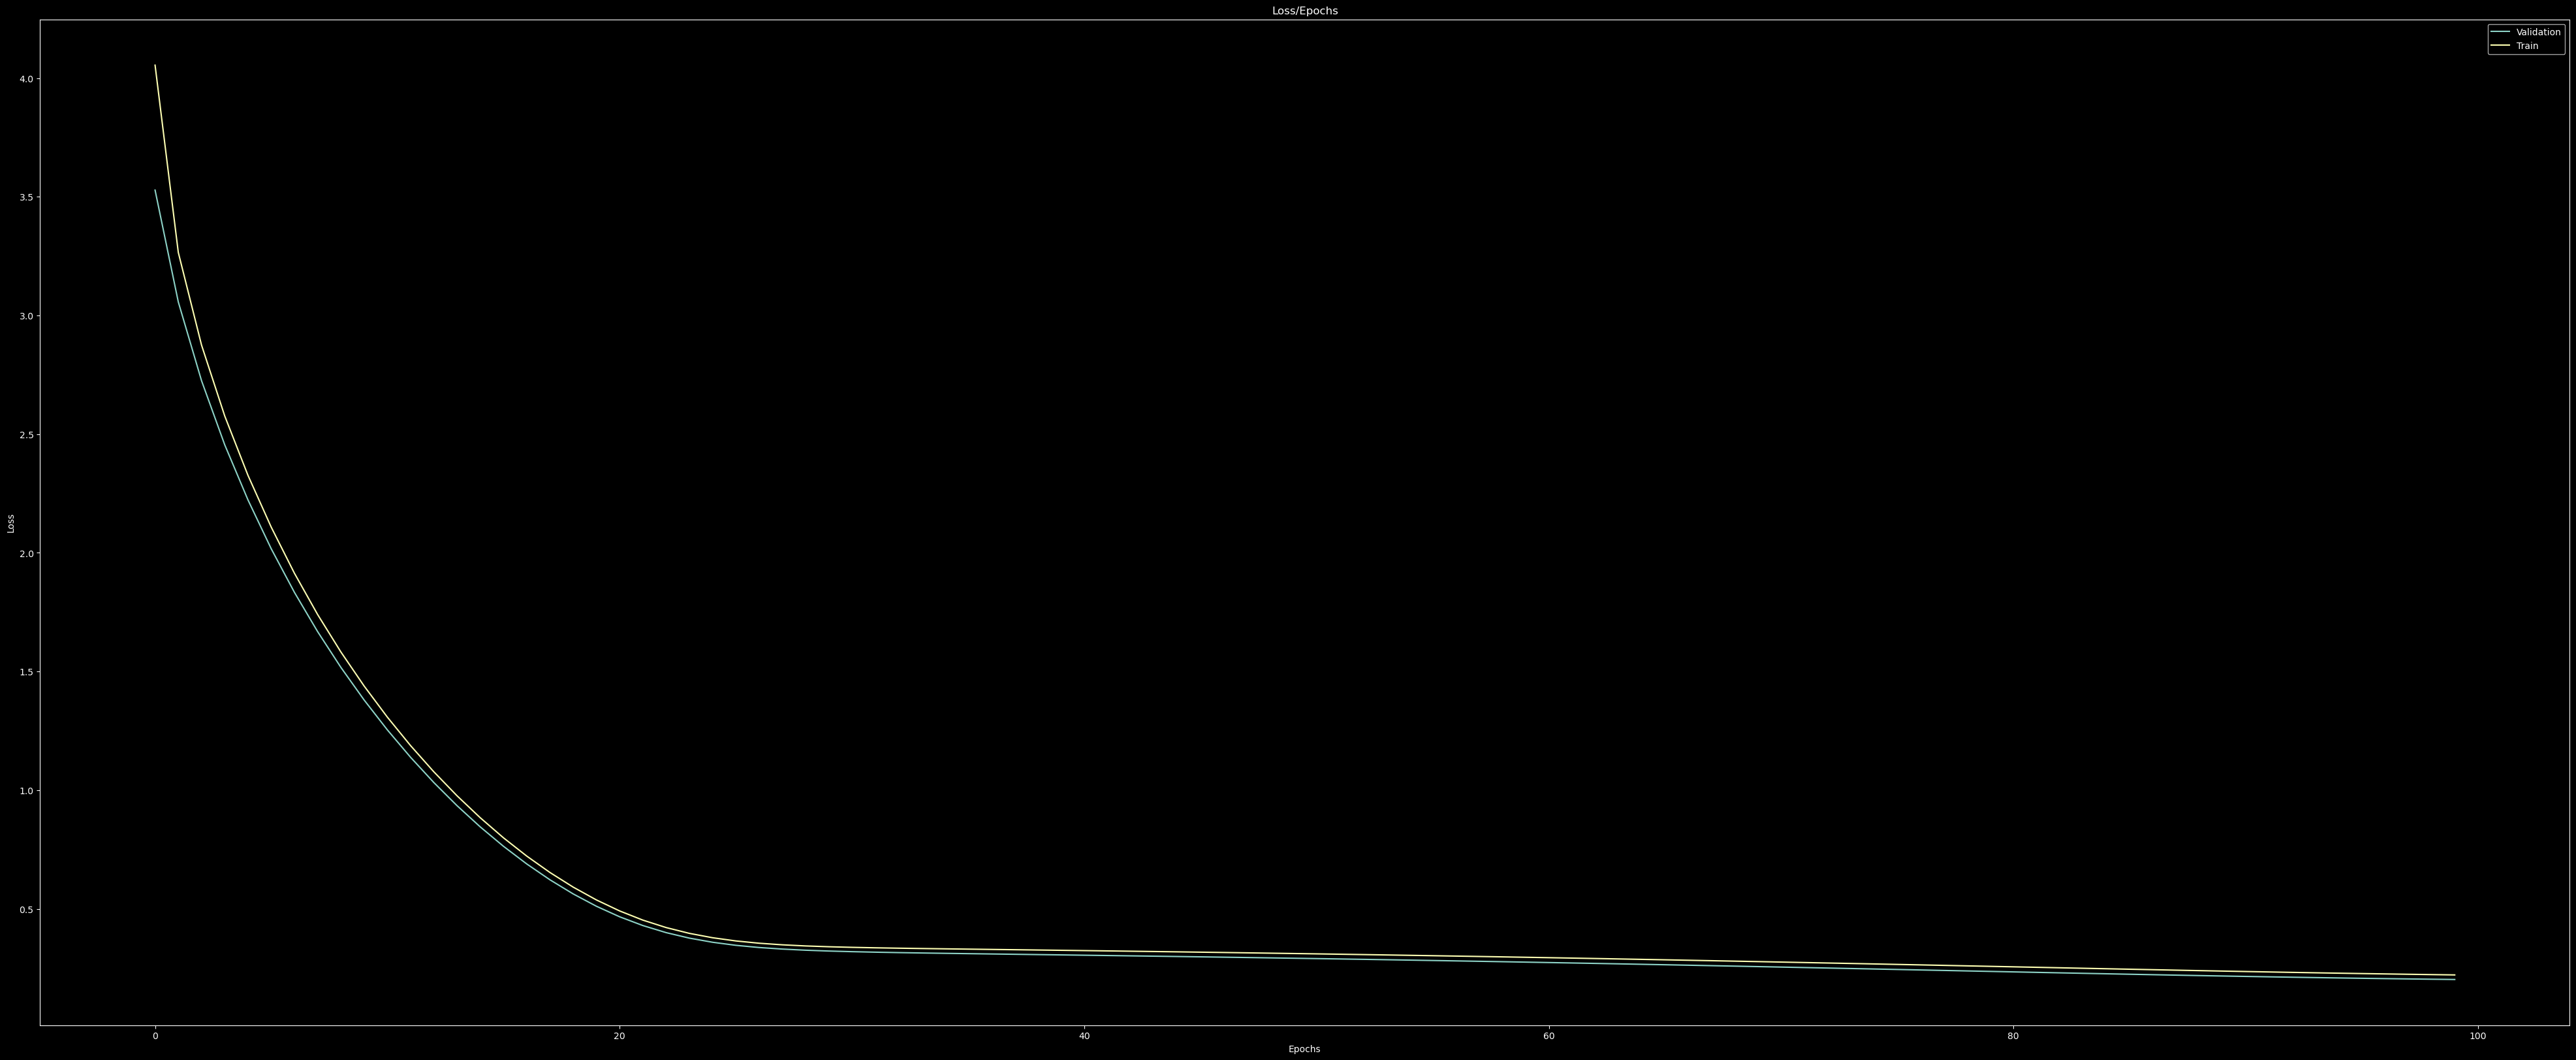

NN with 100.0 neurons
Last epoch train error 0.22195173799991608
Last epoch validation error 0.20273754000663757


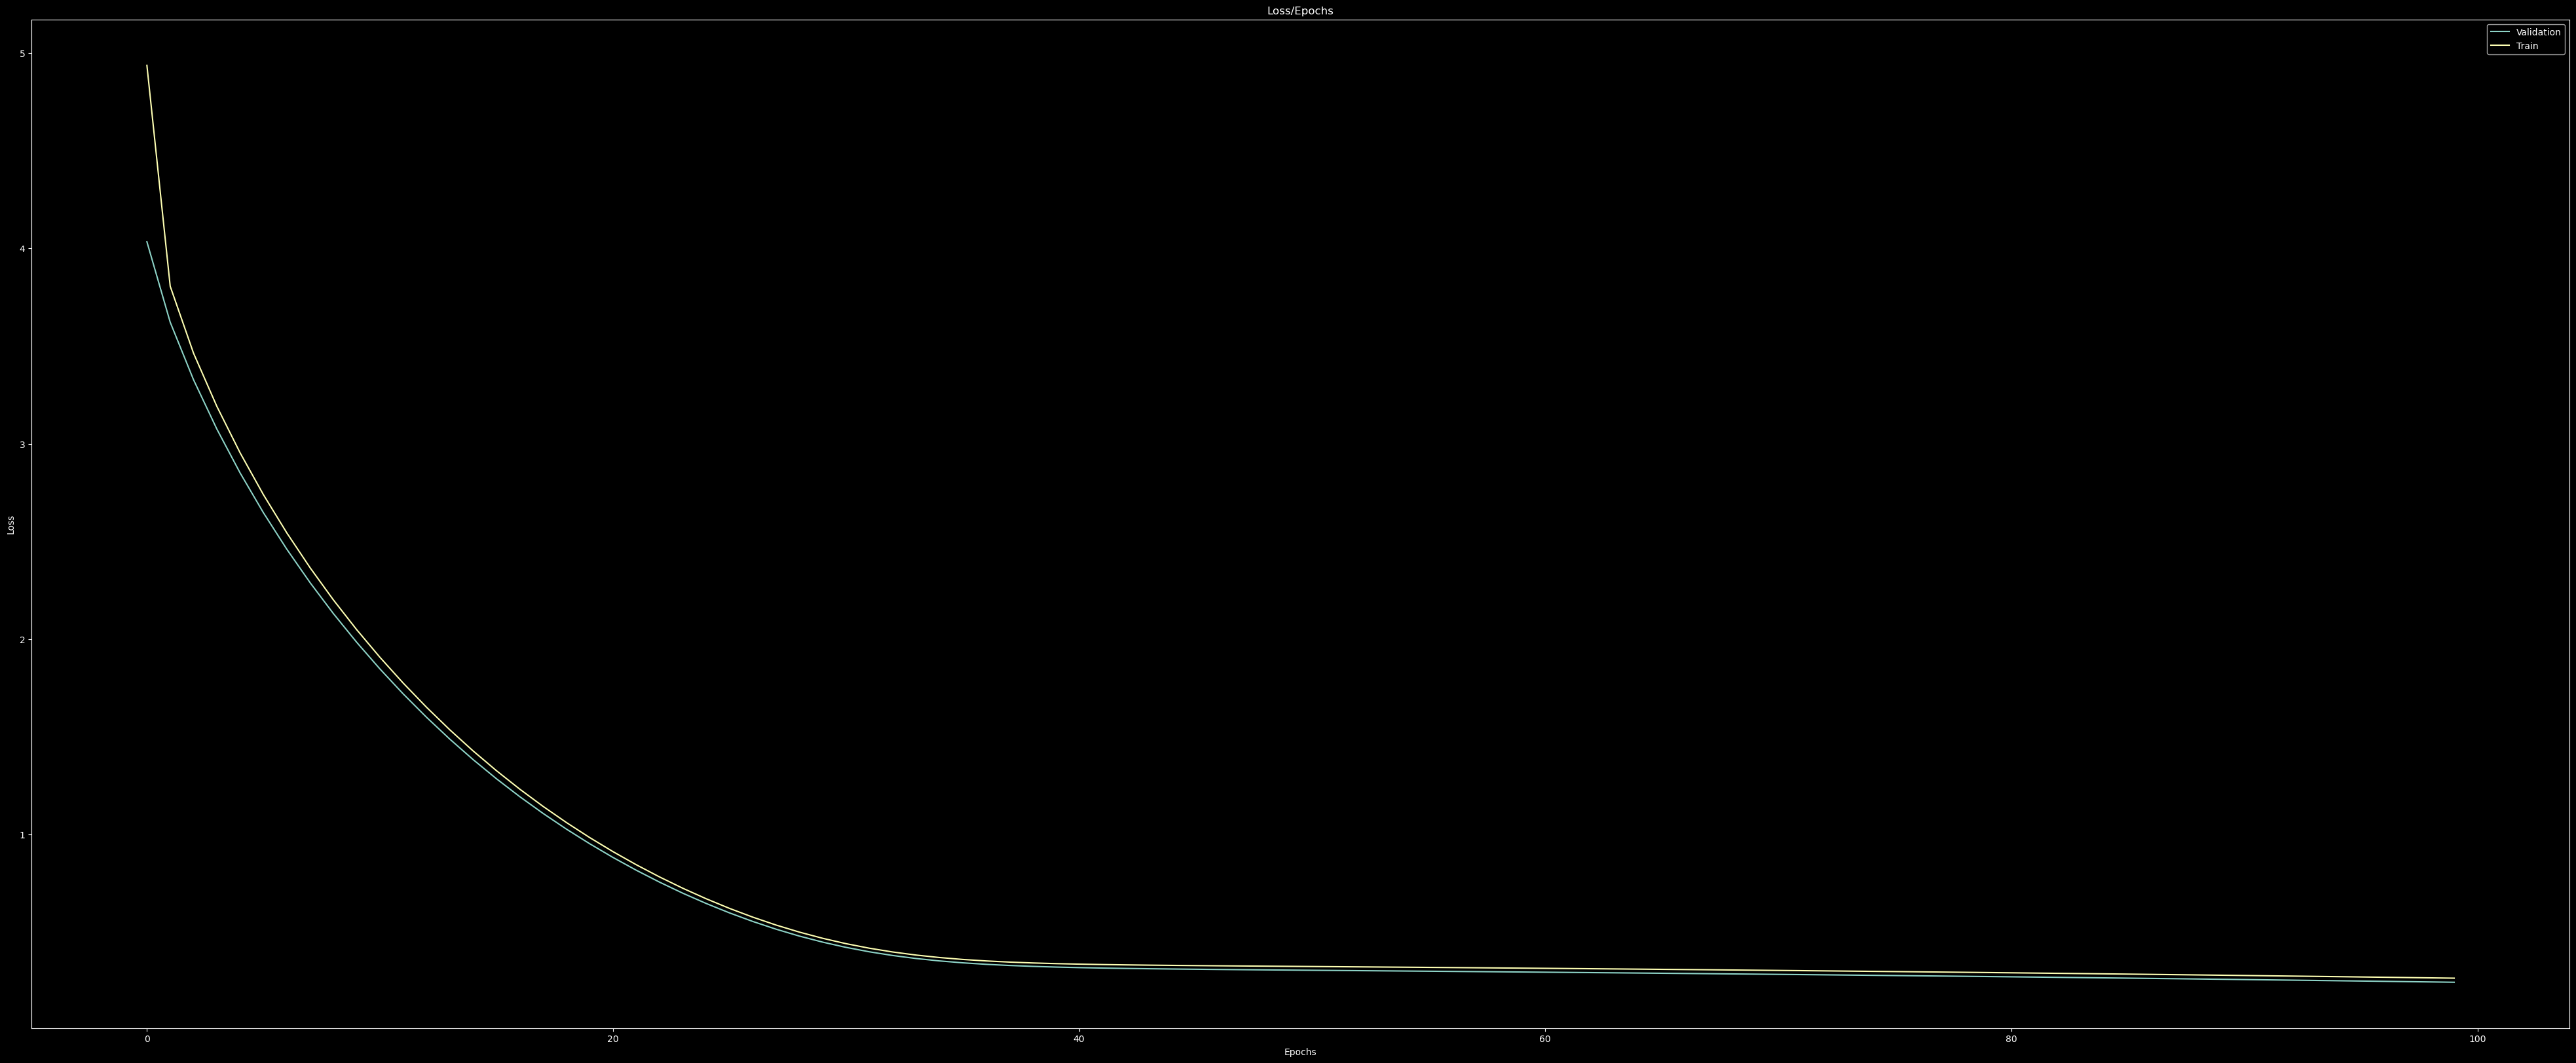

NN with 177.82794100389228 neurons
Last epoch train error 0.26475760340690613
Last epoch validation error 0.24387145042419434


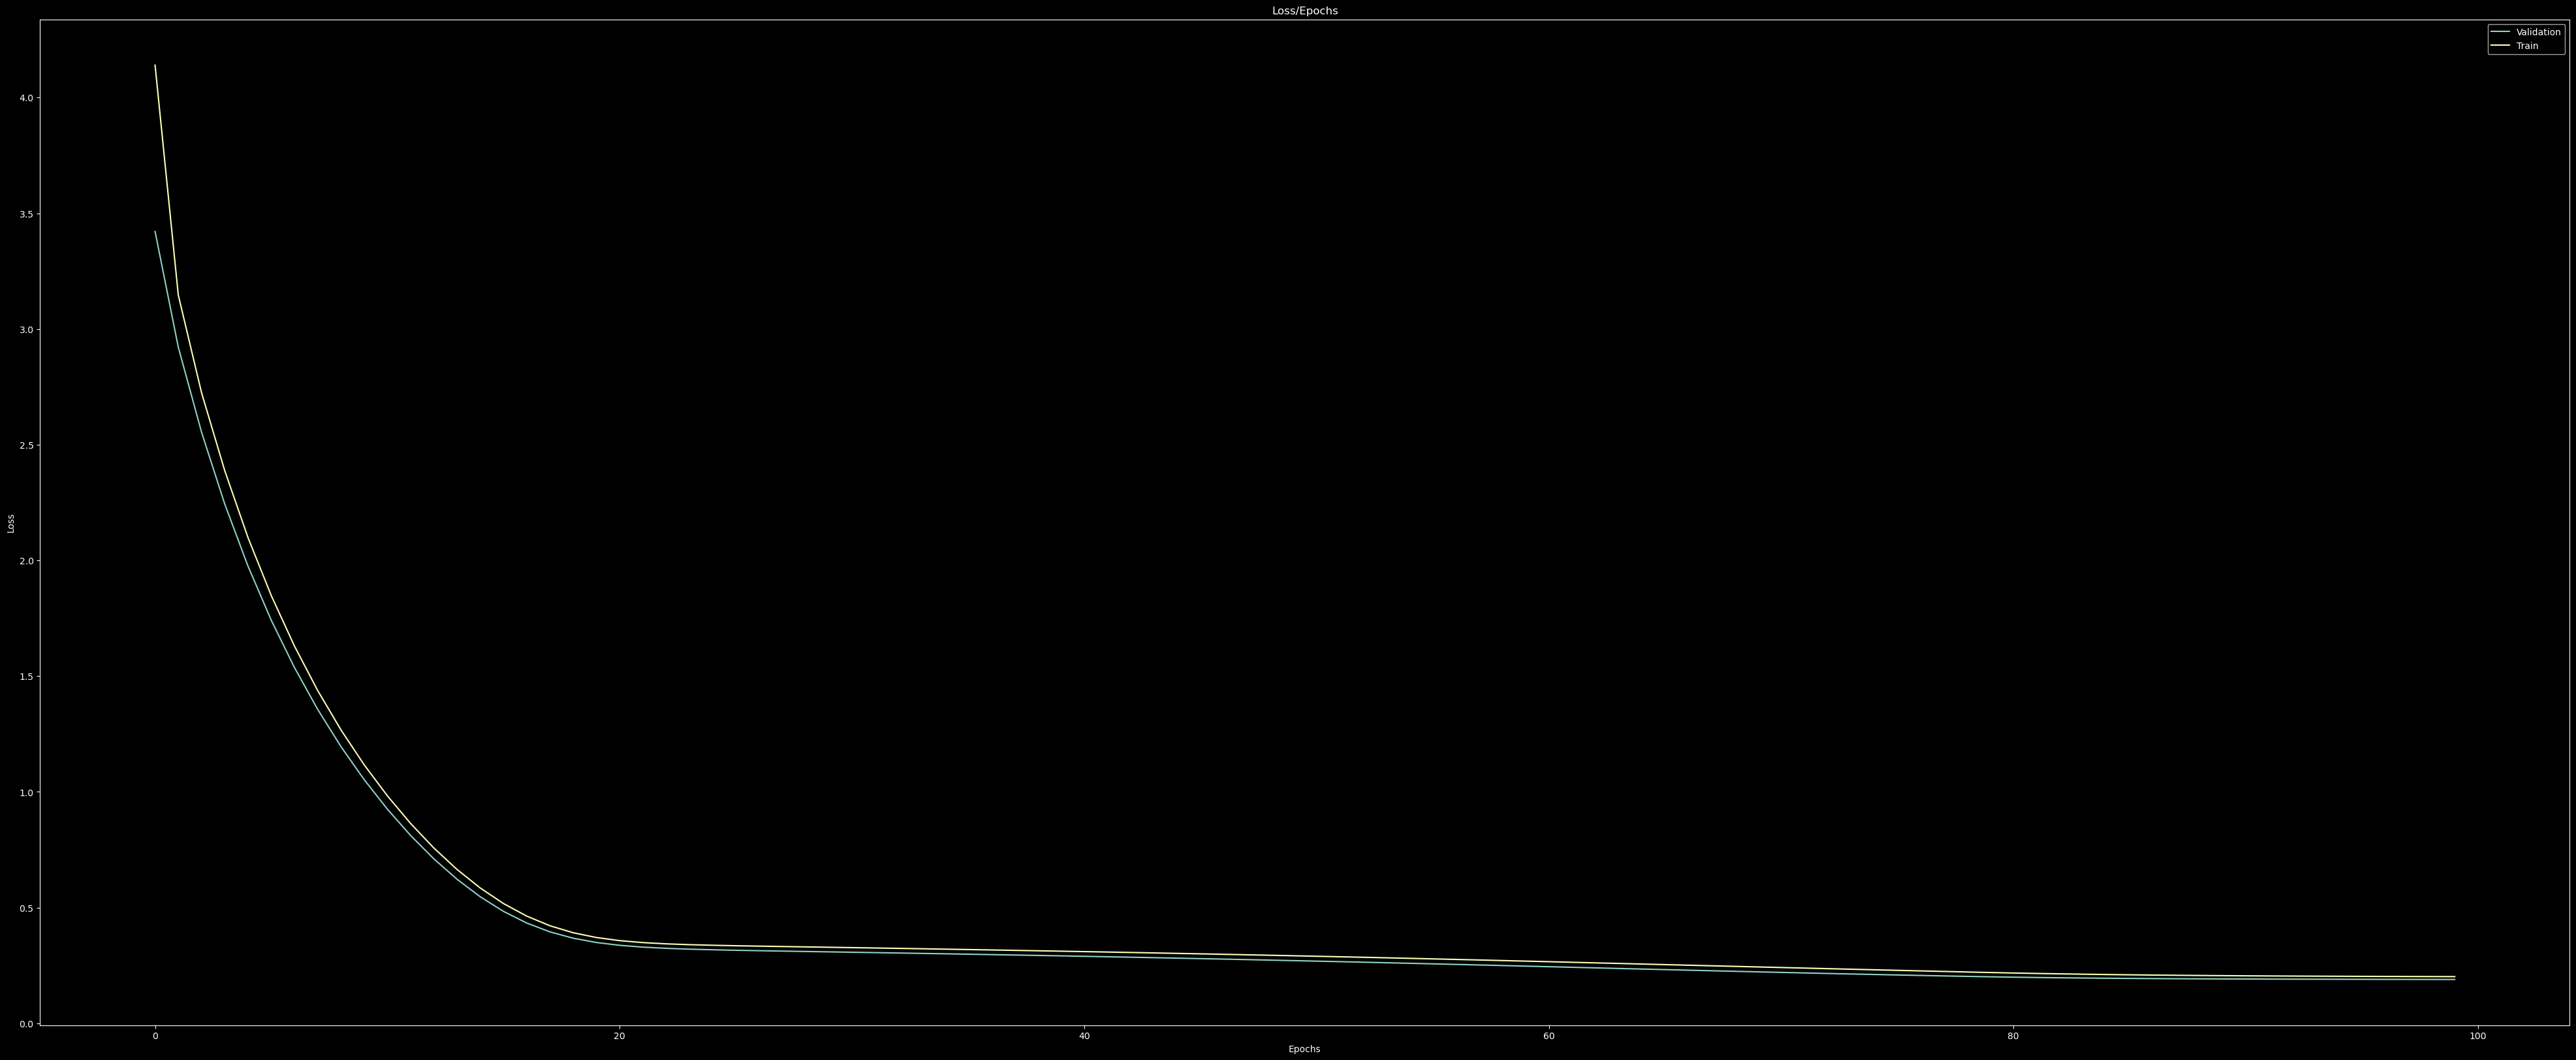

NN with 316.22776601683796 neurons
Last epoch train error 0.20180368423461914
Last epoch validation error 0.18943846225738525


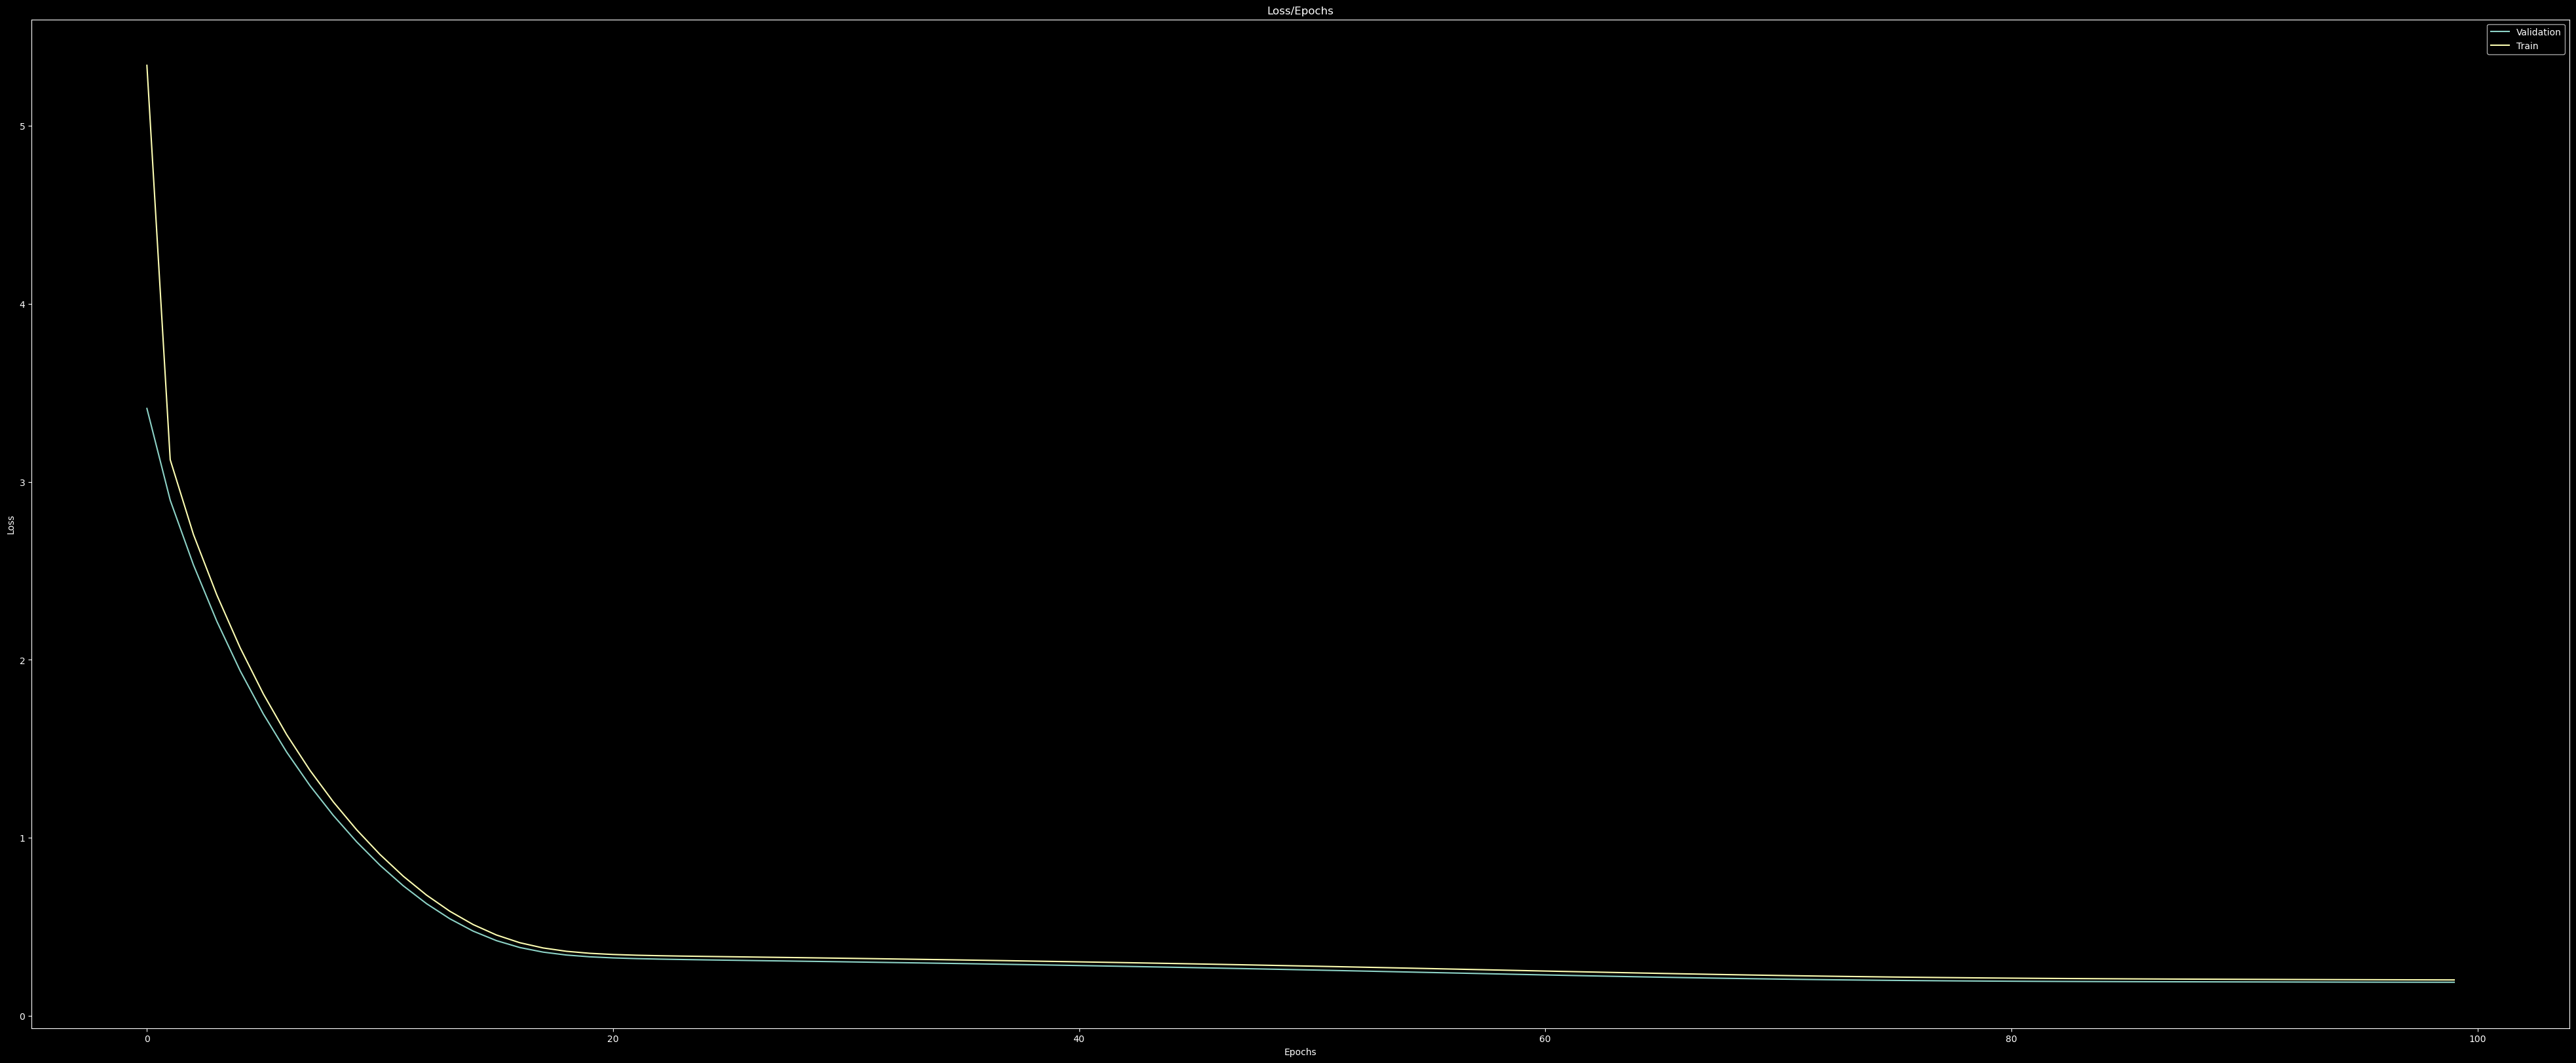

NN with 562.341325190349 neurons
Last epoch train error 0.20172274112701416
Last epoch validation error 0.18859994411468506


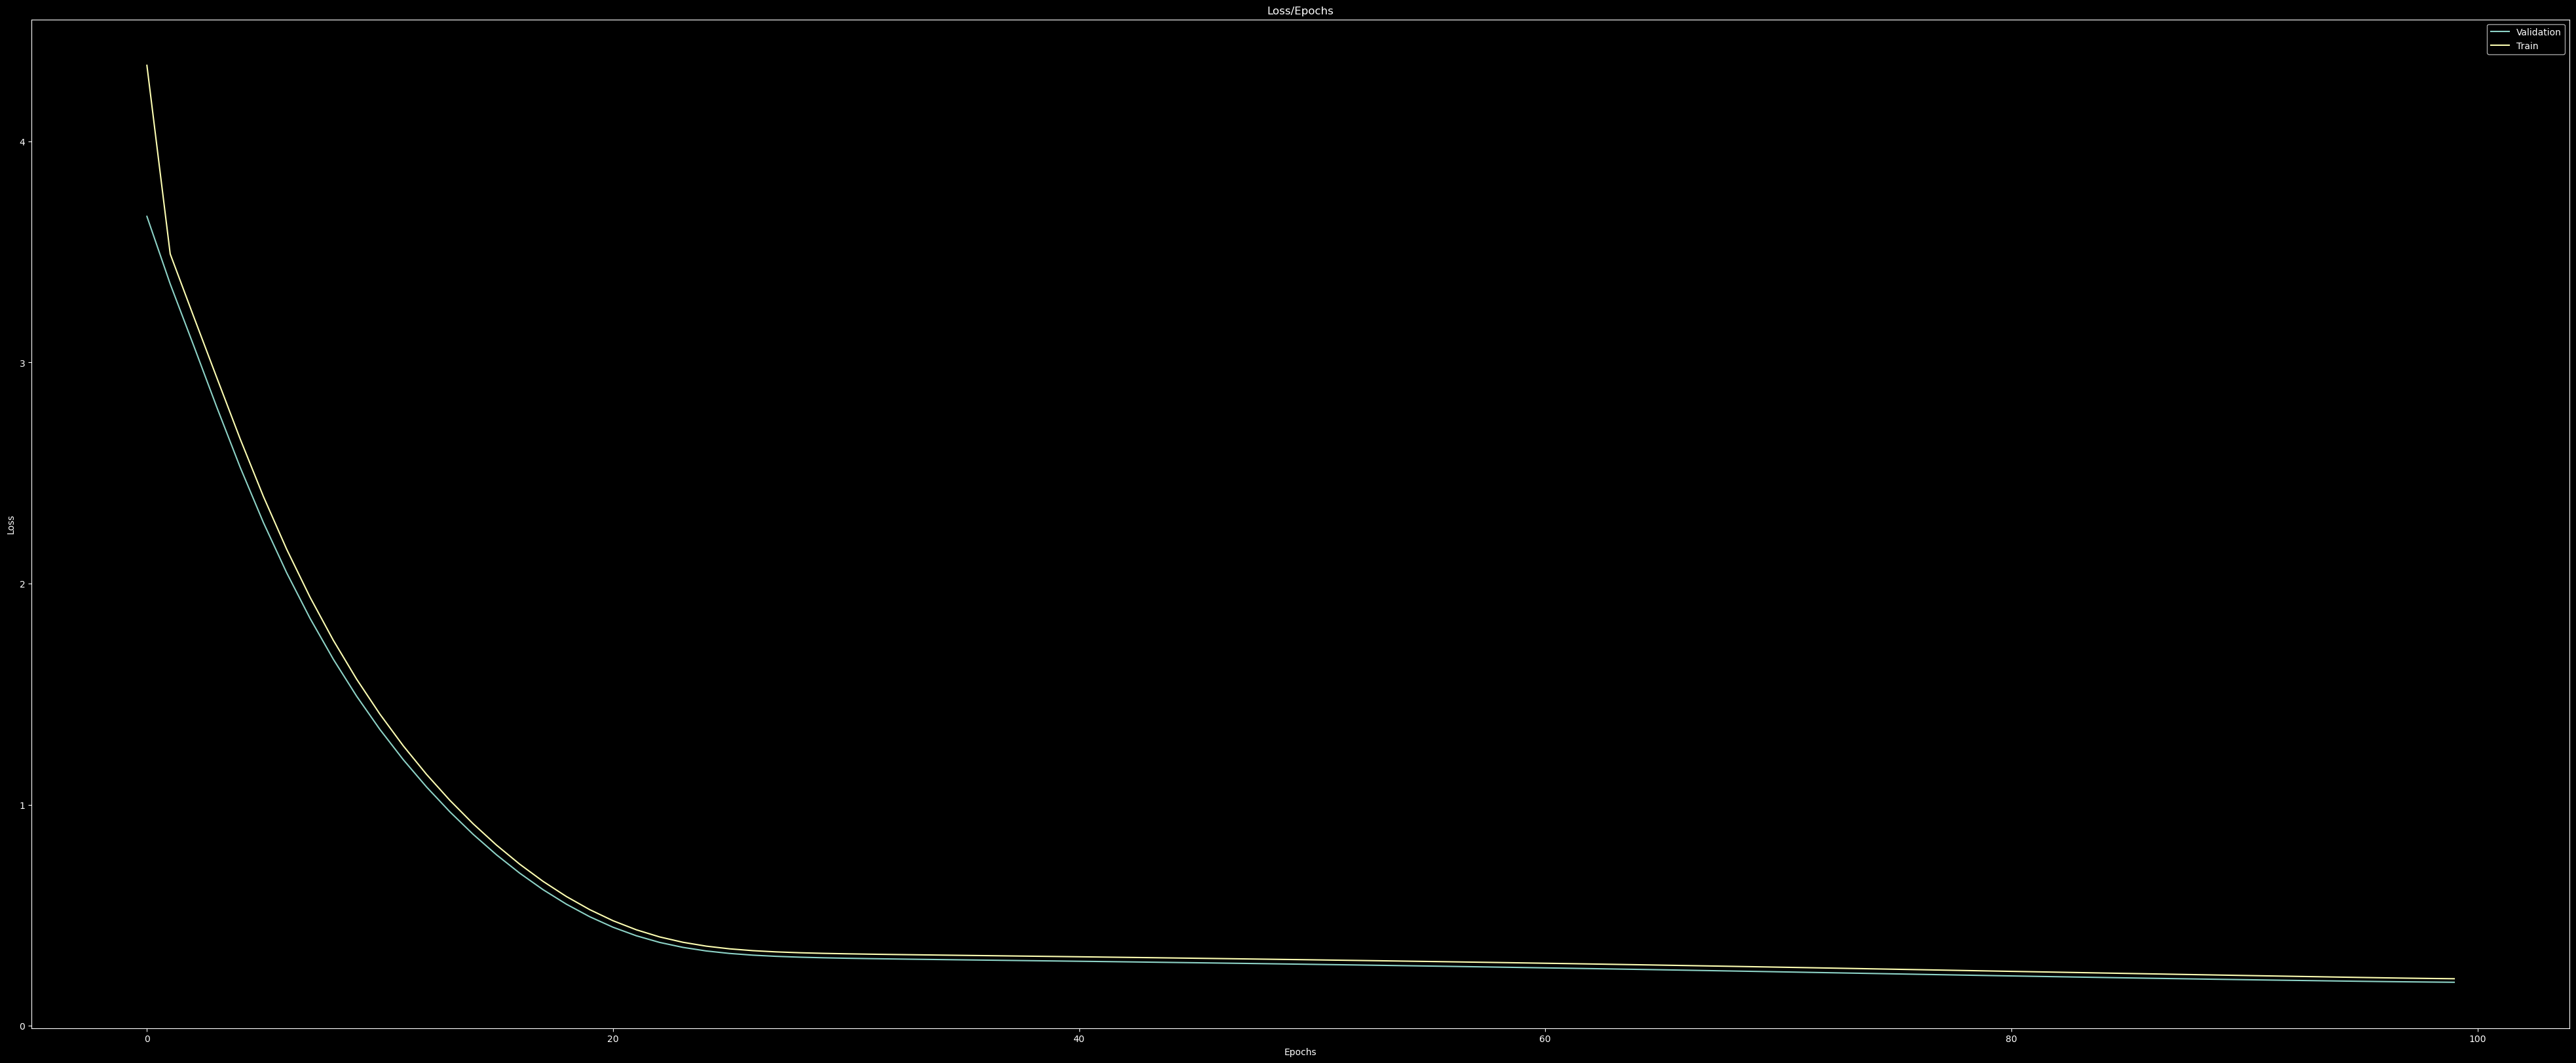

NN with 1000.0 neurons
Last epoch train error 0.21279652416706085
Last epoch validation error 0.19689448177814484


In [11]:
param_space_hidden_layer_size = np.logspace(start=2, stop=3, base=10, num=5)
results={}
for p in param_space_hidden_layer_size:
    nn = models.Sequential(
        [
            layers.Input((X_tr_proc.shape[1],)),
            layers.Dense(
                int(p),
                activation=activations.leaky_relu,
                kernel_initializer=GlorotUniform(0),
            ),
            layers.Dense(
                1, activation=activations.relu, kernel_initializer=GlorotUniform(0)
            ),
        ]
    )
    tr_err,_=train_nn(epochs=100, nn=nn, X=X_tr_proc, y=Y_tr, should_print_epoch_losses=True,additional_print_msg=f'NN with {p} neurons')
    results[p]=tr_err

Relu imat eden golem problem narechen dying relu problem. So cel da go izbegnime toj probelm, ne celosno, ke upotrebime constraint na weights t.s. nikogash nemat da se site negativni, a toa znachit deka linearniot del od nevronite nemat sekogash da e < 0, so znachit deka relu nemat nemat da e 0la. Pokraj dying relu problemot, pak sakam da koristam relu, bidejki mi gi klipvit site outputs na 0la. 

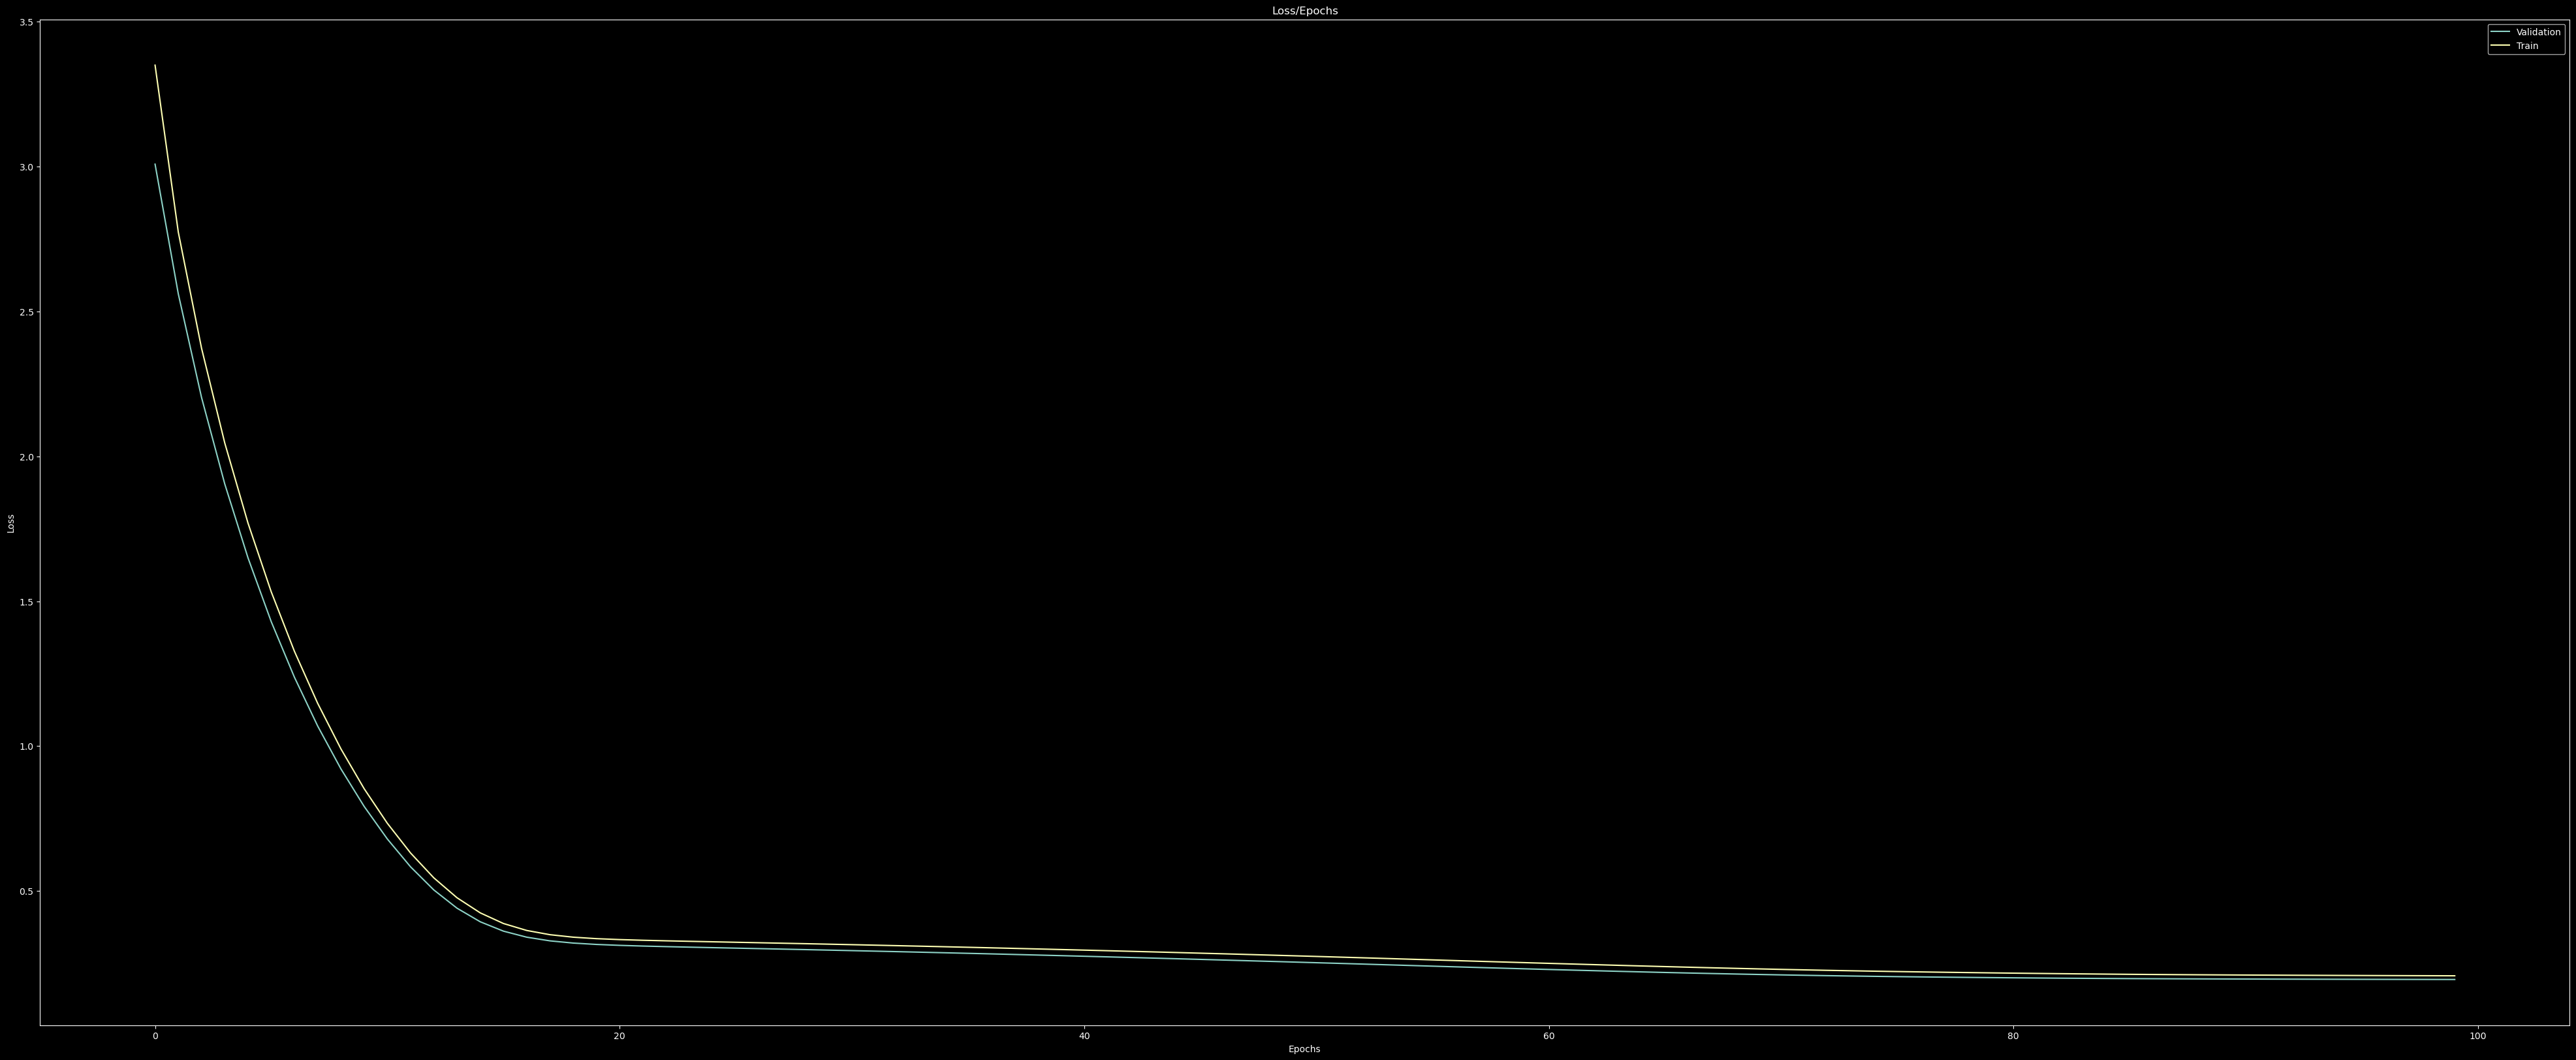

NN with 100.0 neurons
Last epoch train error 0.20703184604644775
Last epoch validation error 0.19426187872886658


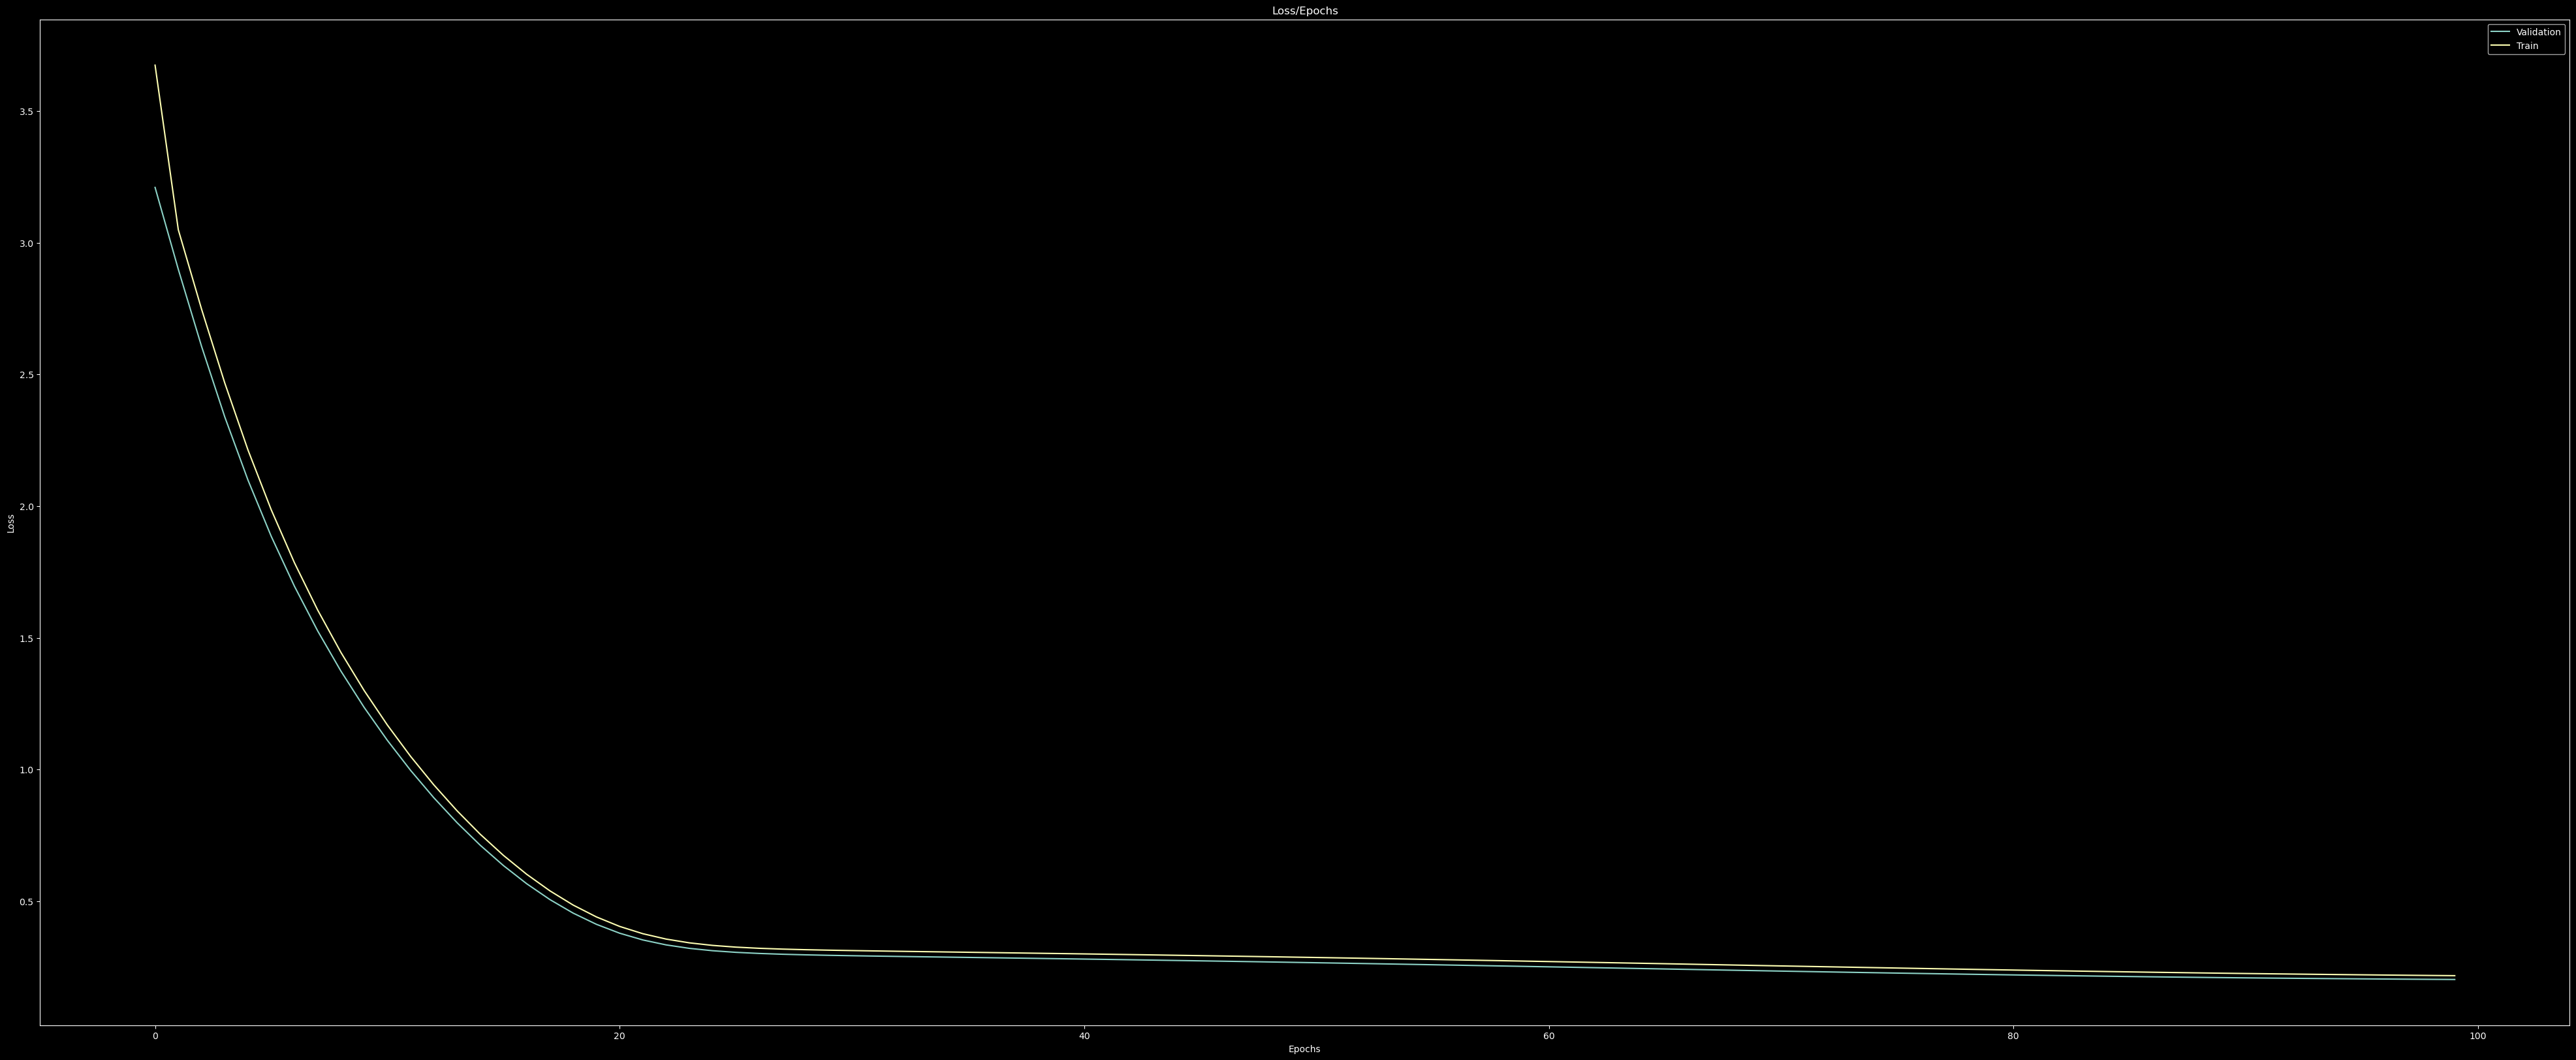

NN with 177.82794100389228 neurons
Last epoch train error 0.21677152812480927
Last epoch validation error 0.20228607952594757


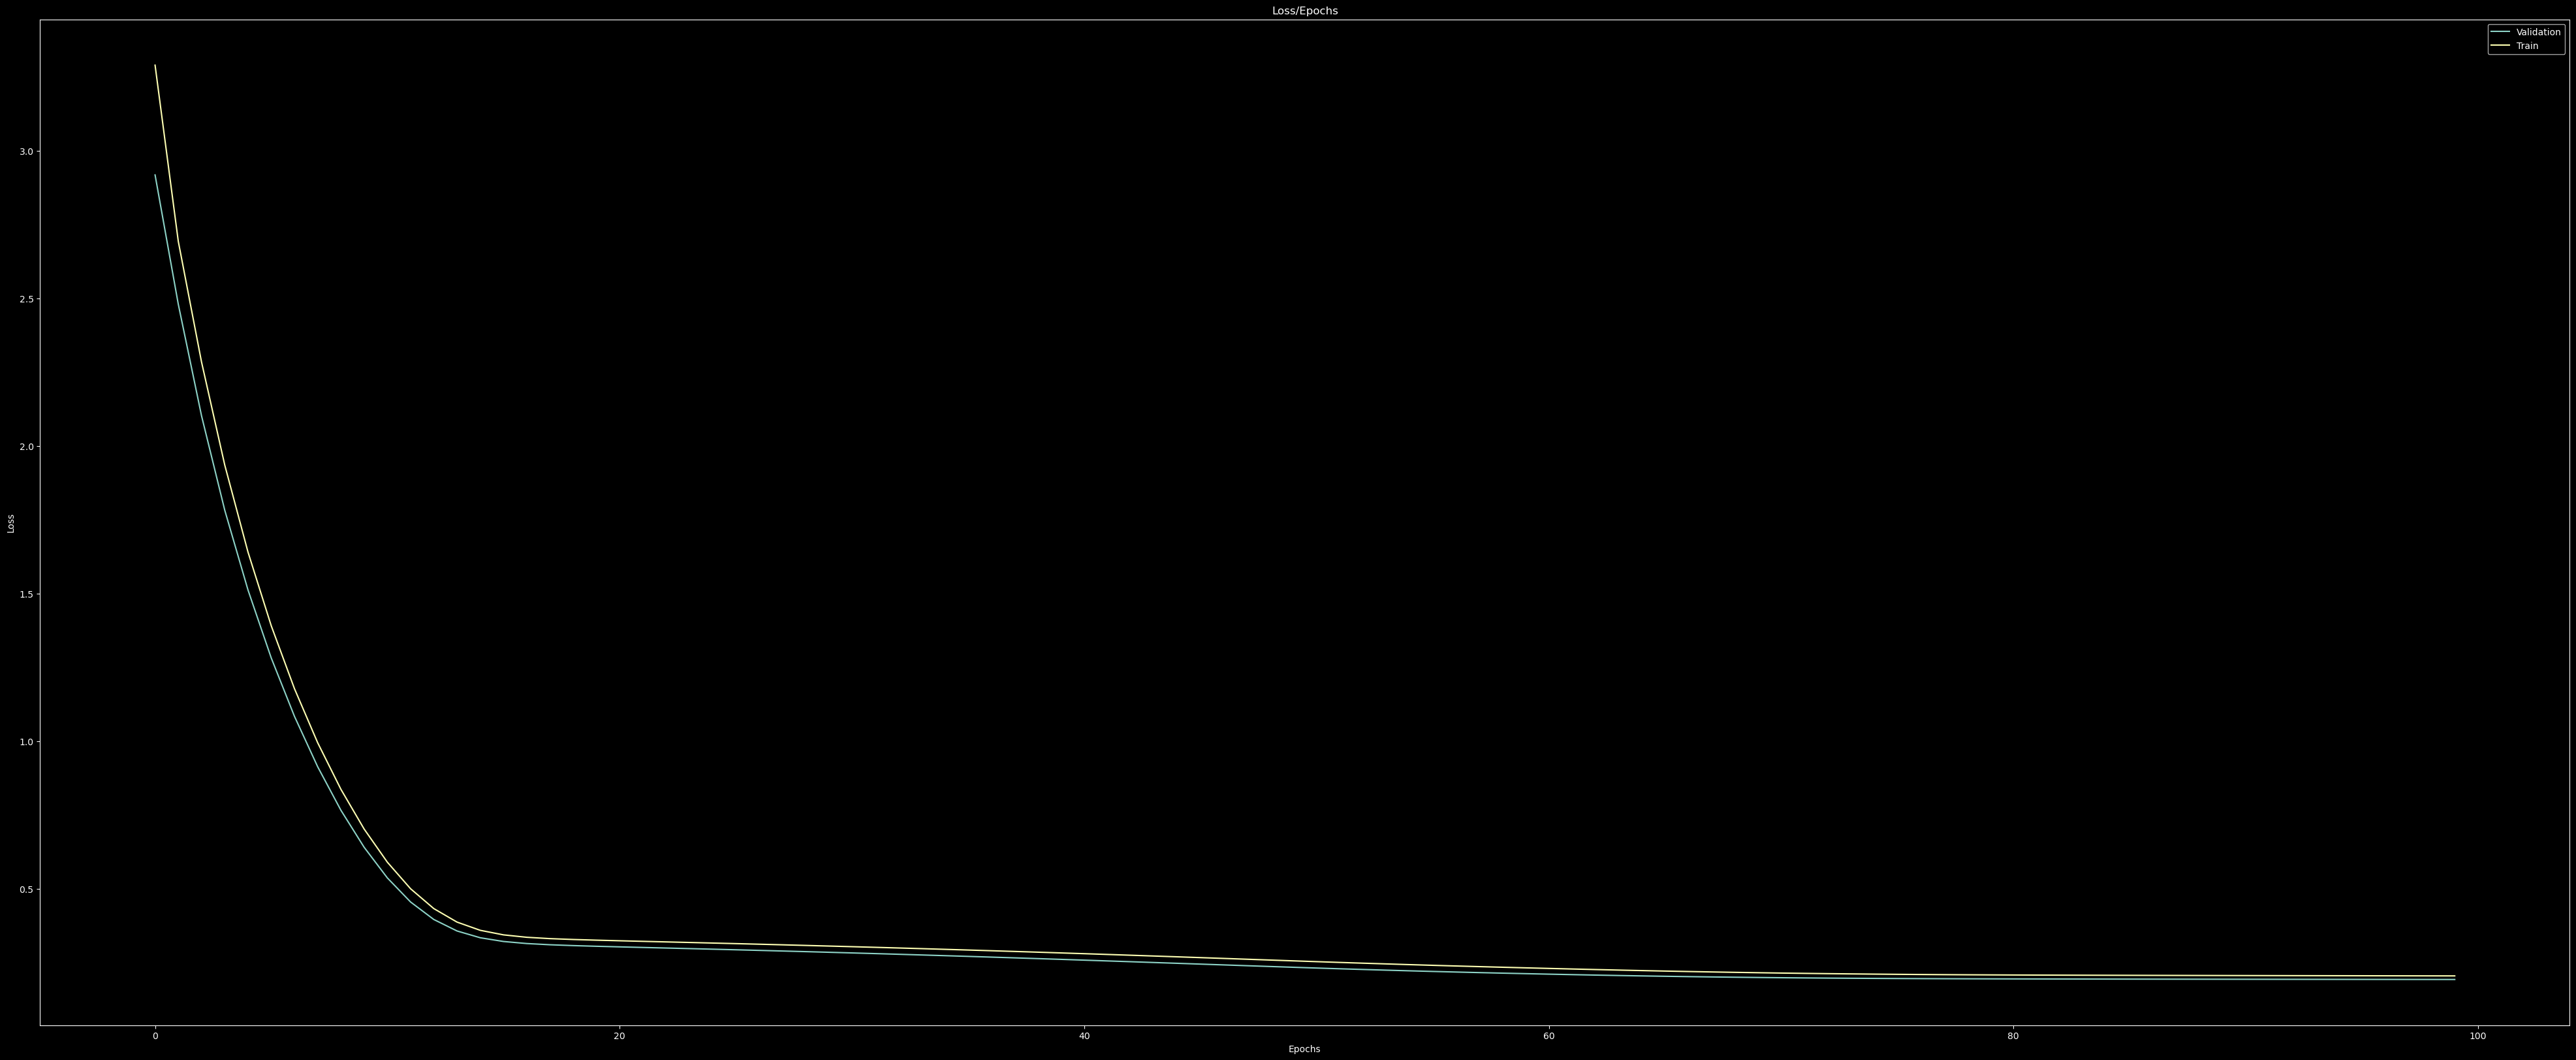

NN with 316.22776601683796 neurons
Last epoch train error 0.20509891211986542
Last epoch validation error 0.19289866089820862


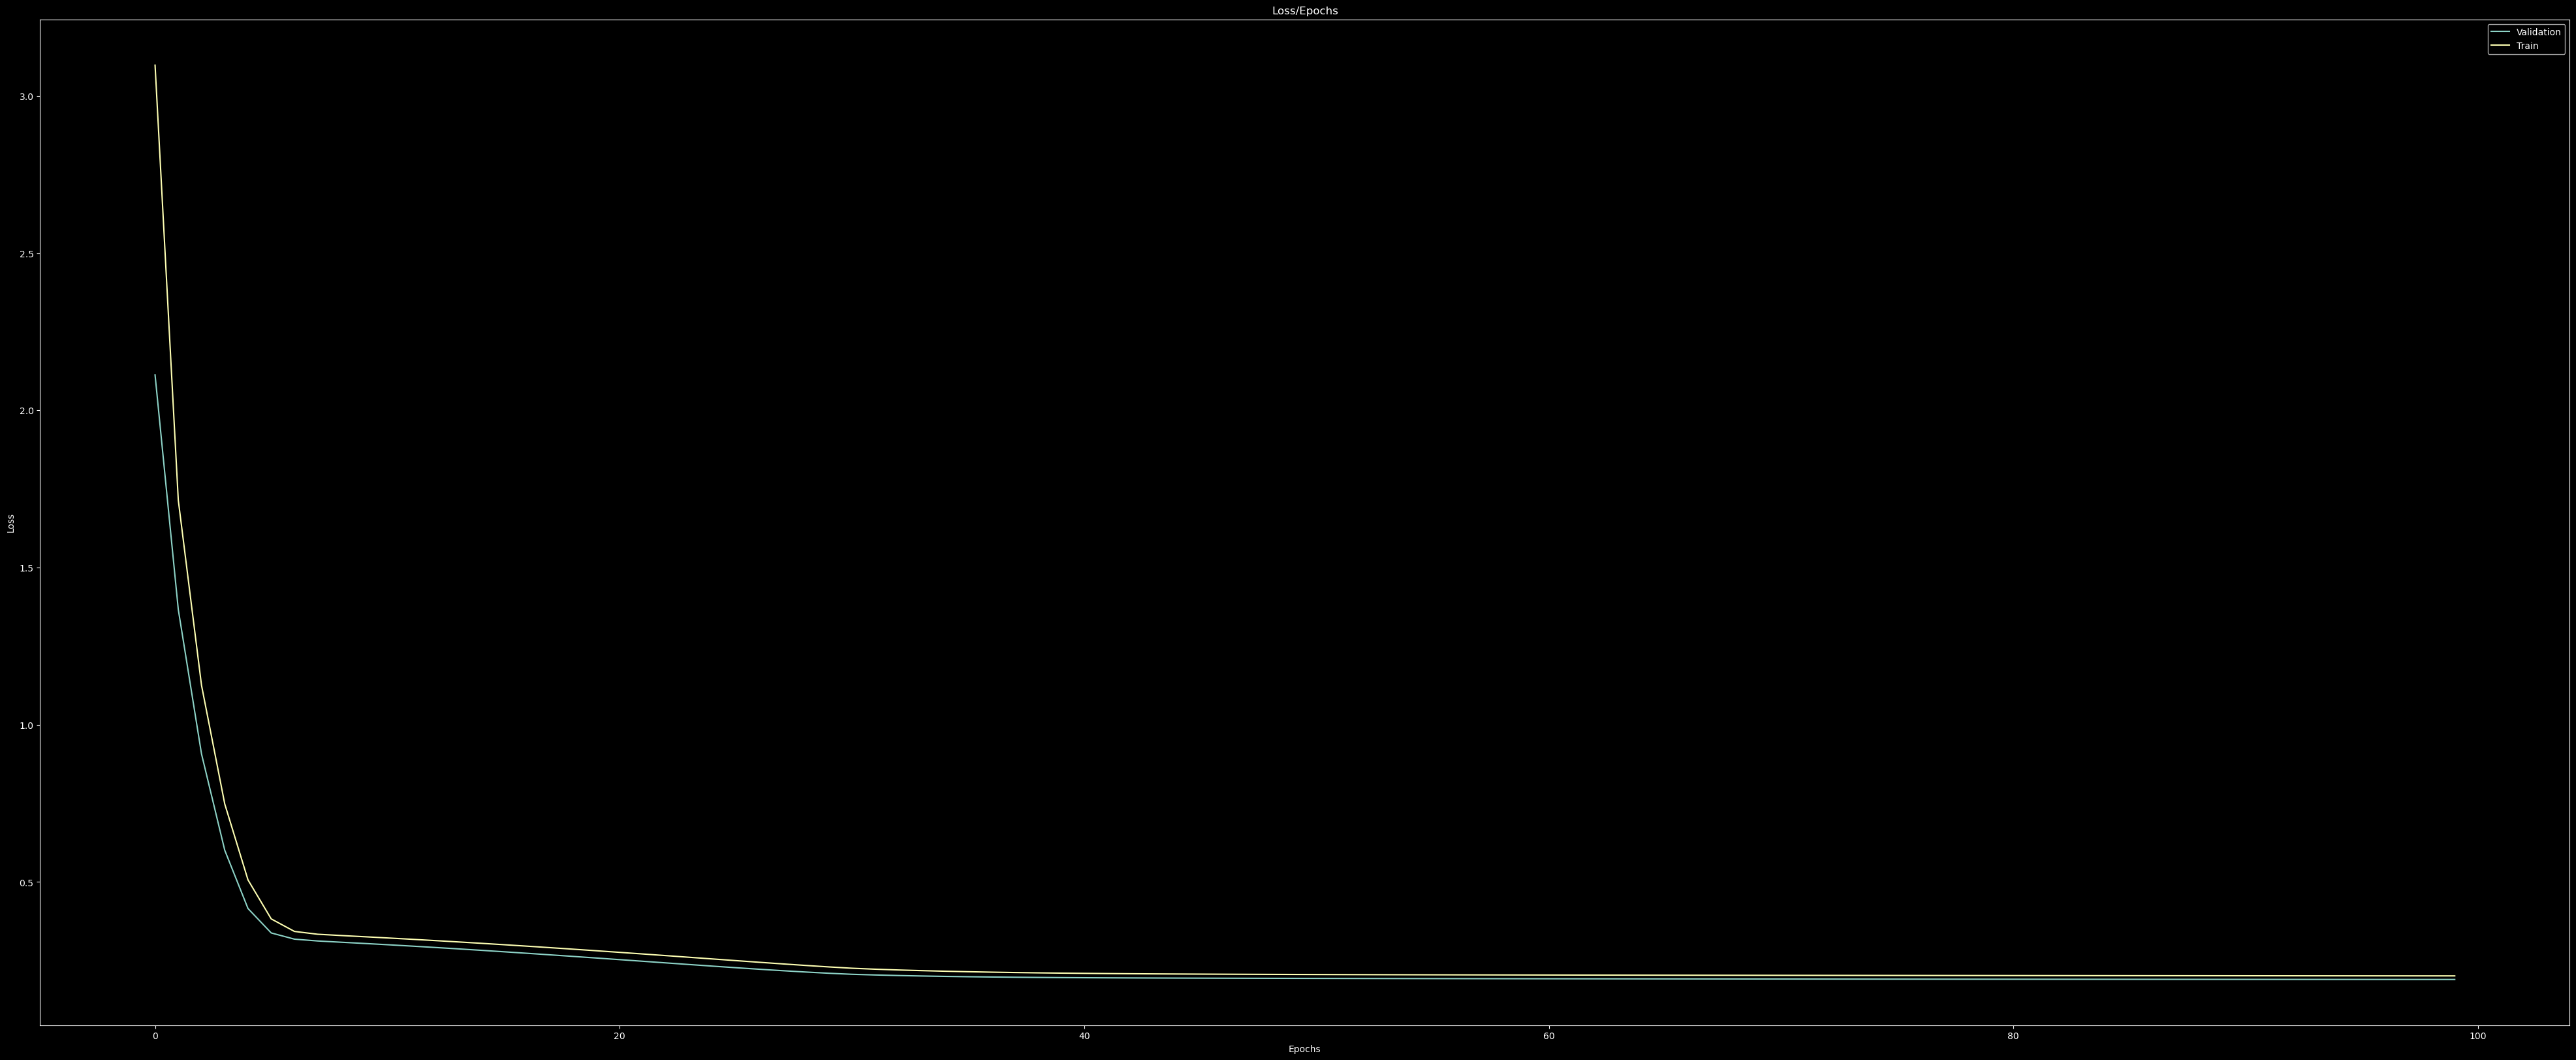

NN with 562.341325190349 neurons
Last epoch train error 0.20133329927921295
Last epoch validation error 0.18987195193767548


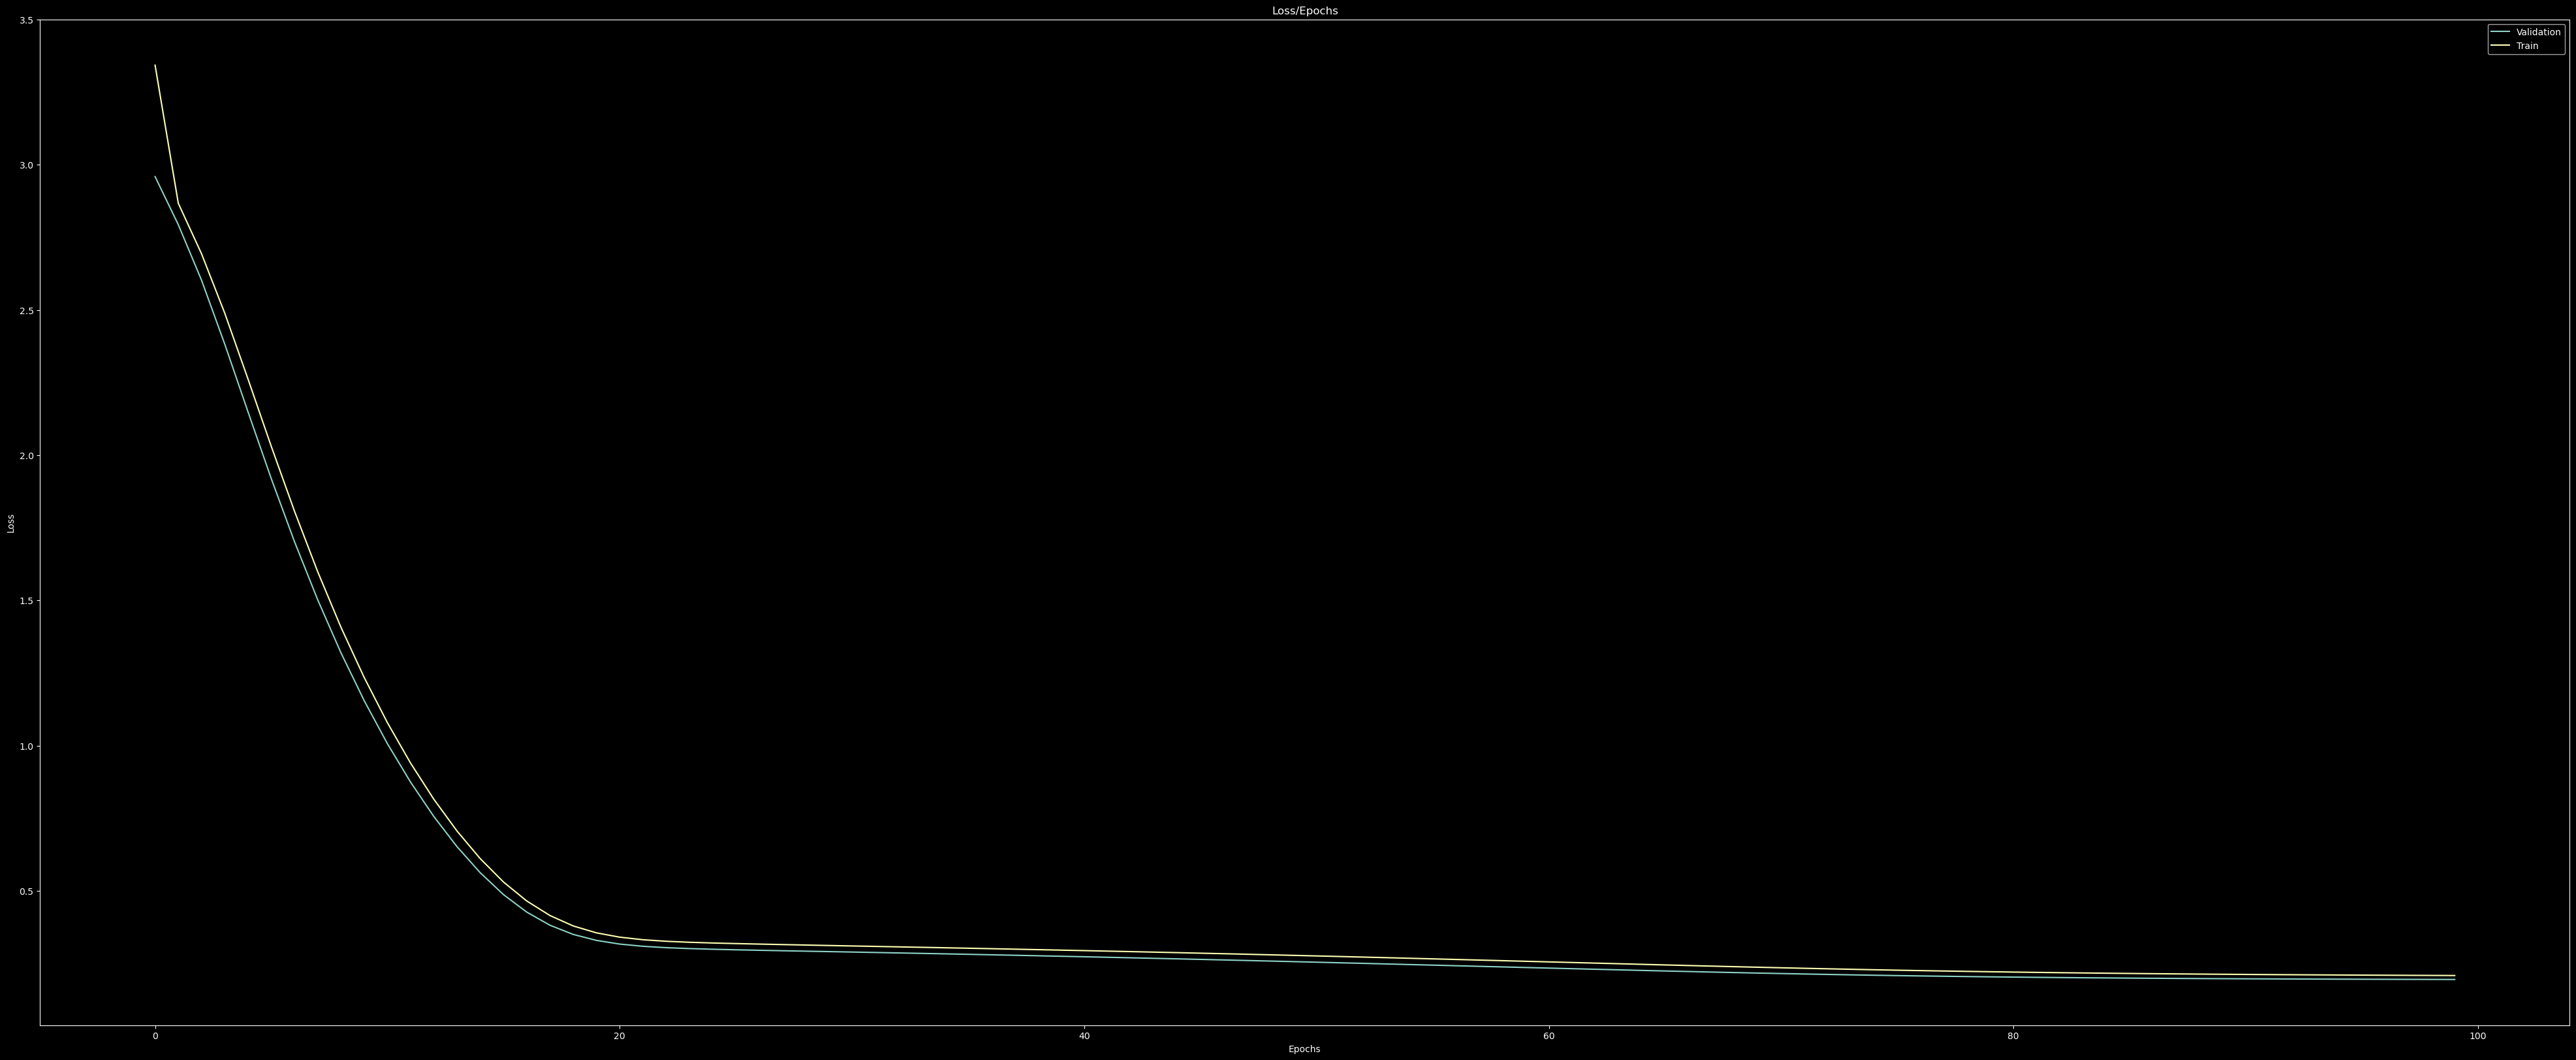

NN with 1000.0 neurons
Last epoch train error 0.20834526419639587
Last epoch validation error 0.19471748173236847


In [15]:
param_space_hidden_layer_size = np.logspace(start=2, stop=3, base=10, num=5)
results = {}
for p in param_space_hidden_layer_size:
    nn = models.Sequential(
        [
            layers.Input((X_tr_proc.shape[1],)),
            layers.Dense(
                int(p),
                activation=activations.leaky_relu,
                kernel_initializer=GlorotUniform(0),
                kernel_constraint=layer_constraints.NonNeg(),
            ),
            layers.Dense(
                1, 
                activation=activations.relu,
                kernel_initializer=GlorotUniform(0),
                kernel_constraint=layer_constraints.NonNeg() 
            ),
        ]
    )
    tr_err, _ = train_nn(
        epochs=100,
        nn=nn,
        X=X_tr_proc,
        y=Y_tr,
        should_print_epoch_losses=True,
        additional_print_msg=f"NN with {p} neurons",
    )
    results[p] = tr_err

In [16]:
pipe_scalling=copy.deepcopy(pipe_data) 
pipe_scalling.steps.append(("Scalling",StandardScaler())) 
pipe_scalling.fit(X_tr)
X_tr_scalled,X_test_scalled=pipe_scalling.transform(X_tr),pipe_scalling.transform(X_tst)

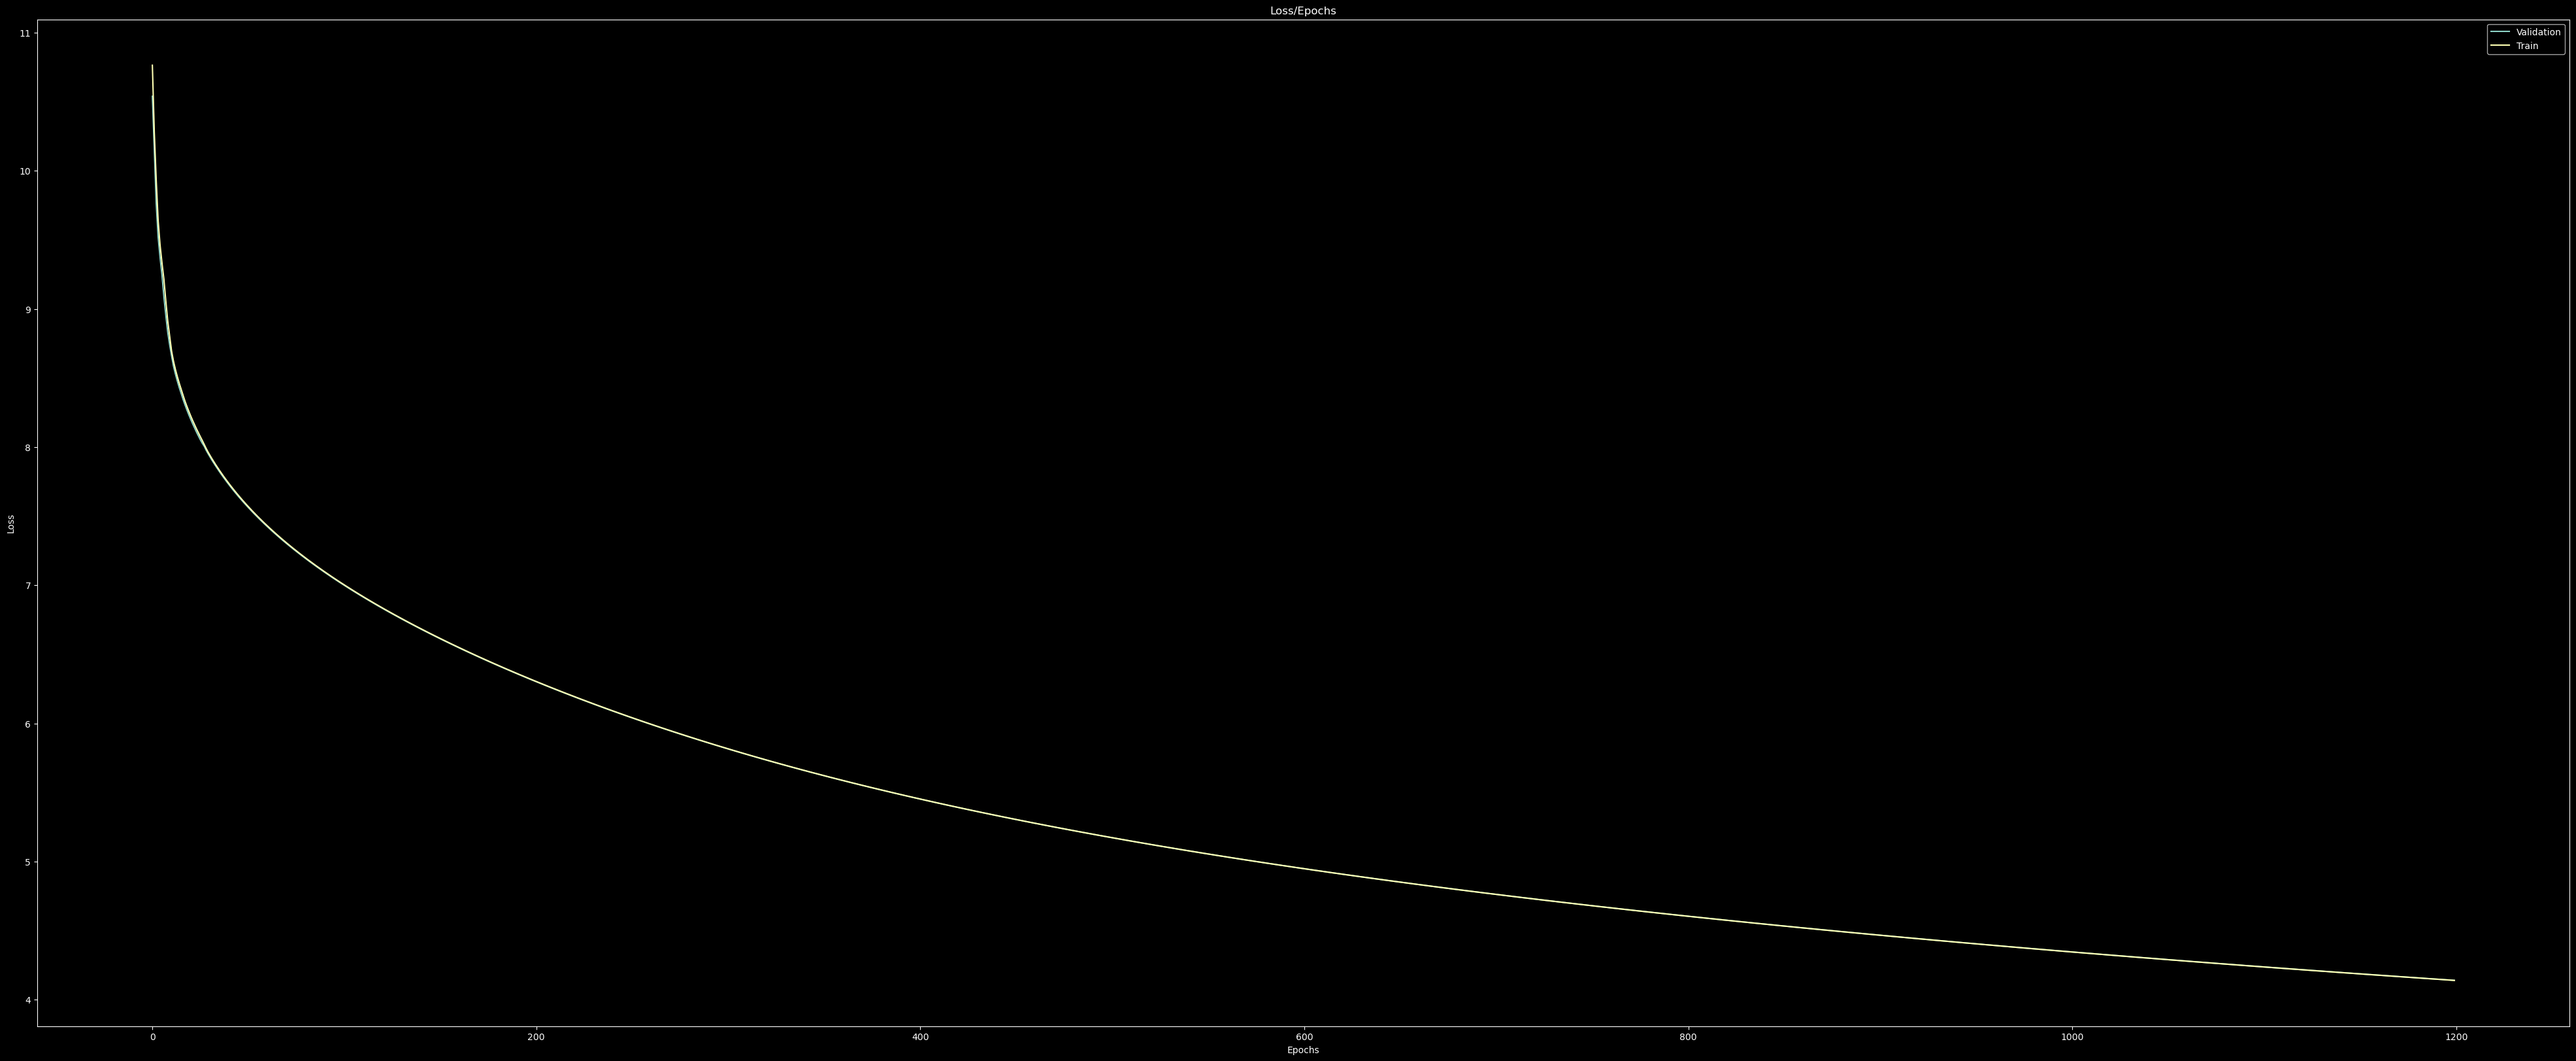

NN with 100 and <function tanh at 0x70dc15647eb0>
Last epoch train error 4.139806747436523
Last epoch validation error 4.140382766723633


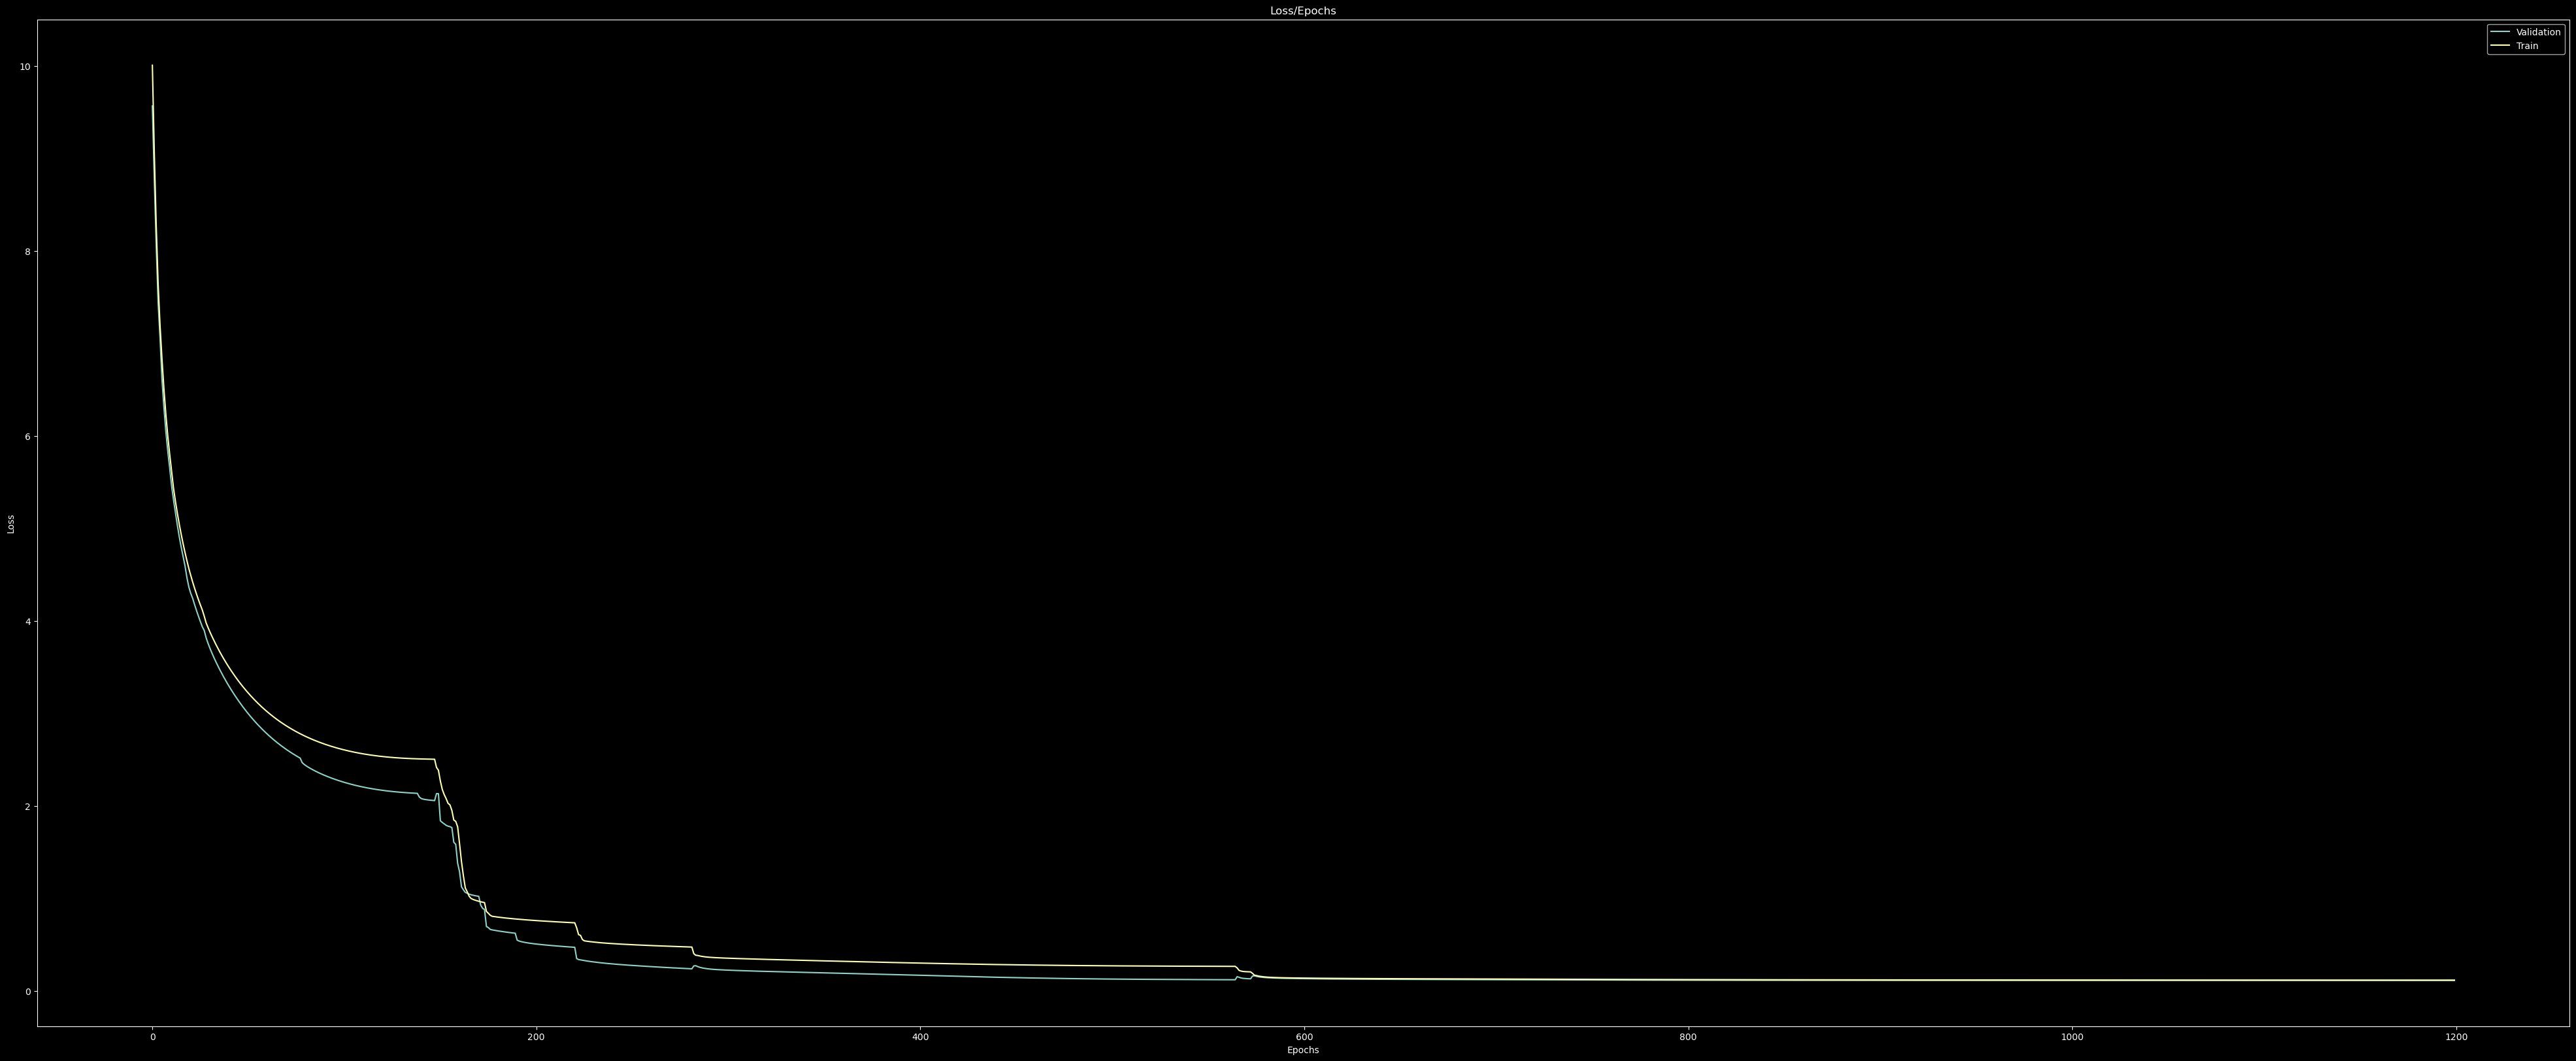

NN with 100 and <function leaky_relu at 0x70dc157863b0>
Last epoch train error 0.11815038323402405
Last epoch validation error 0.1153244897723198


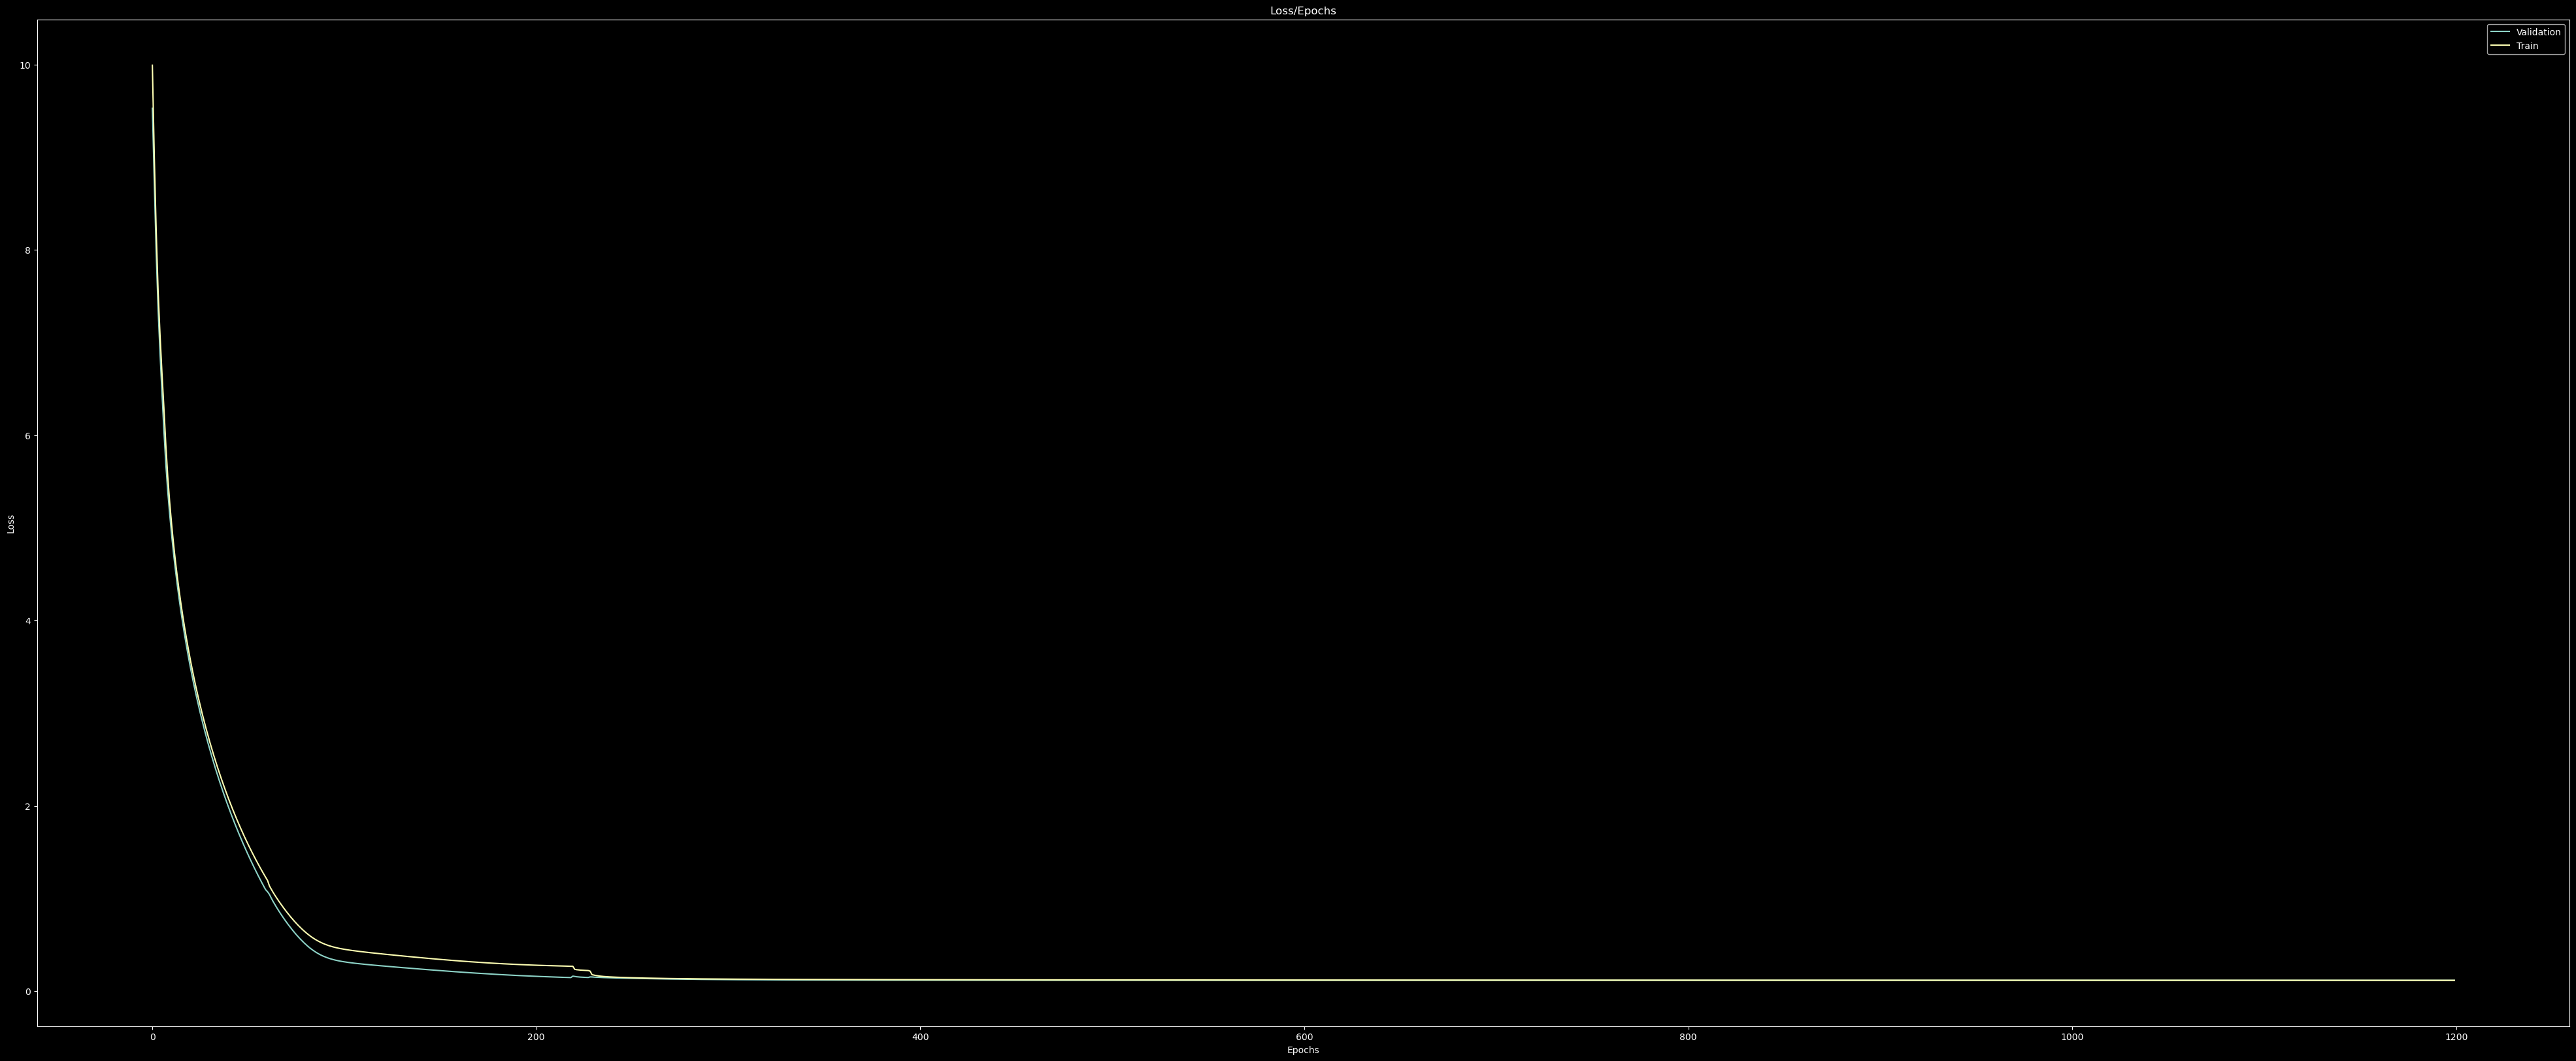

NN with 100 and <function relu at 0x70dc15bf7d00>
Last epoch train error 0.11652690917253494
Last epoch validation error 0.11575102806091309


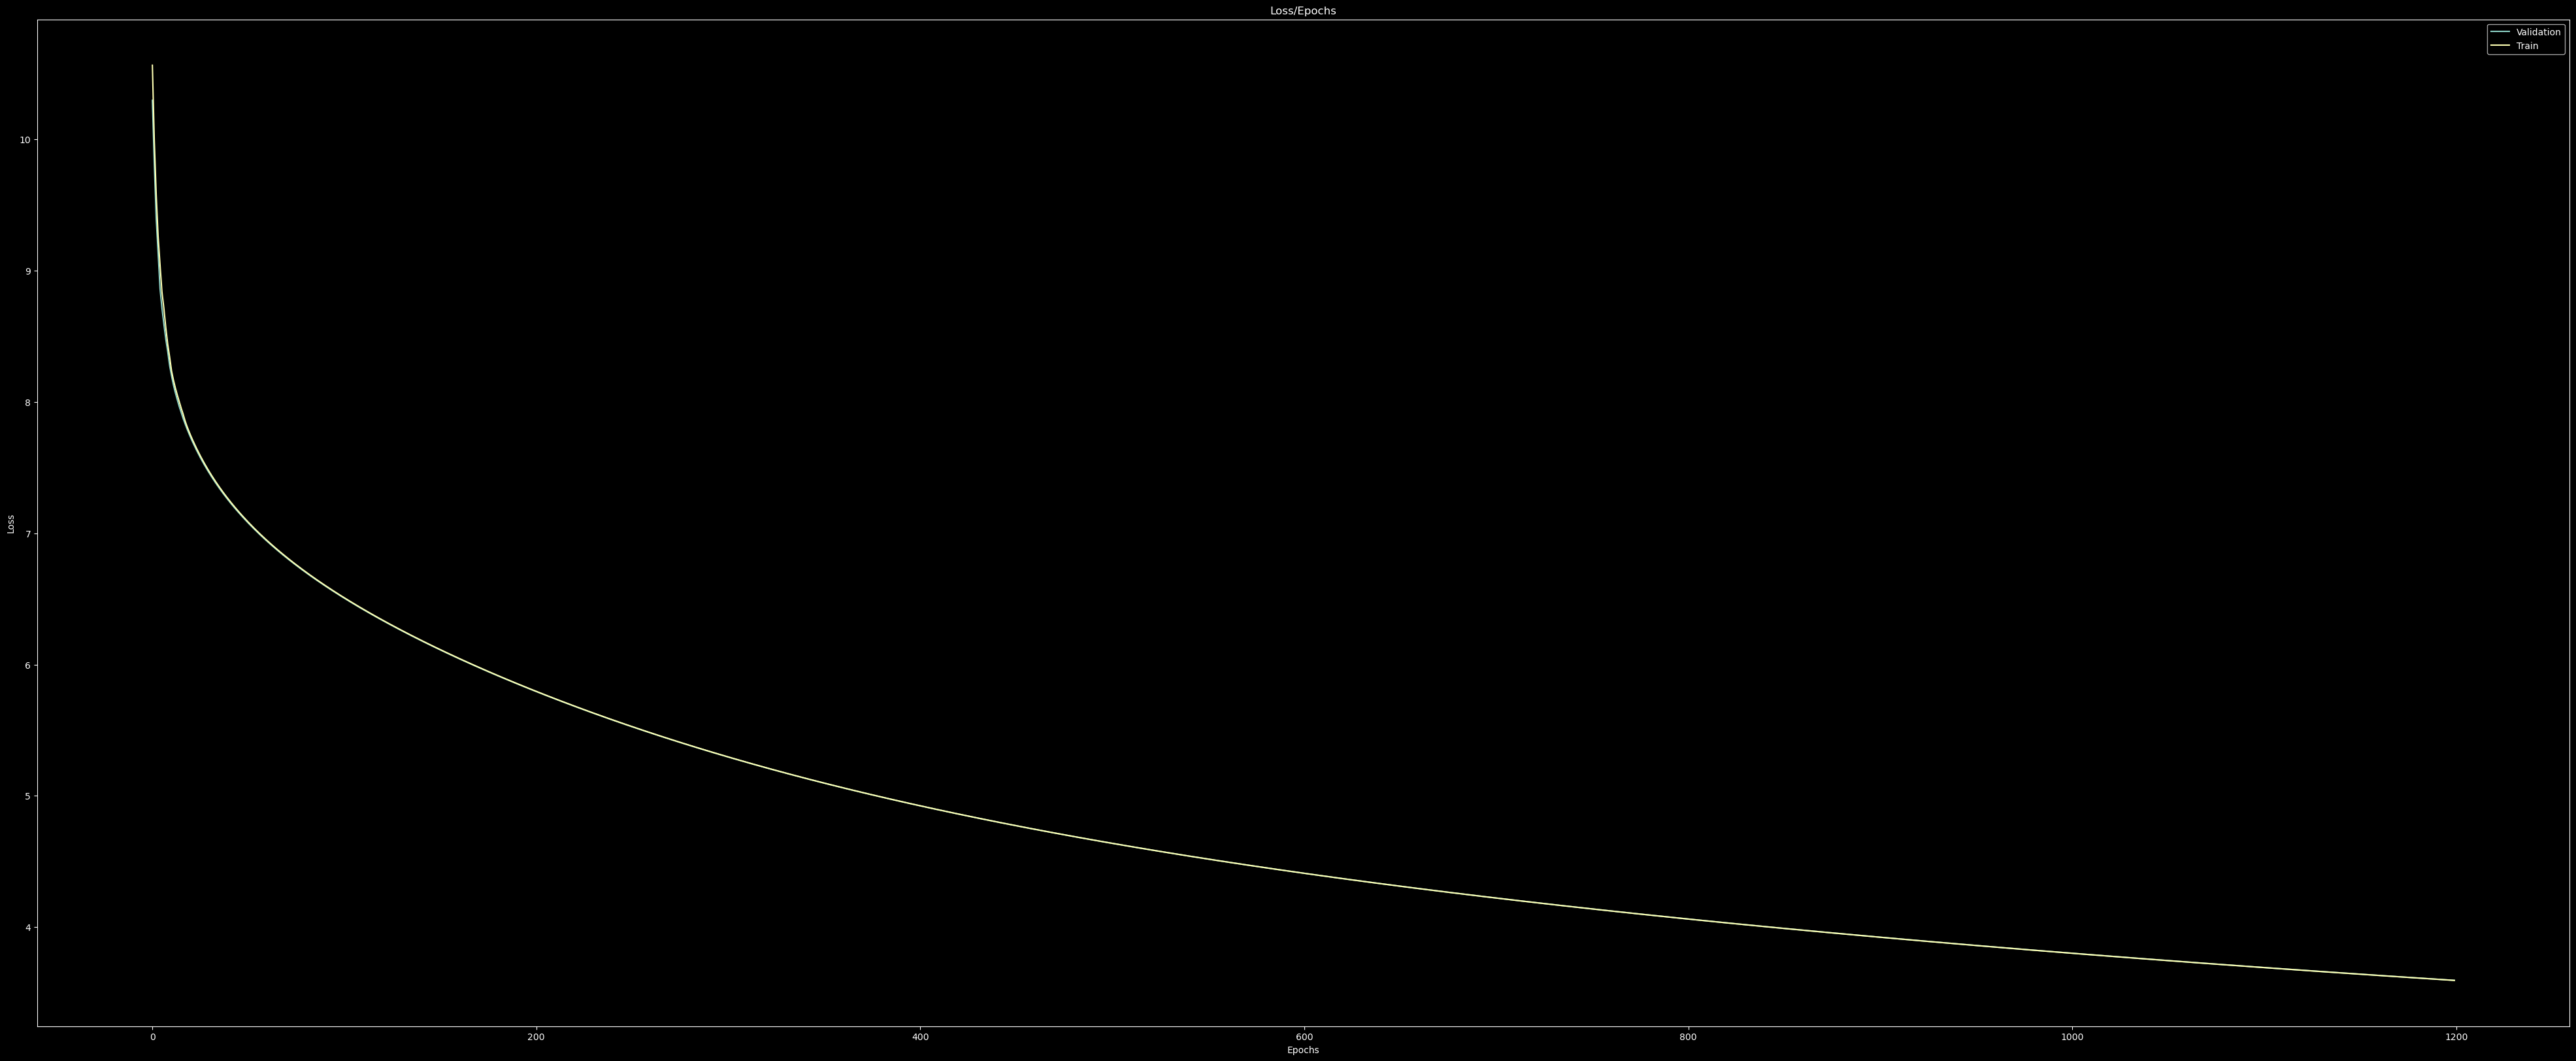

NN with 177 and <function tanh at 0x70dc15647eb0>
Last epoch train error 3.594189167022705
Last epoch validation error 3.5946755409240723


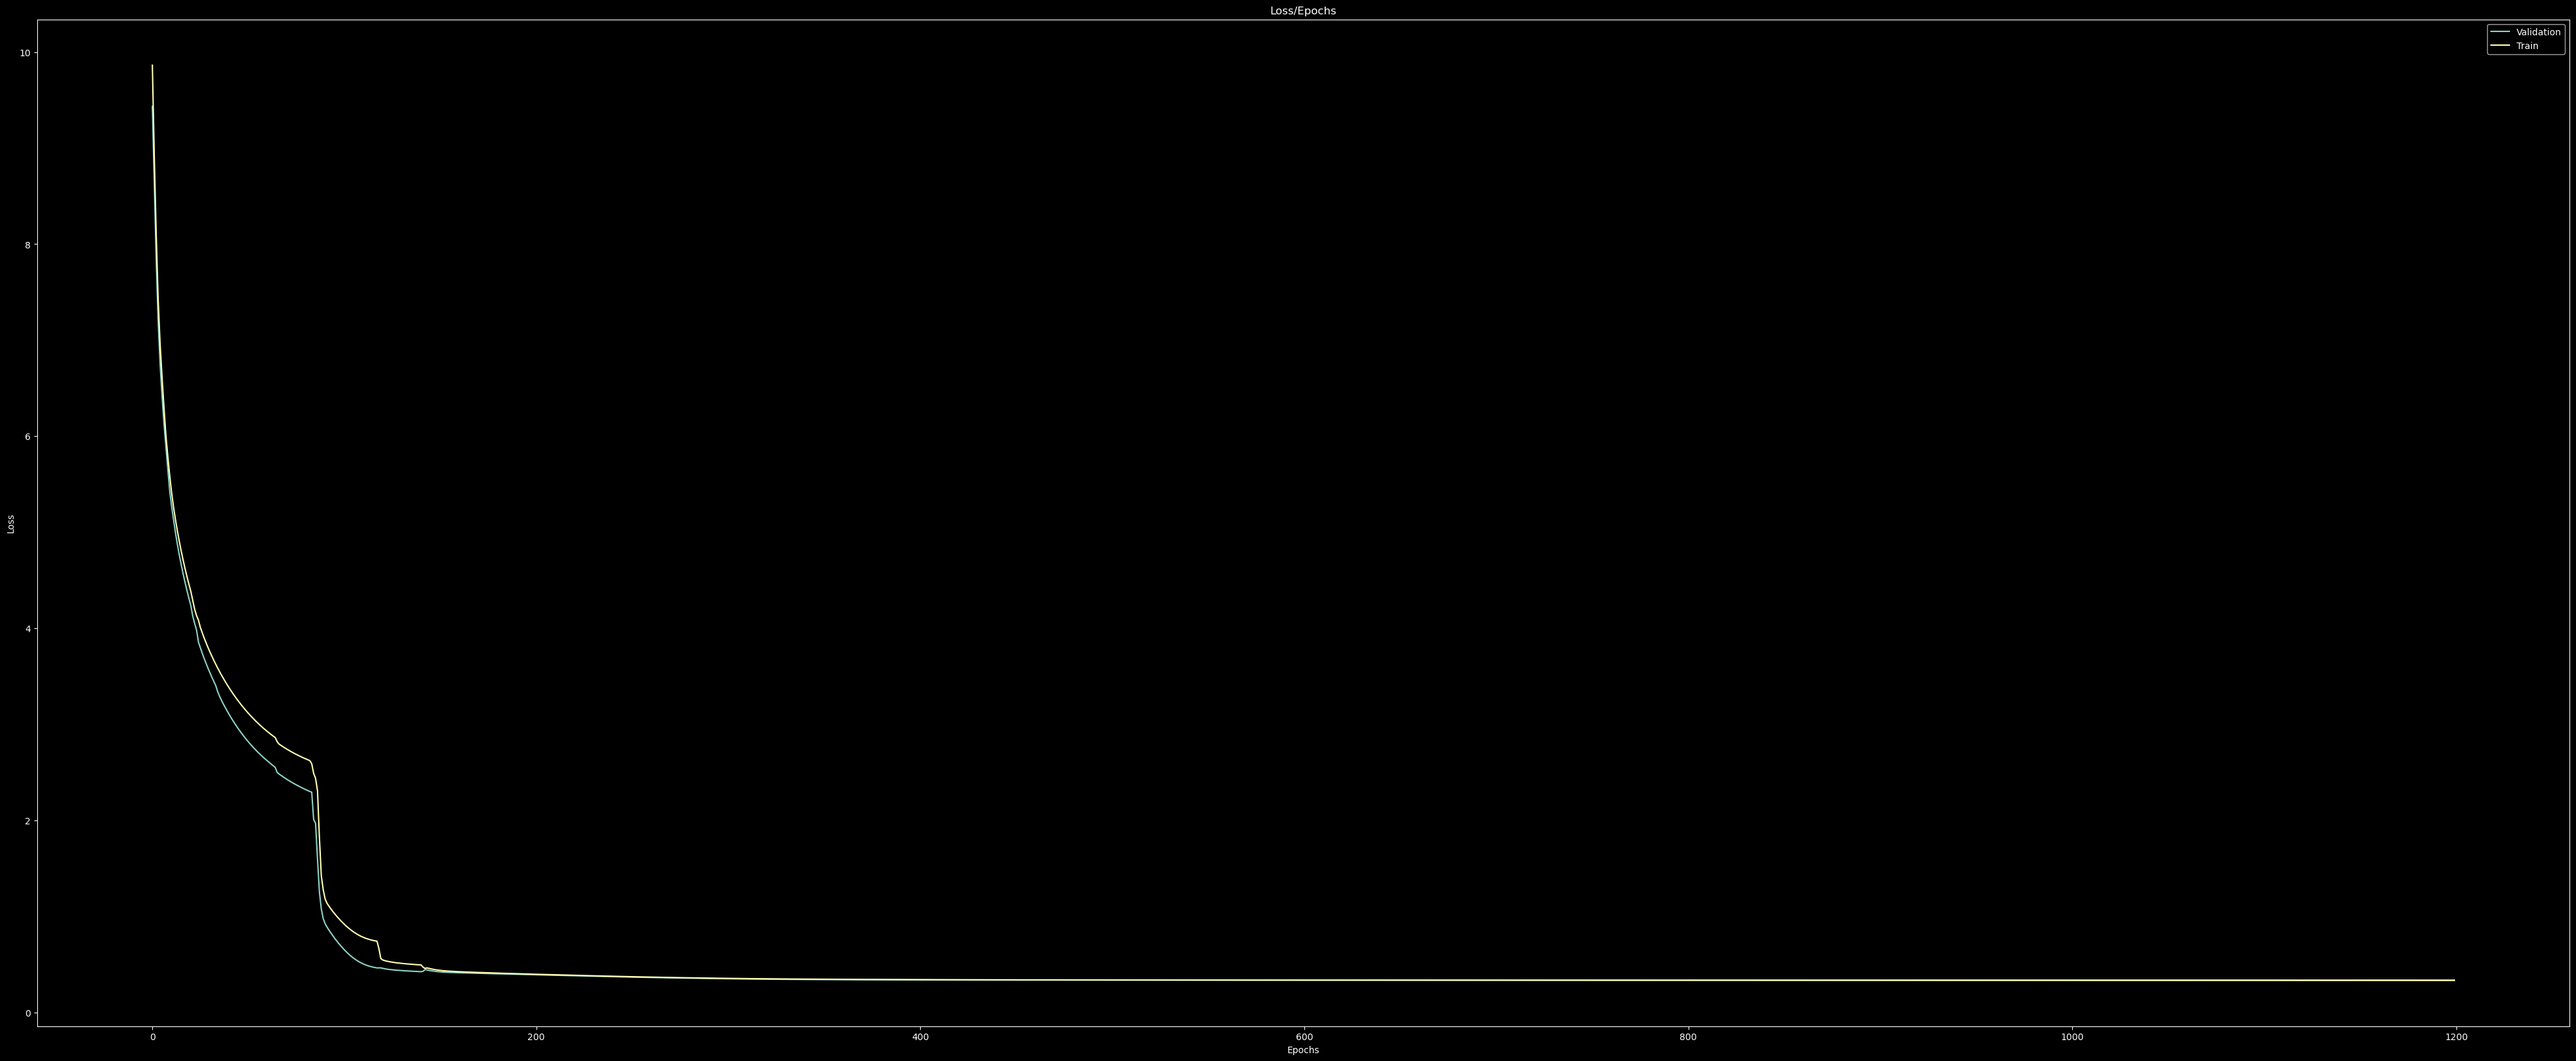

NN with 177 and <function leaky_relu at 0x70dc157863b0>
Last epoch train error 0.33525002002716064
Last epoch validation error 0.3385353982448578


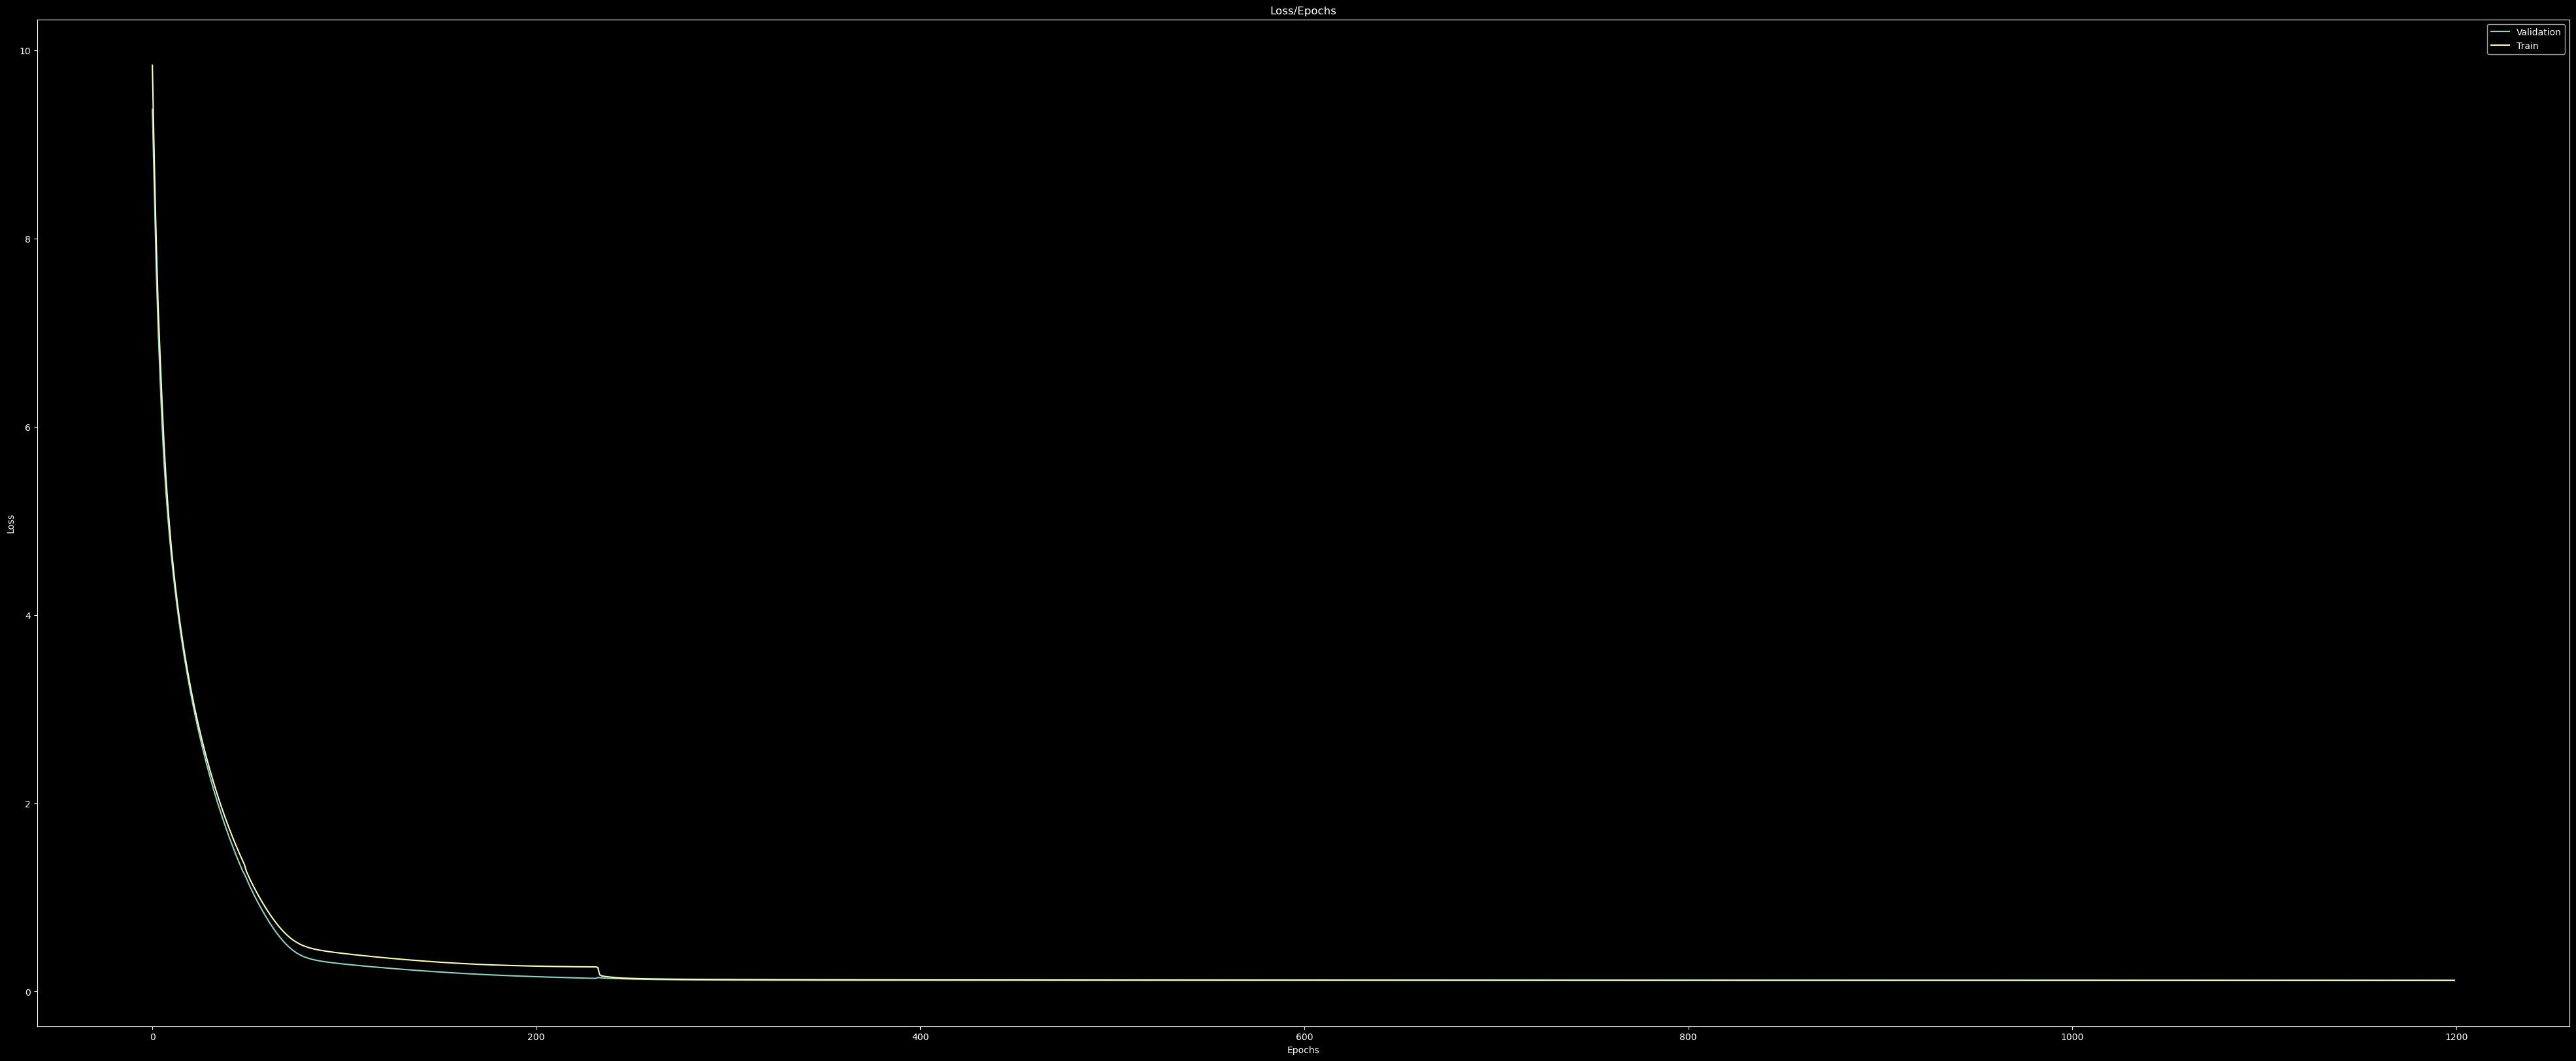

NN with 177 and <function relu at 0x70dc15bf7d00>
Last epoch train error 0.11643069982528687
Last epoch validation error 0.11603402346372604


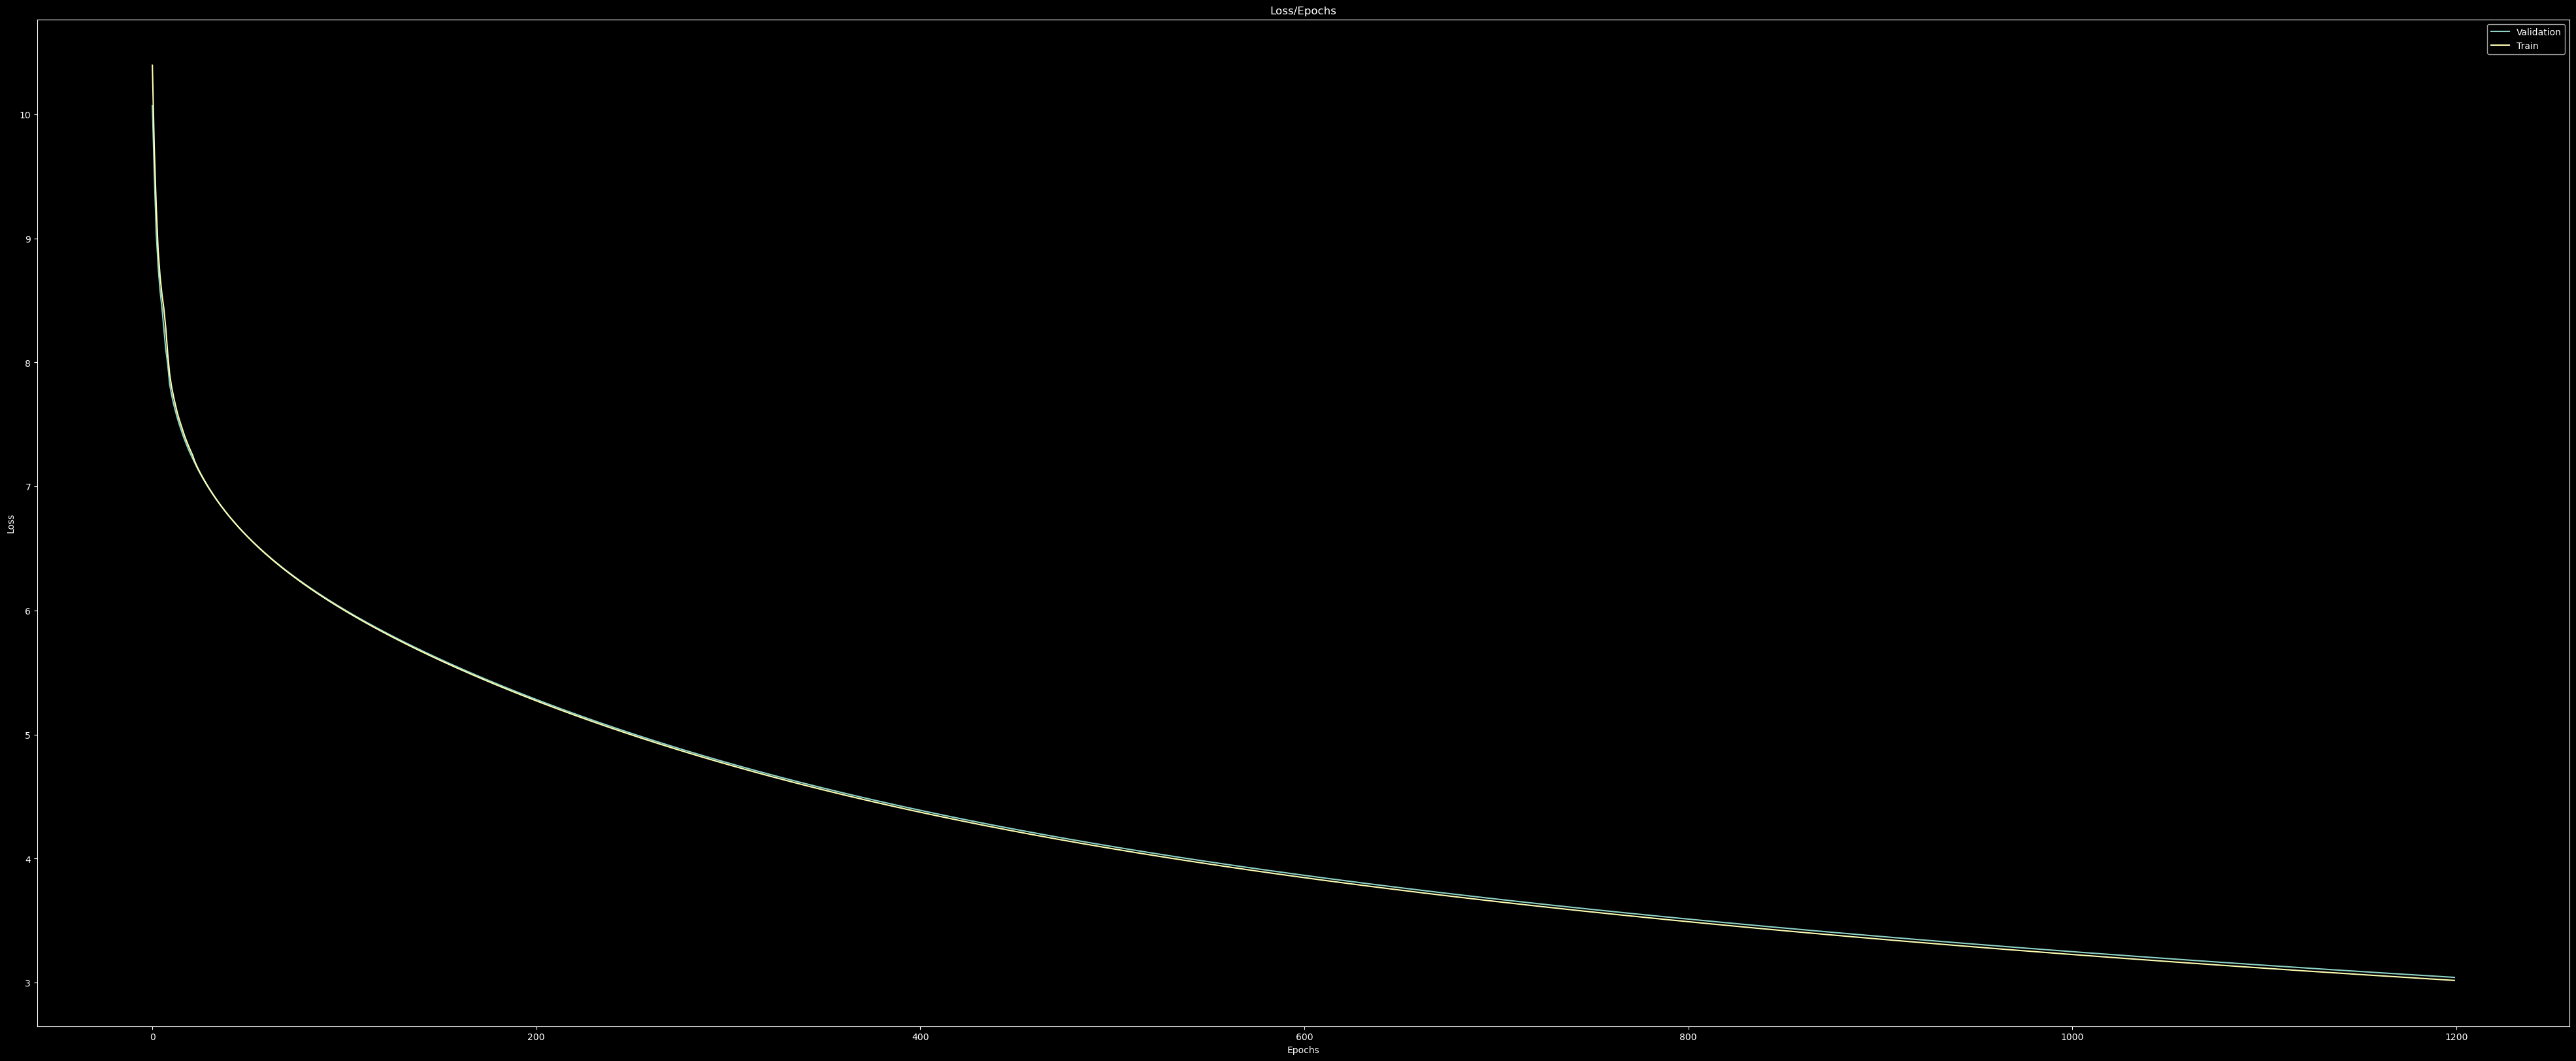

NN with 316 and <function tanh at 0x70dc15647eb0>
Last epoch train error 3.0181050300598145
Last epoch validation error 3.042634963989258


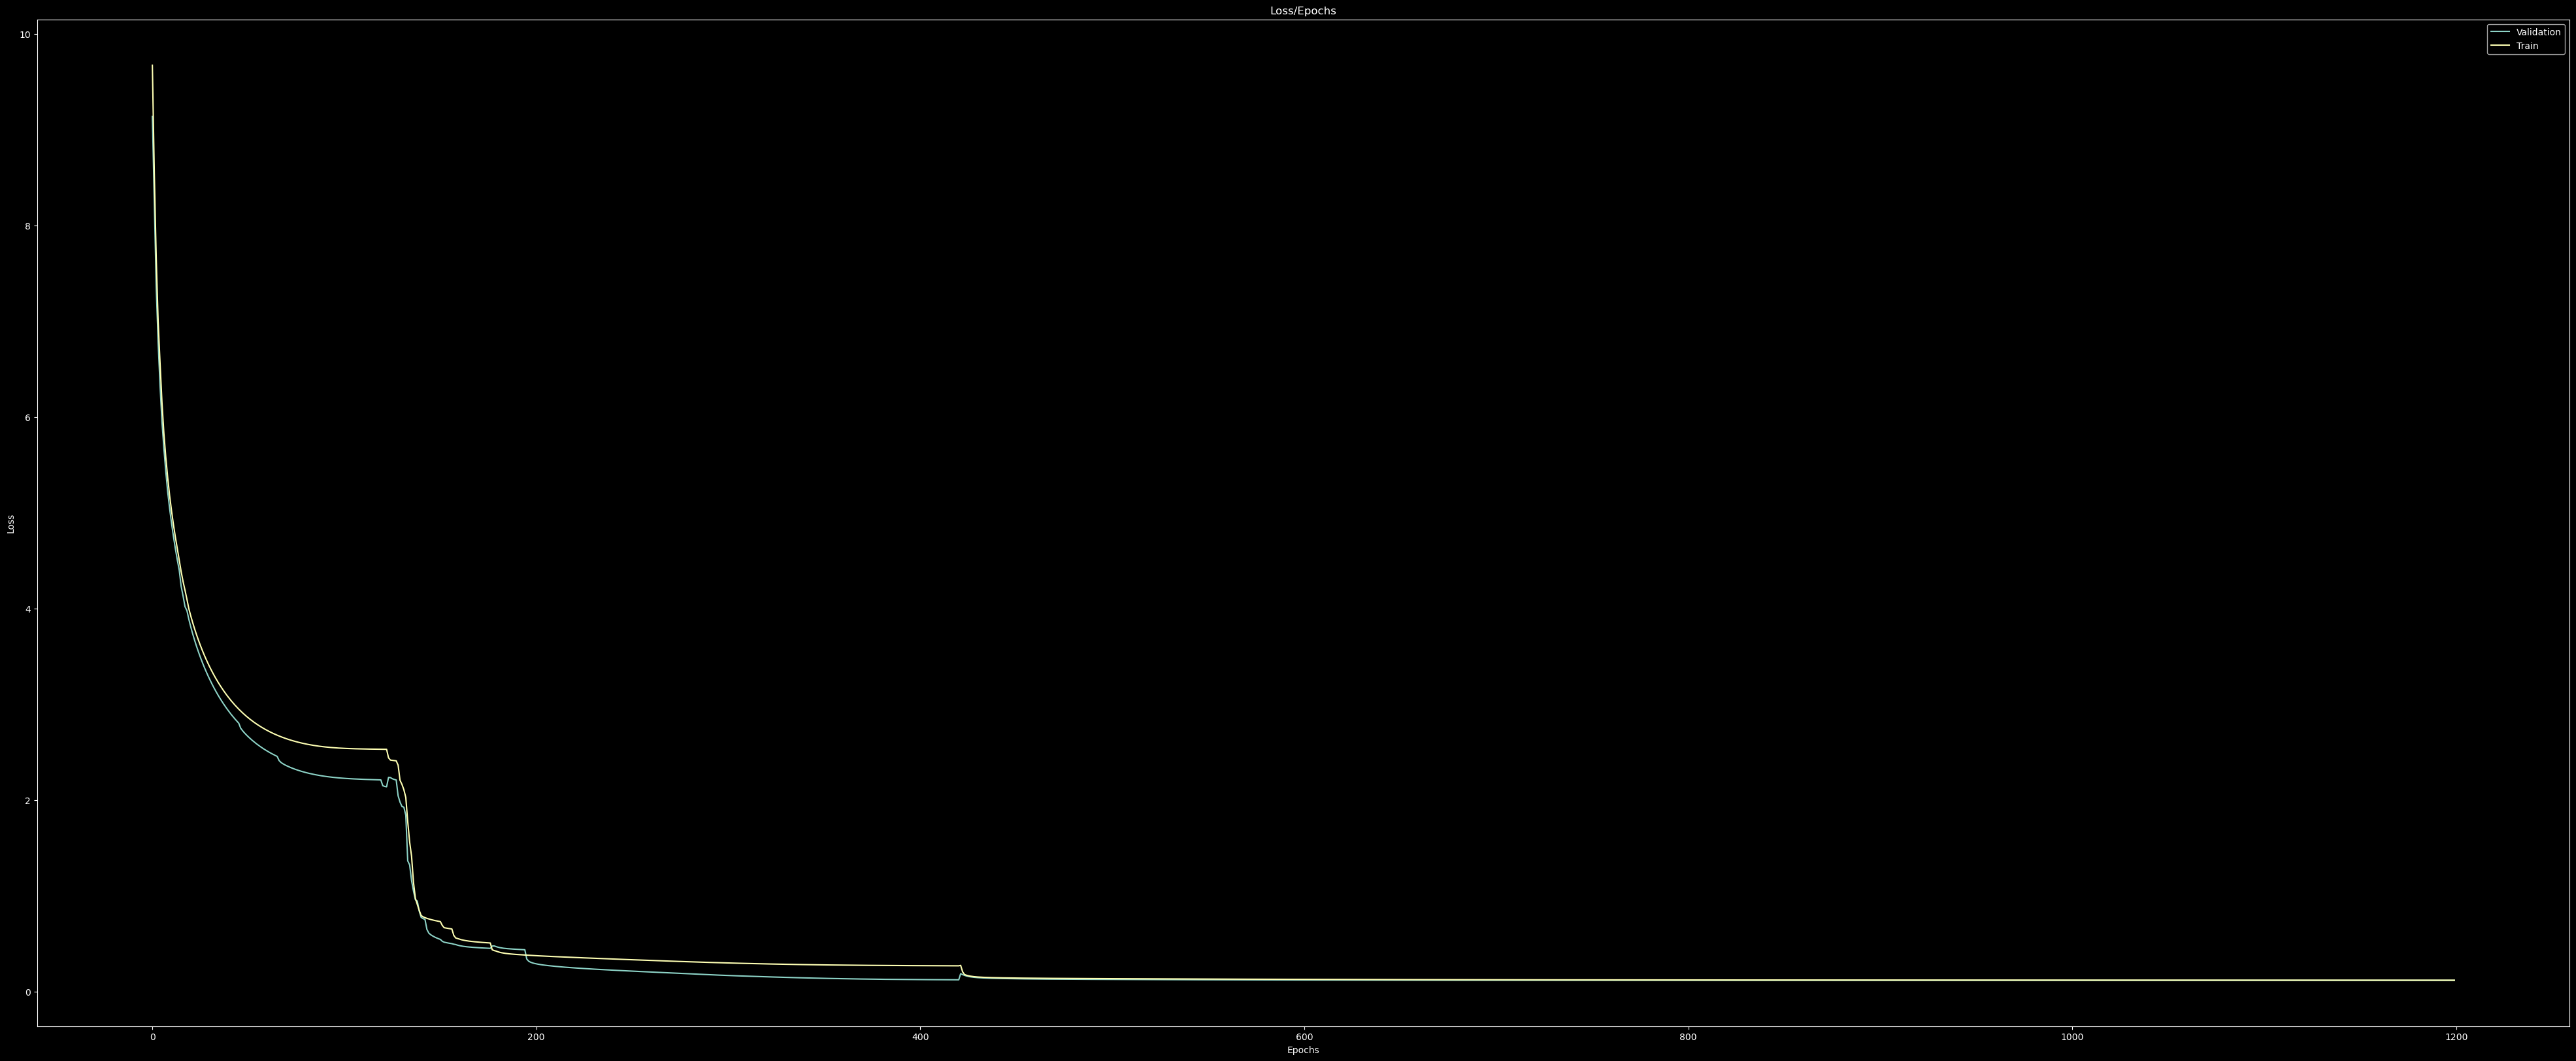

NN with 316 and <function leaky_relu at 0x70dc157863b0>
Last epoch train error 0.11765129864215851
Last epoch validation error 0.11530382186174393


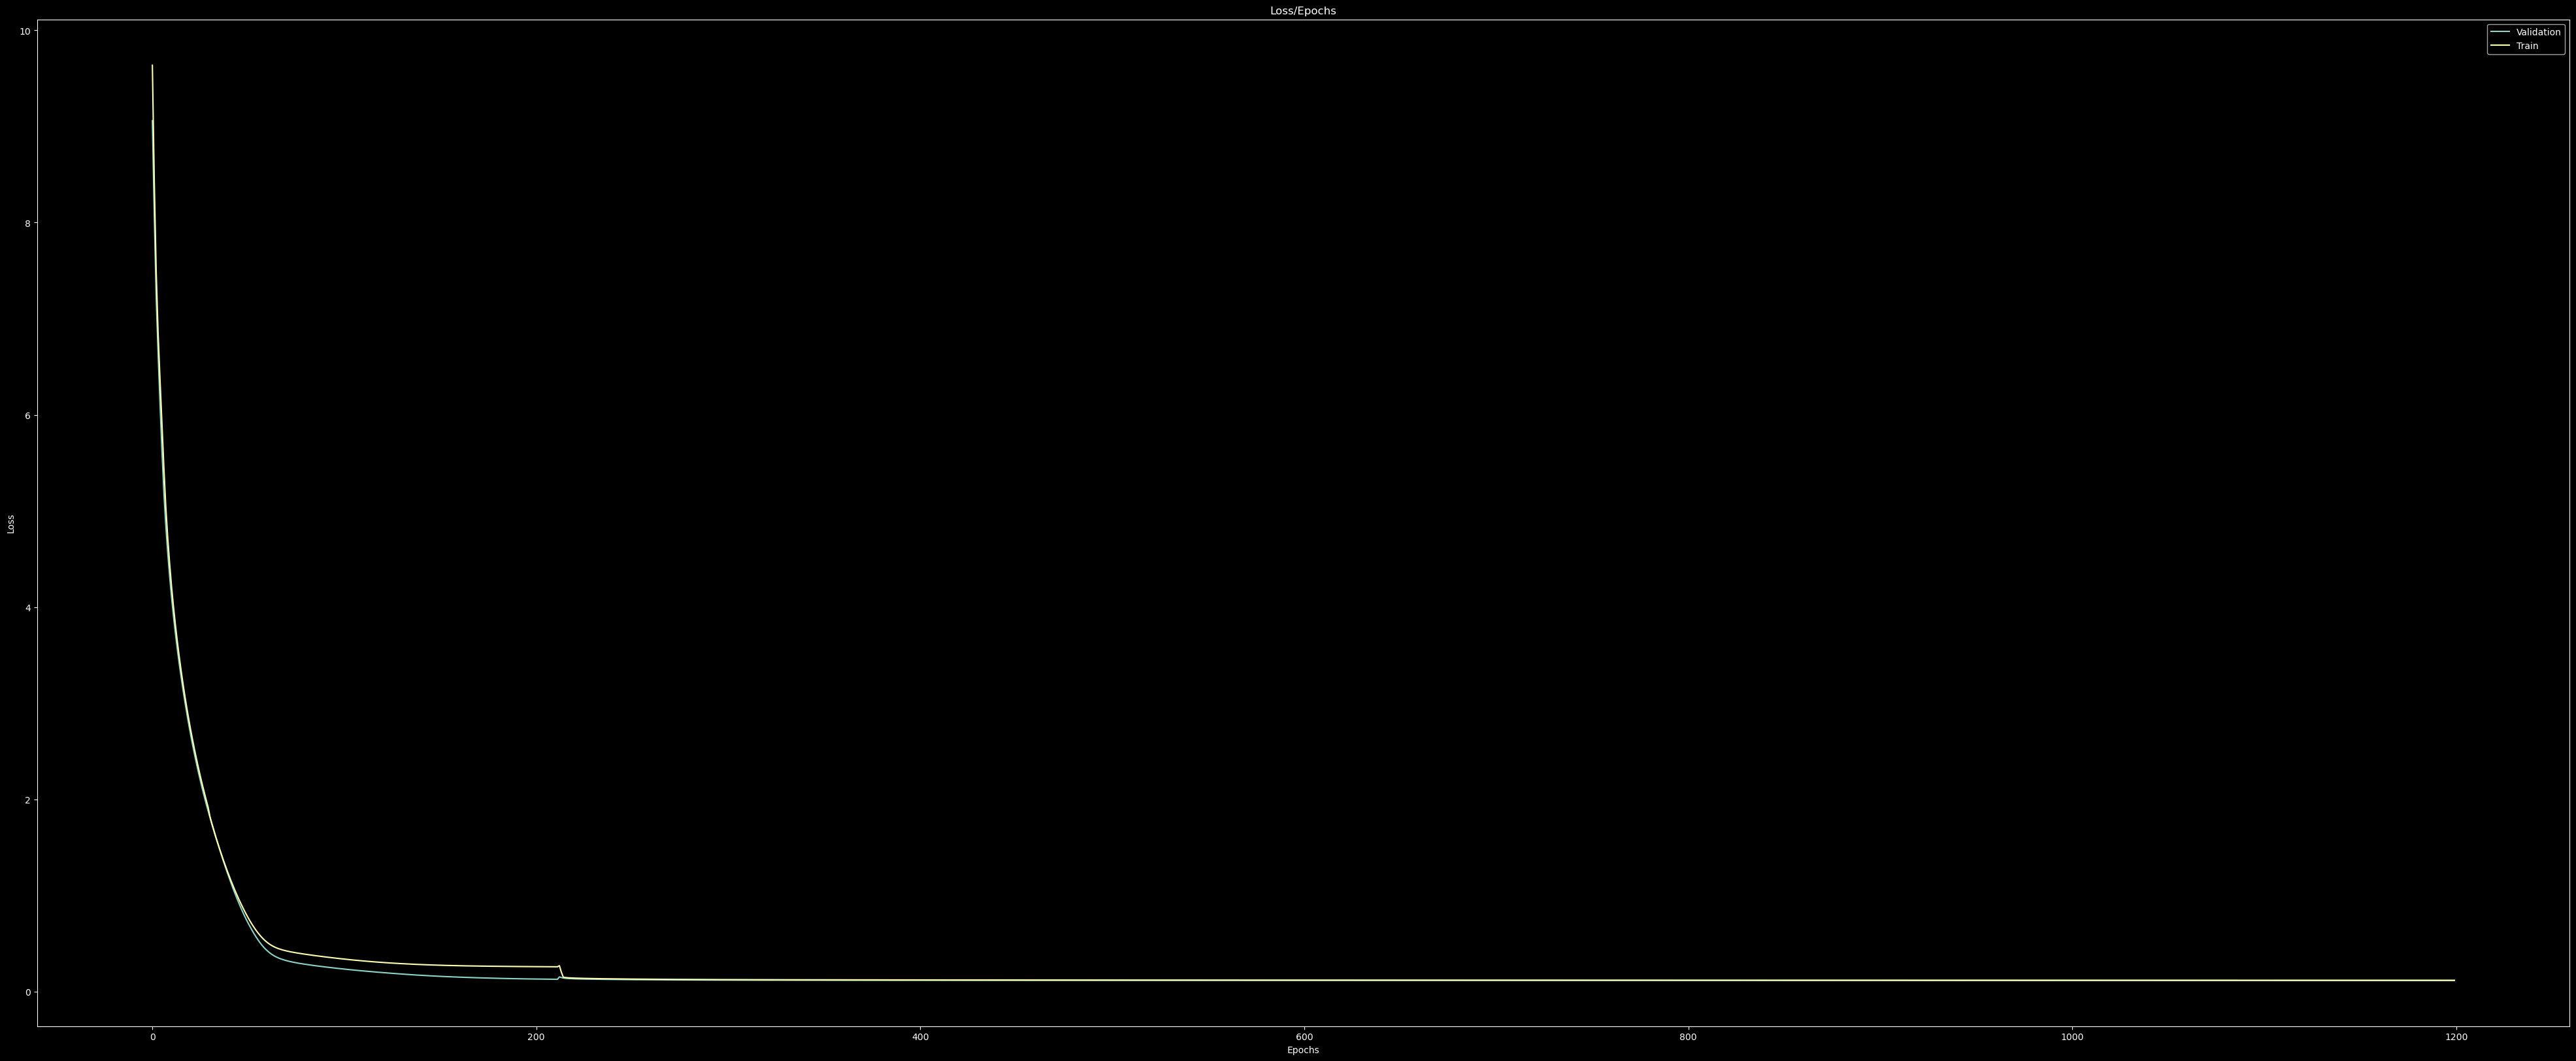

NN with 316 and <function relu at 0x70dc15bf7d00>
Last epoch train error 0.11642294377088547
Last epoch validation error 0.11599792540073395


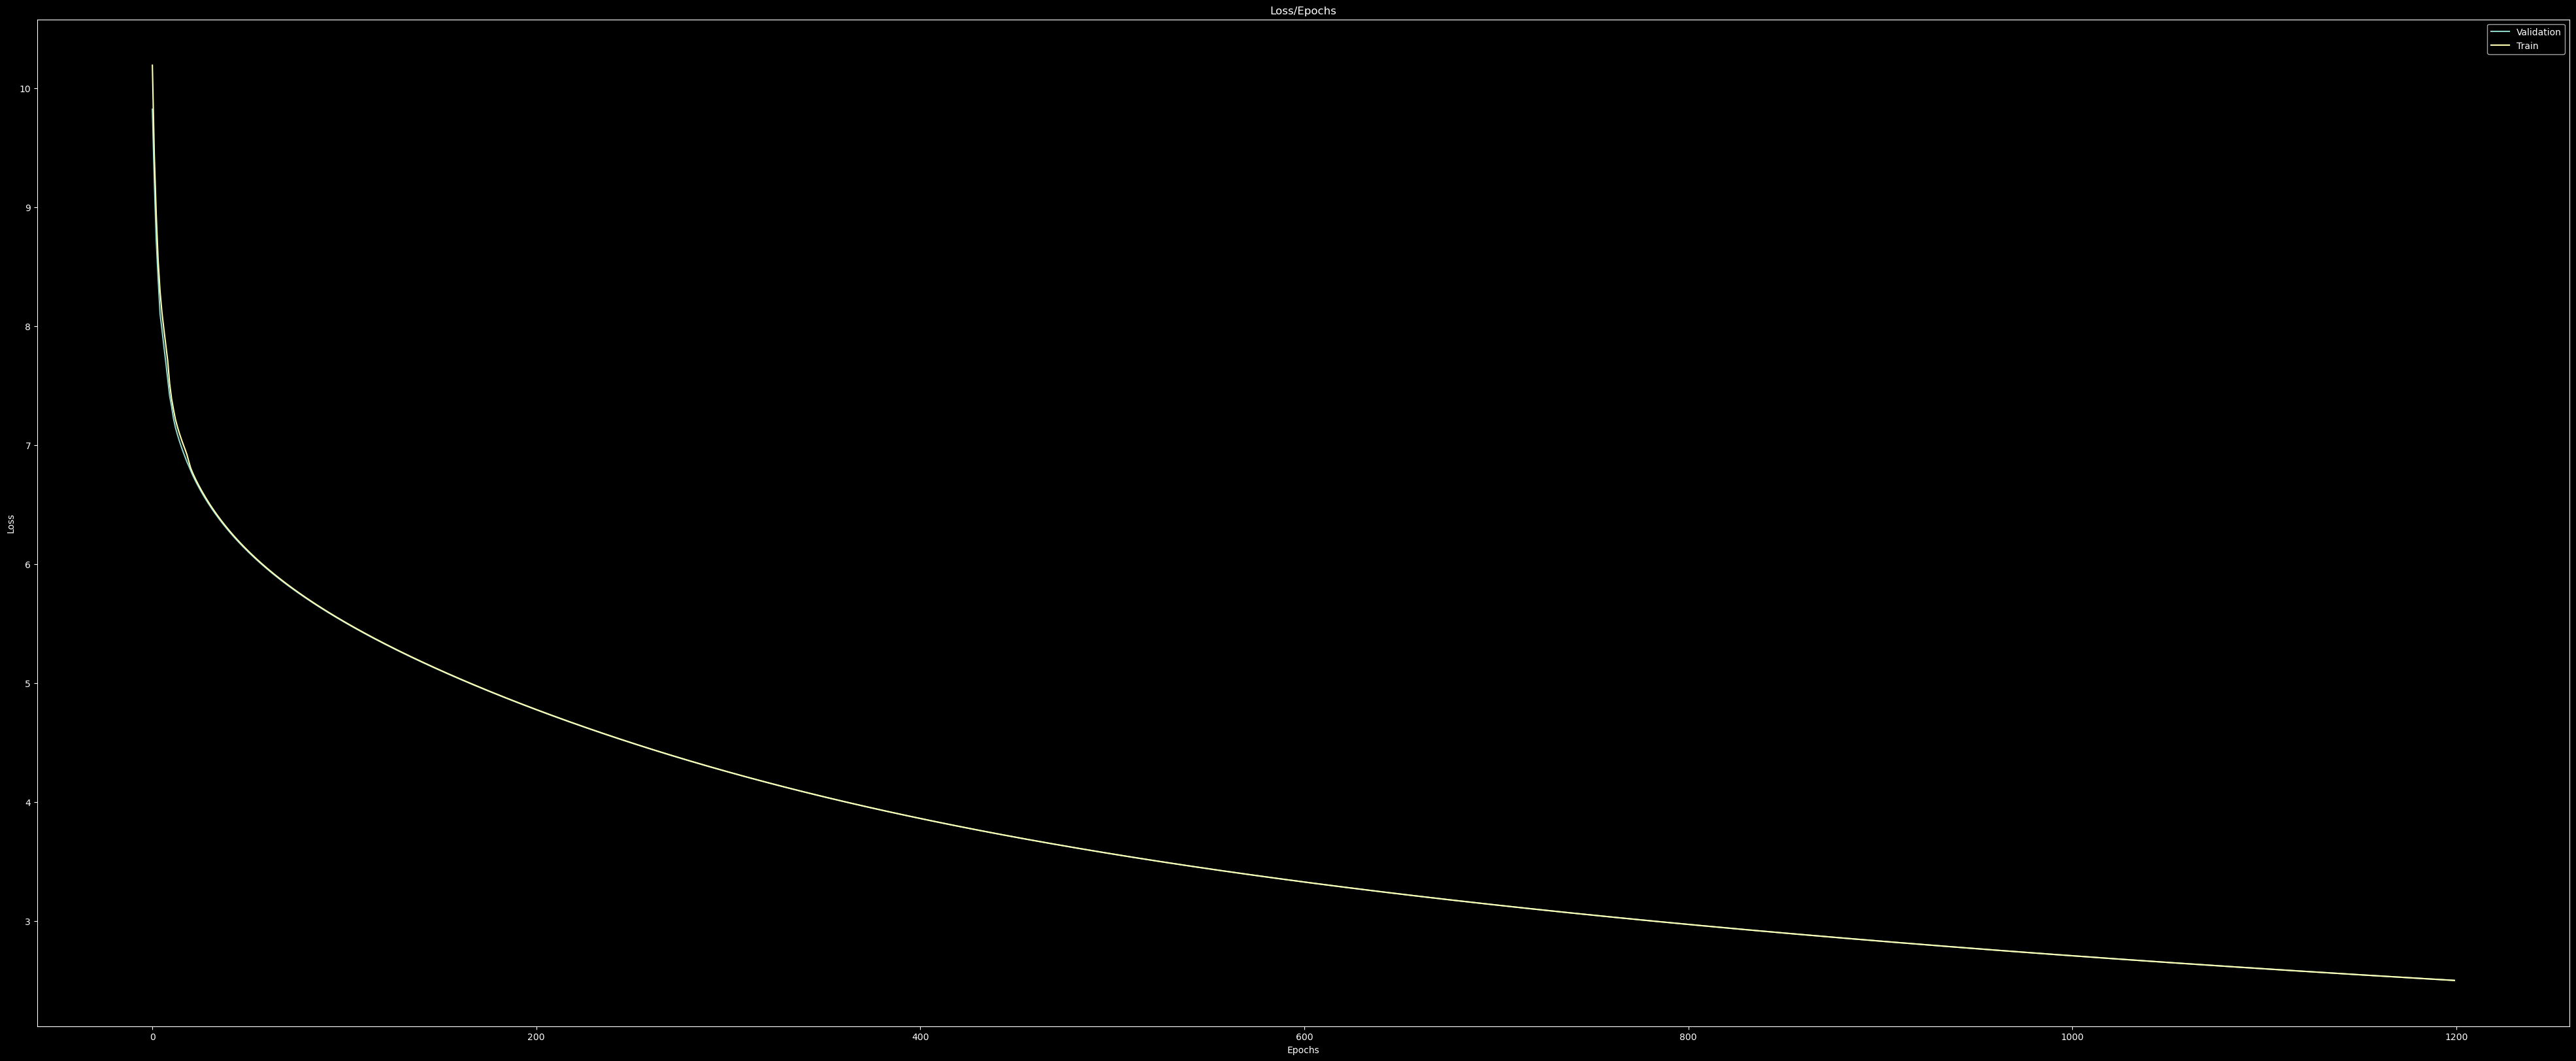

NN with 562 and <function tanh at 0x70dc15647eb0>
Last epoch train error 2.4993033409118652
Last epoch validation error 2.499288320541382


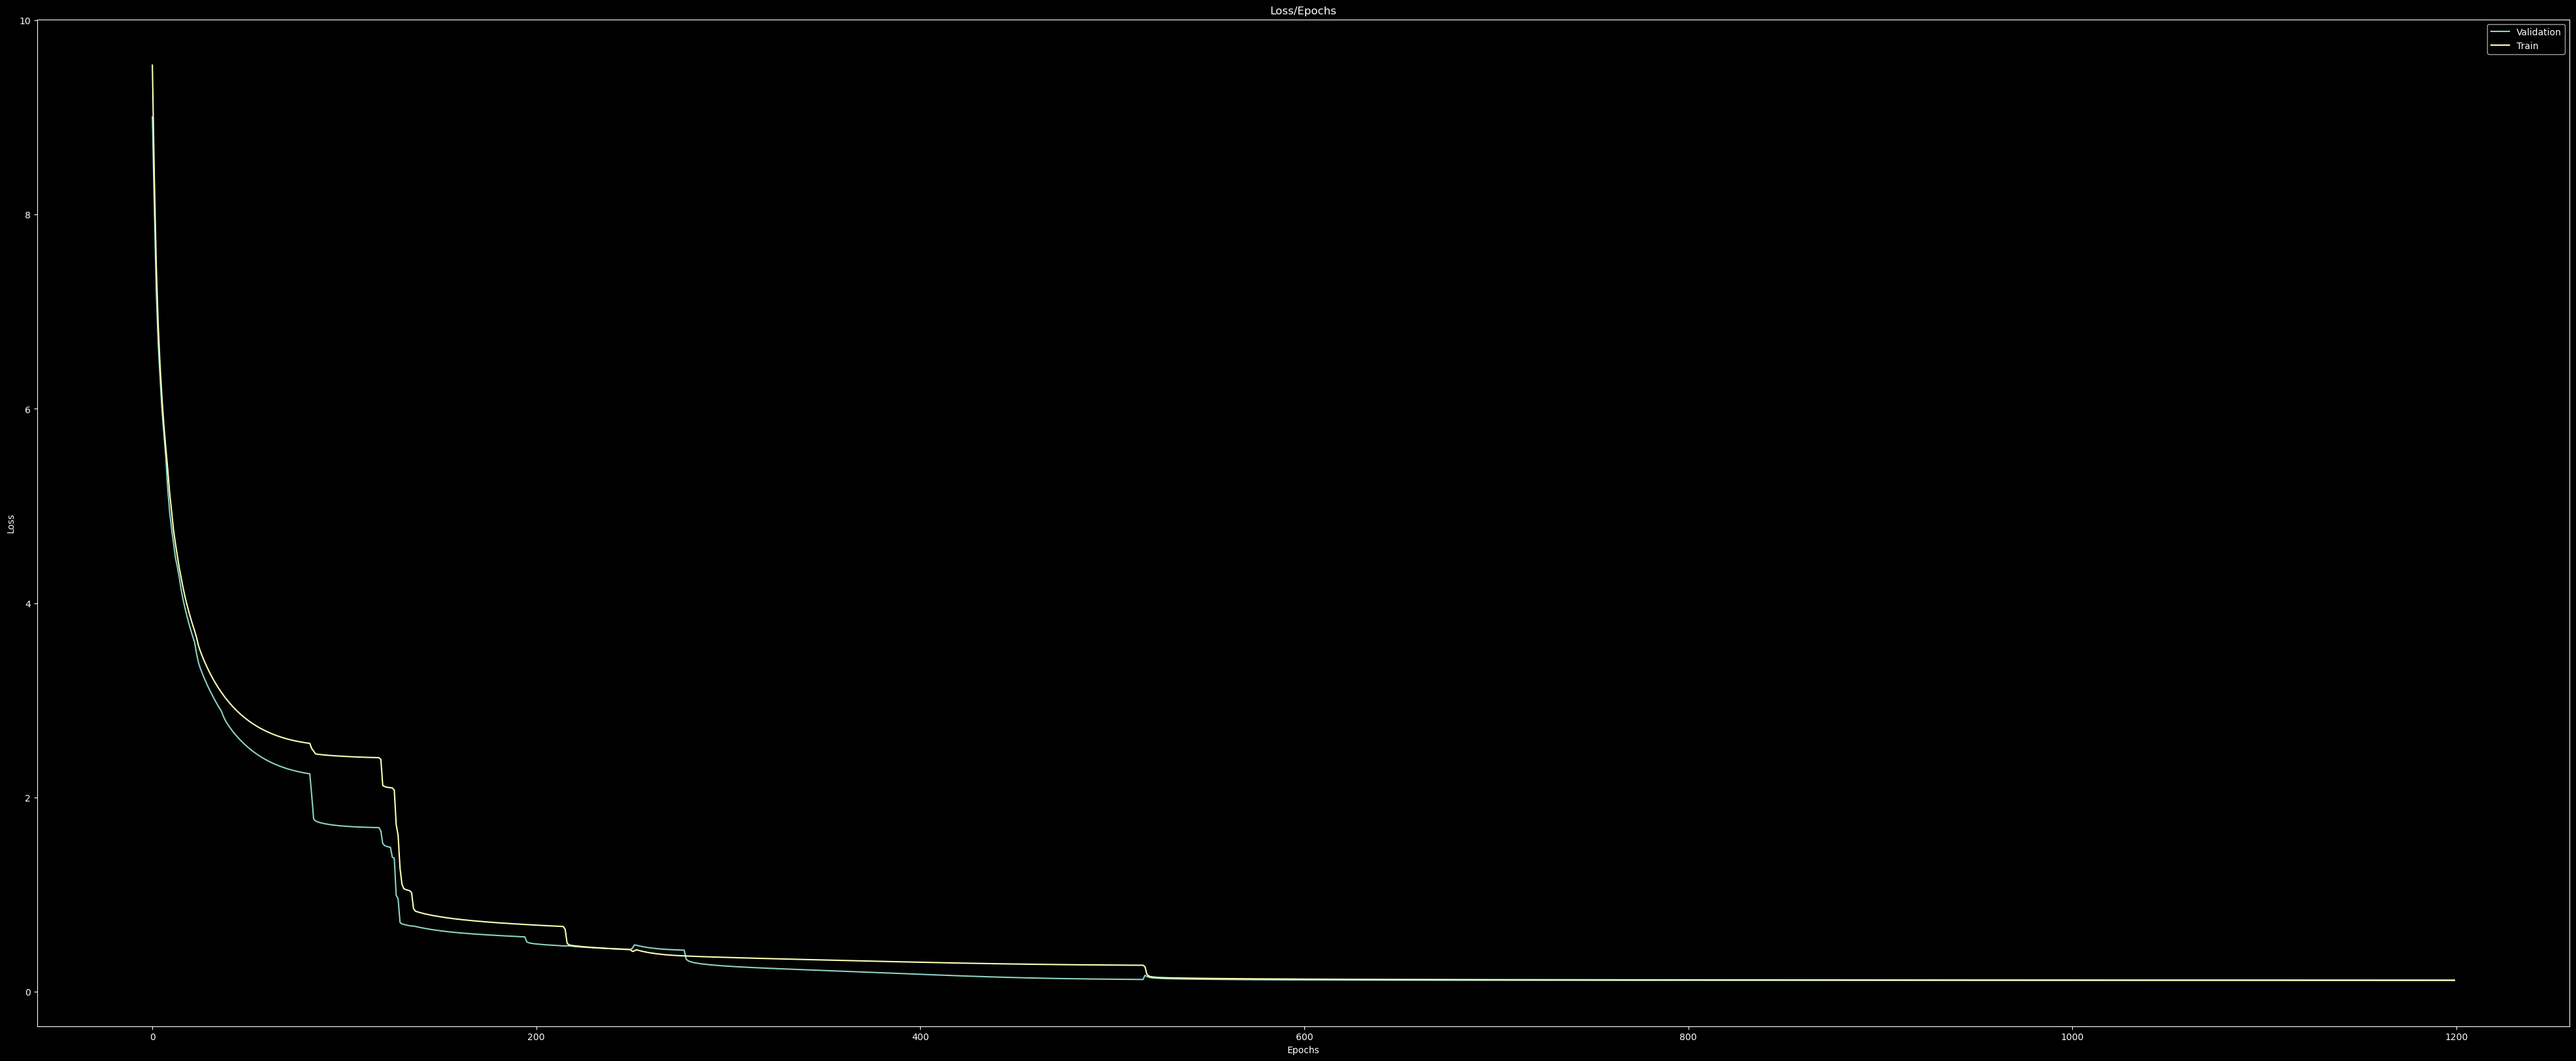

NN with 562 and <function leaky_relu at 0x70dc157863b0>
Last epoch train error 0.11757005751132965
Last epoch validation error 0.11498104780912399


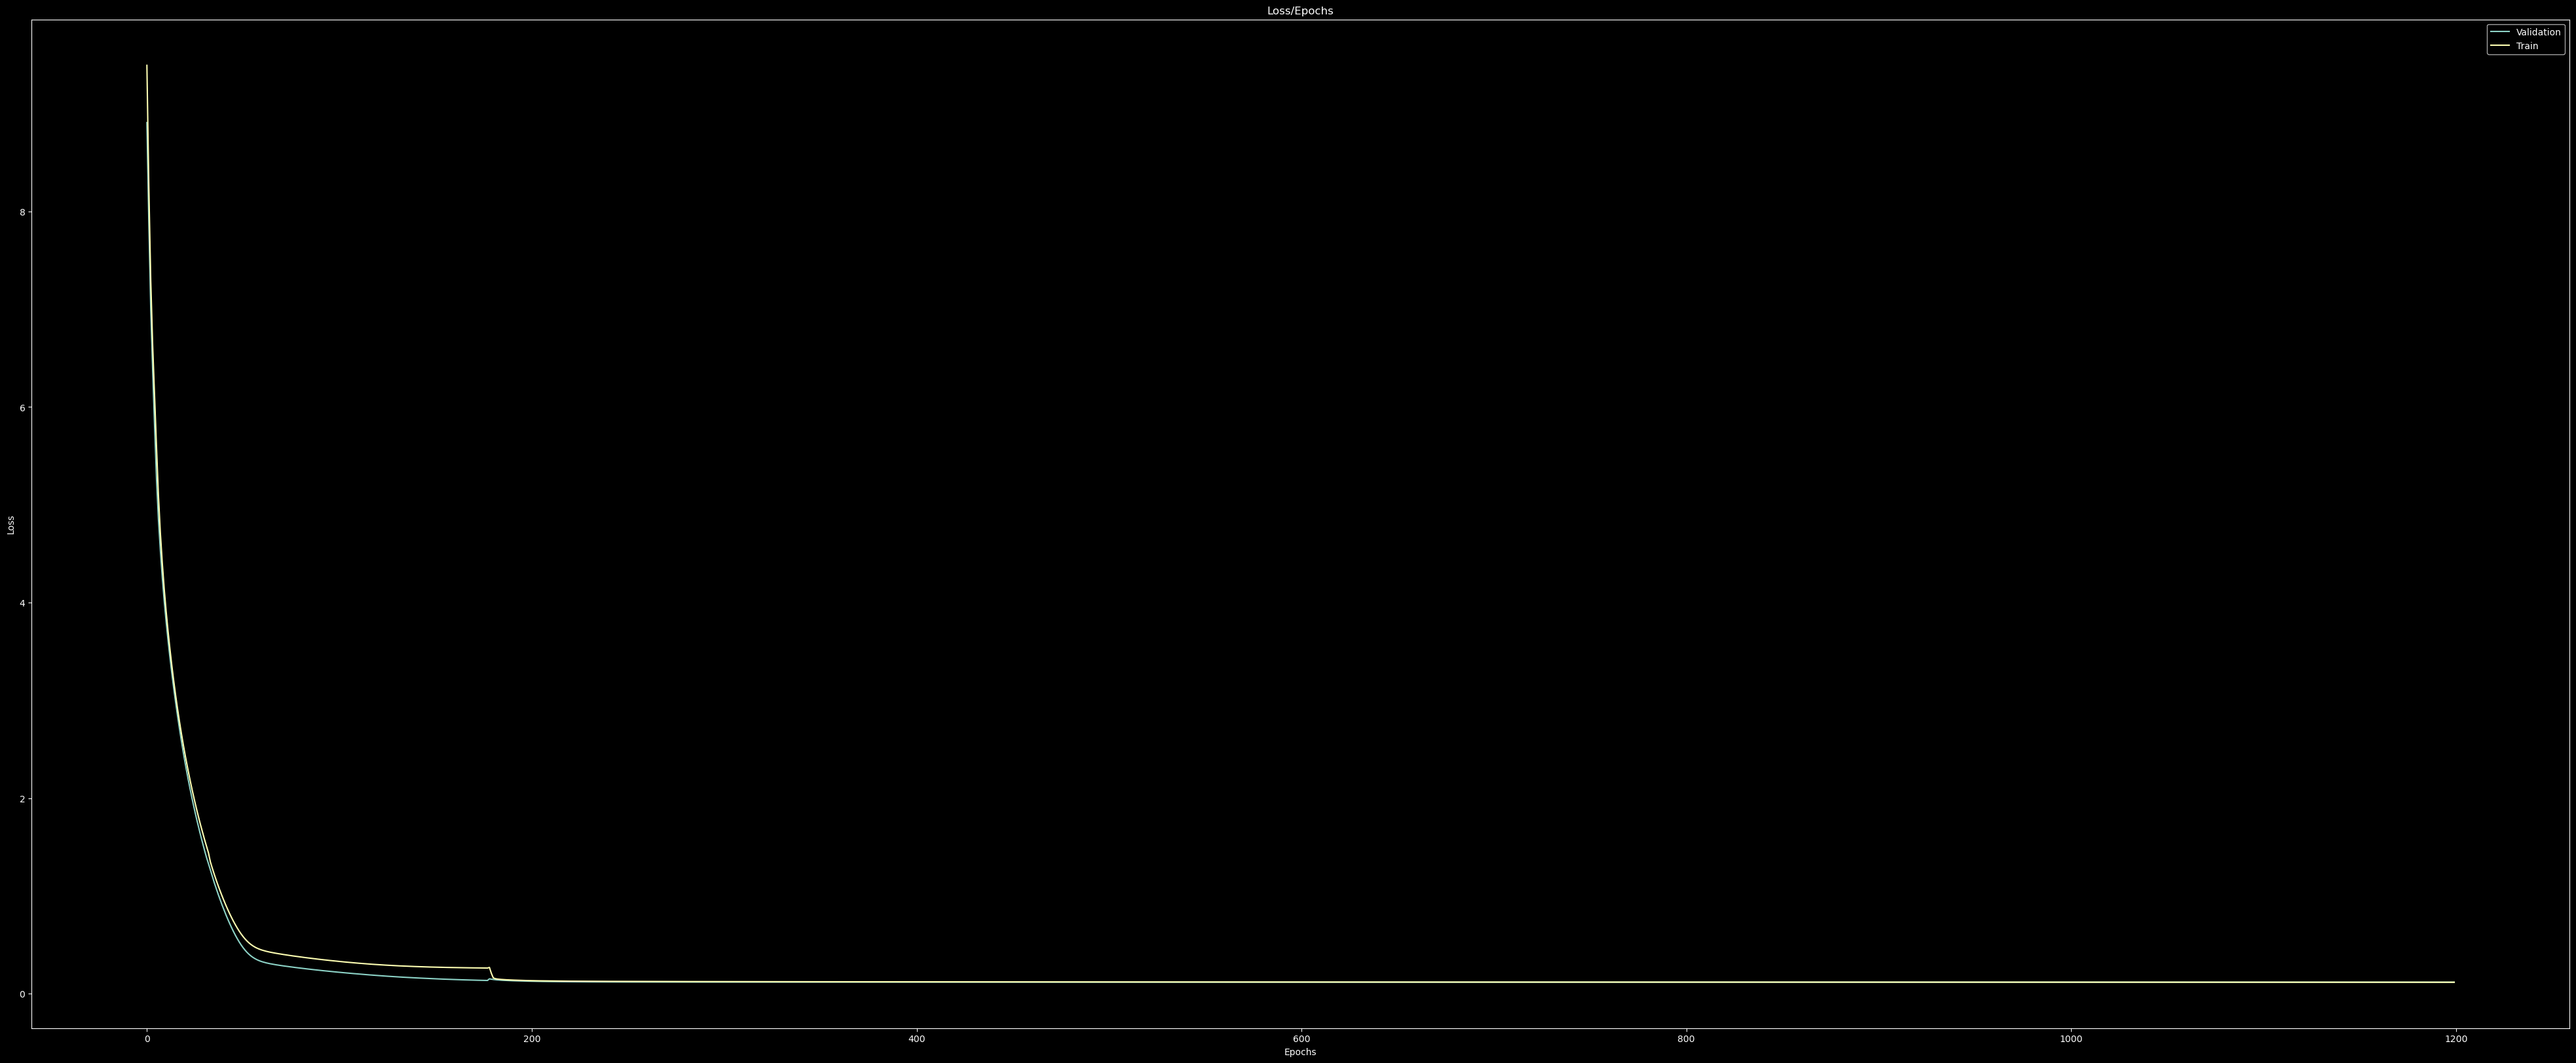

NN with 562 and <function relu at 0x70dc15bf7d00>
Last epoch train error 0.11615756154060364
Last epoch validation error 0.11681405454874039


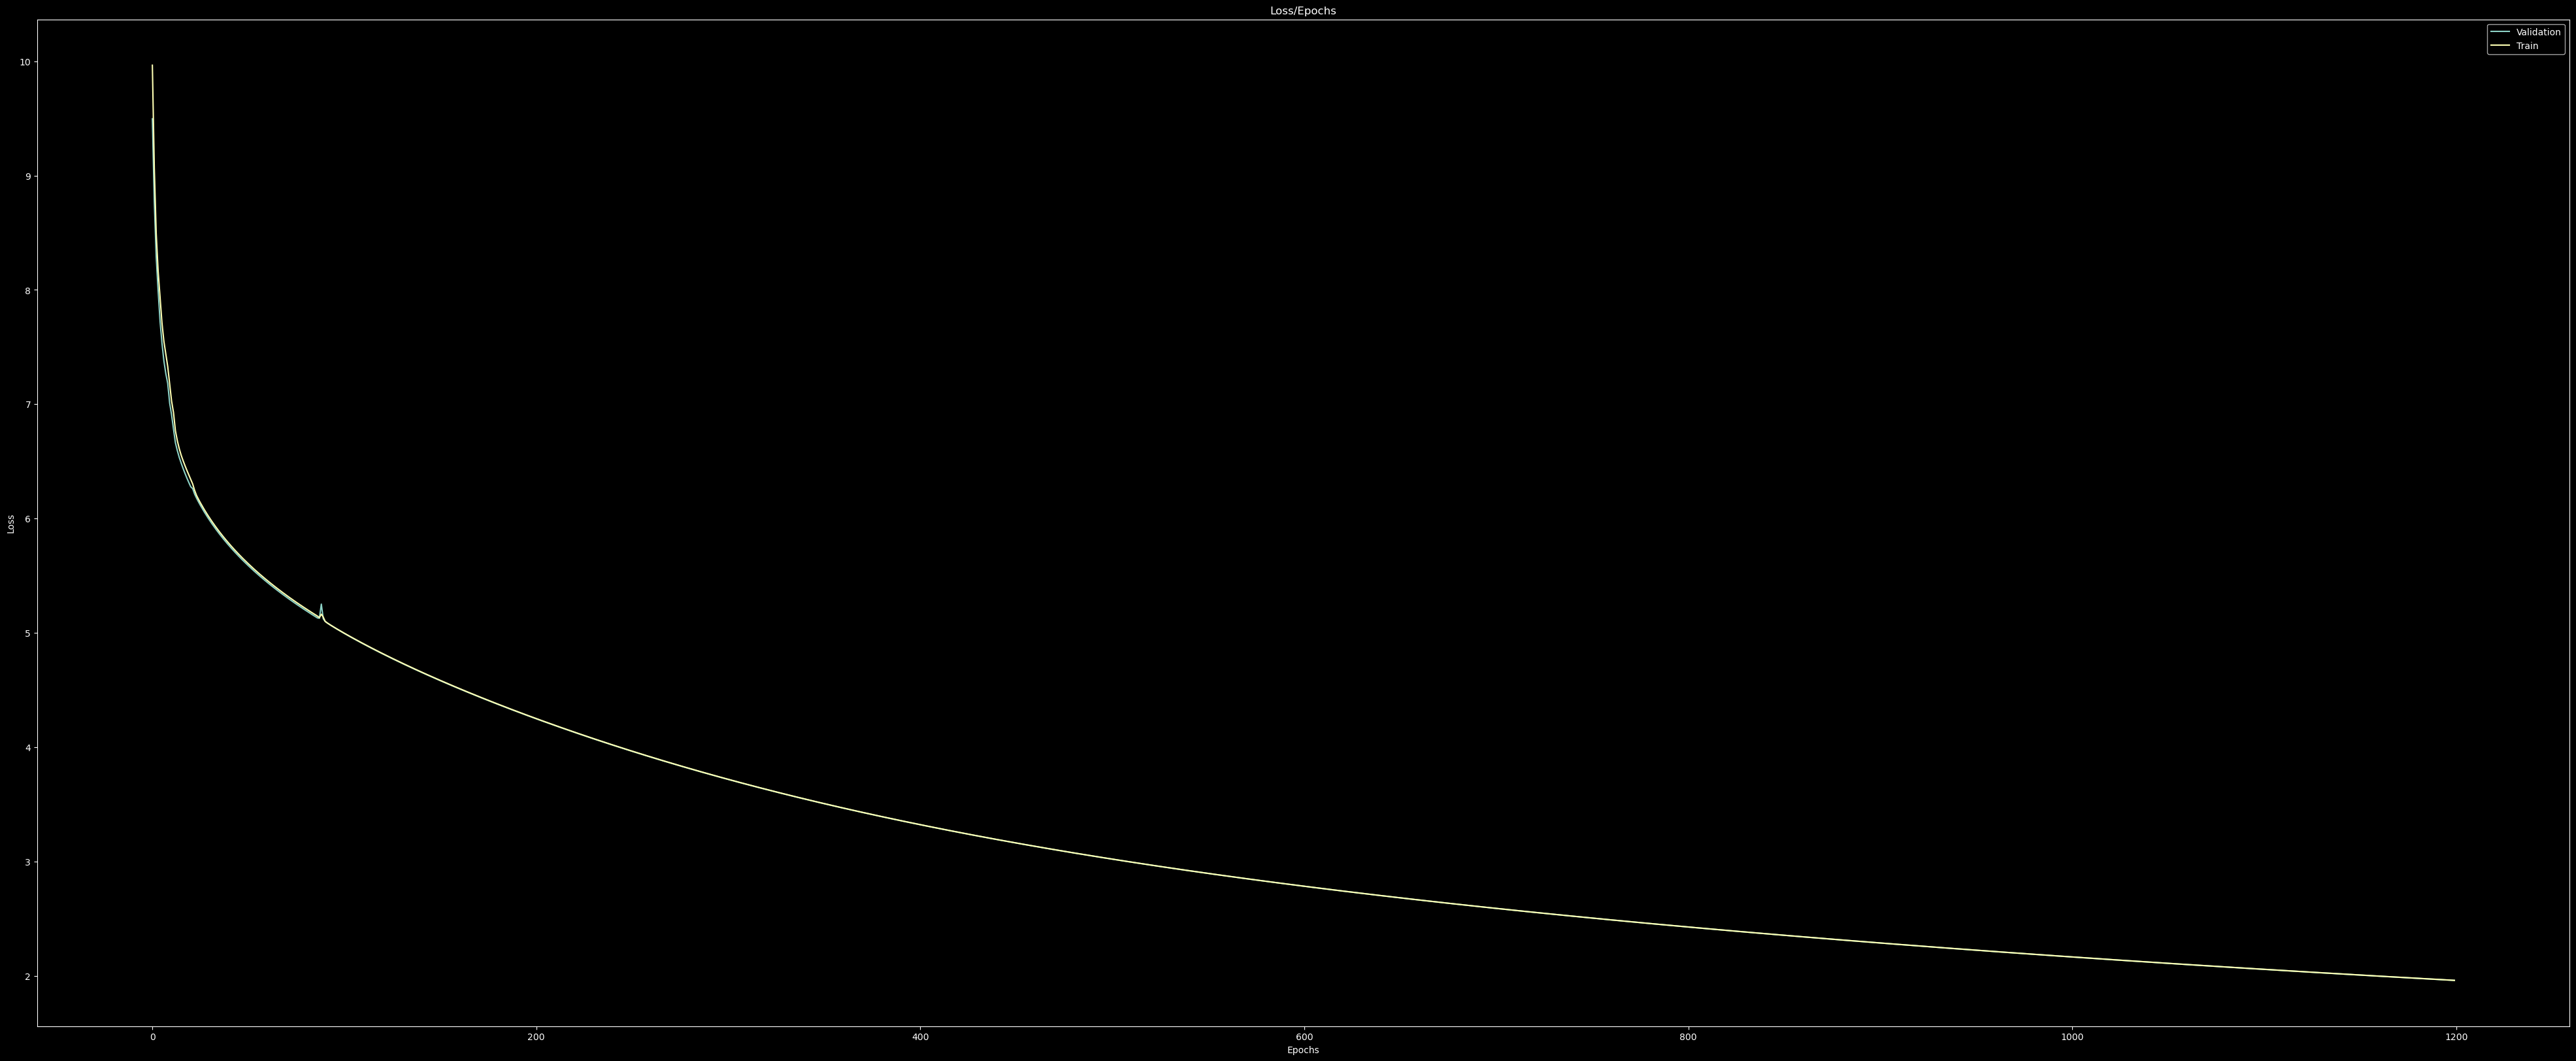

NN with 1000 and <function tanh at 0x70dc15647eb0>
Last epoch train error 1.9607305526733398
Last epoch validation error 1.9600144624710083


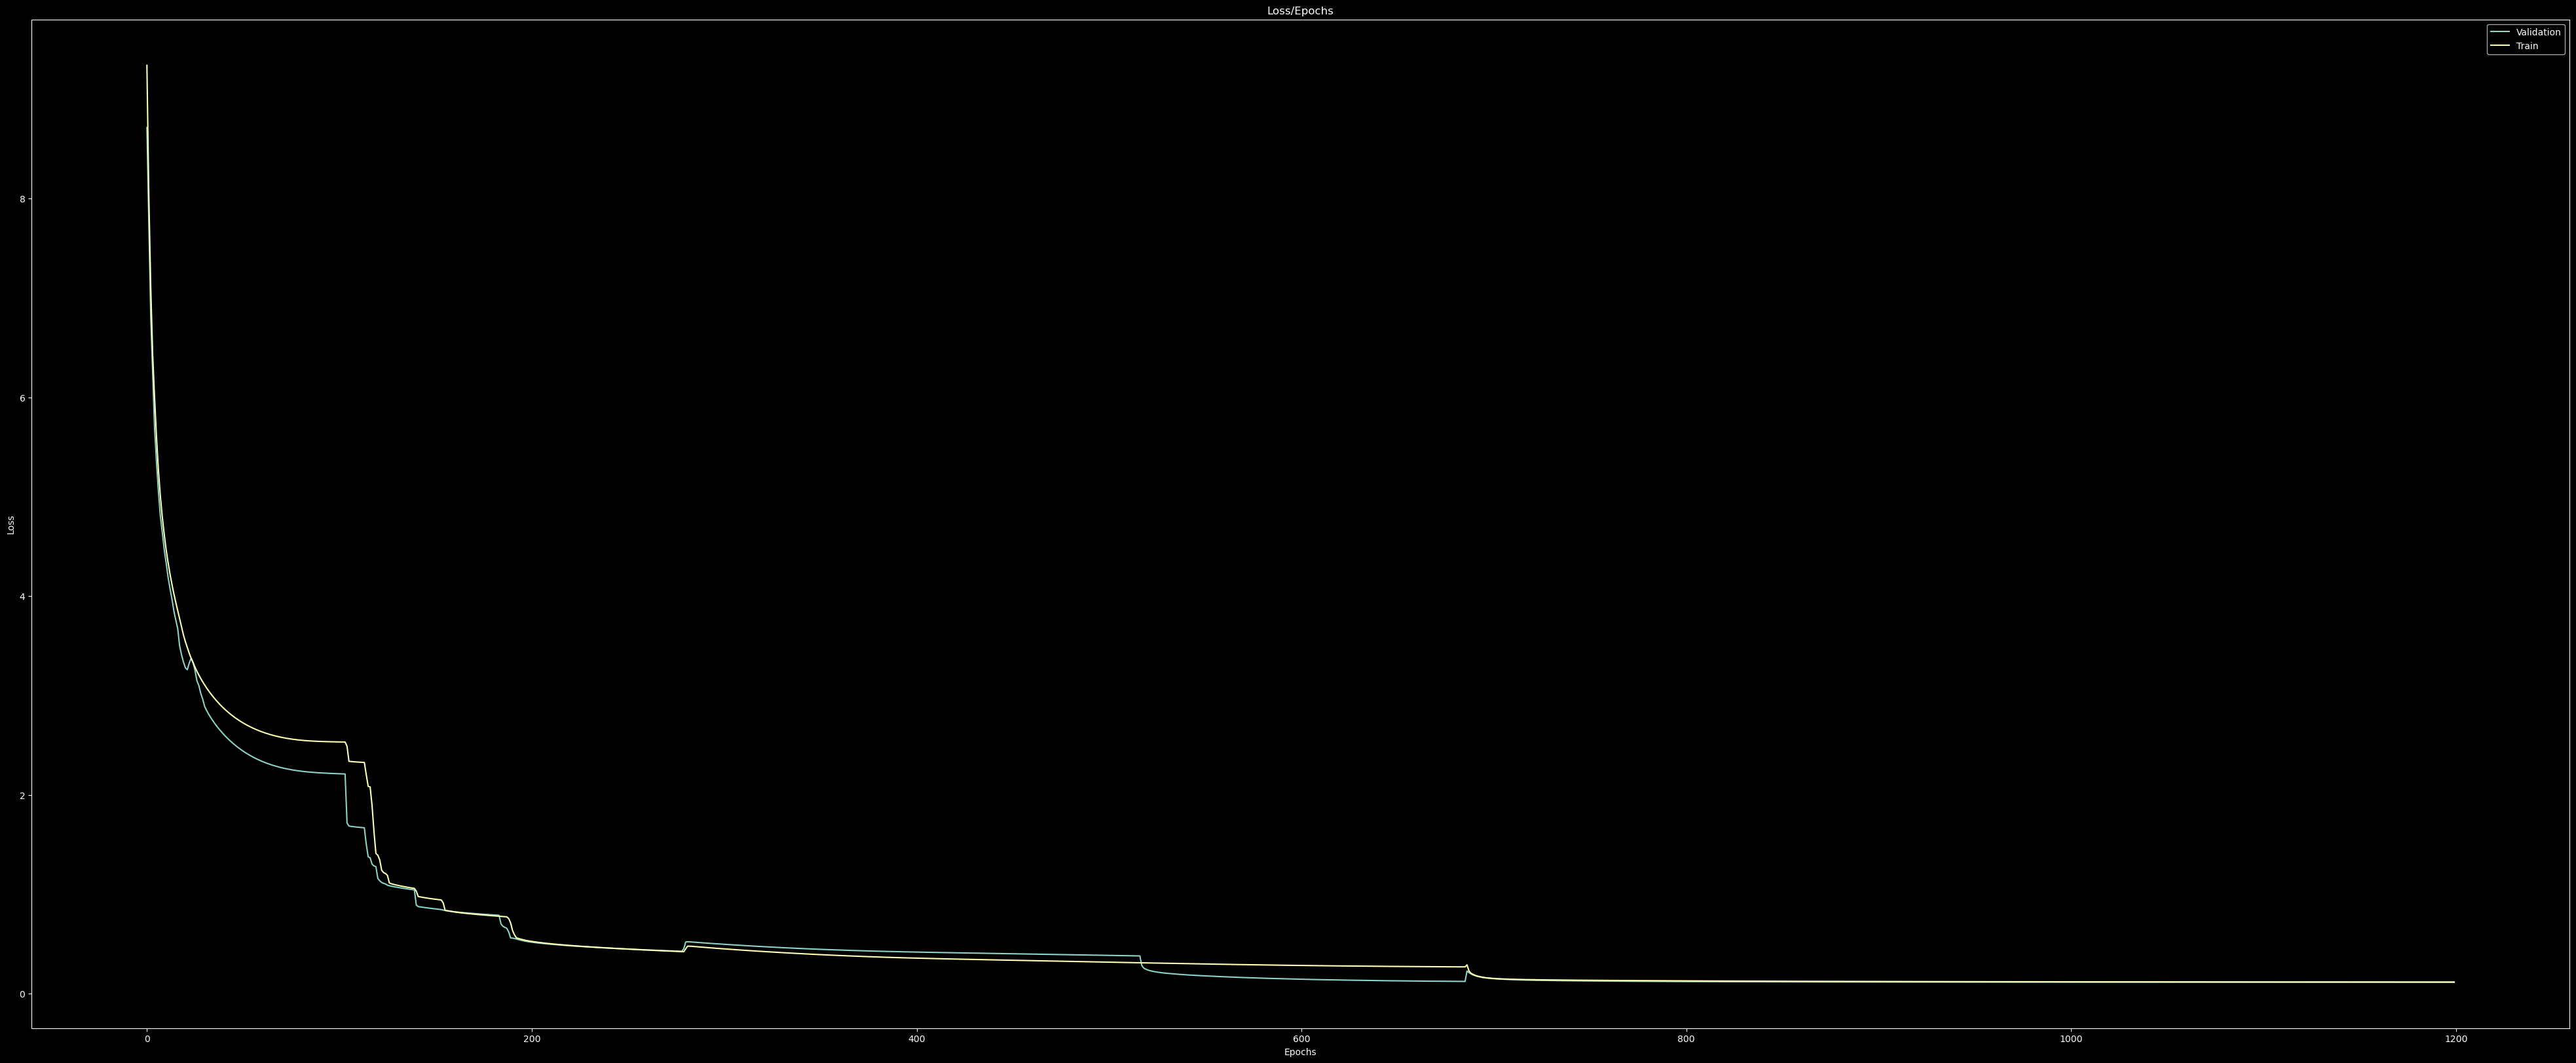

NN with 1000 and <function leaky_relu at 0x70dc157863b0>
Last epoch train error 0.11859719455242157
Last epoch validation error 0.1162119209766388


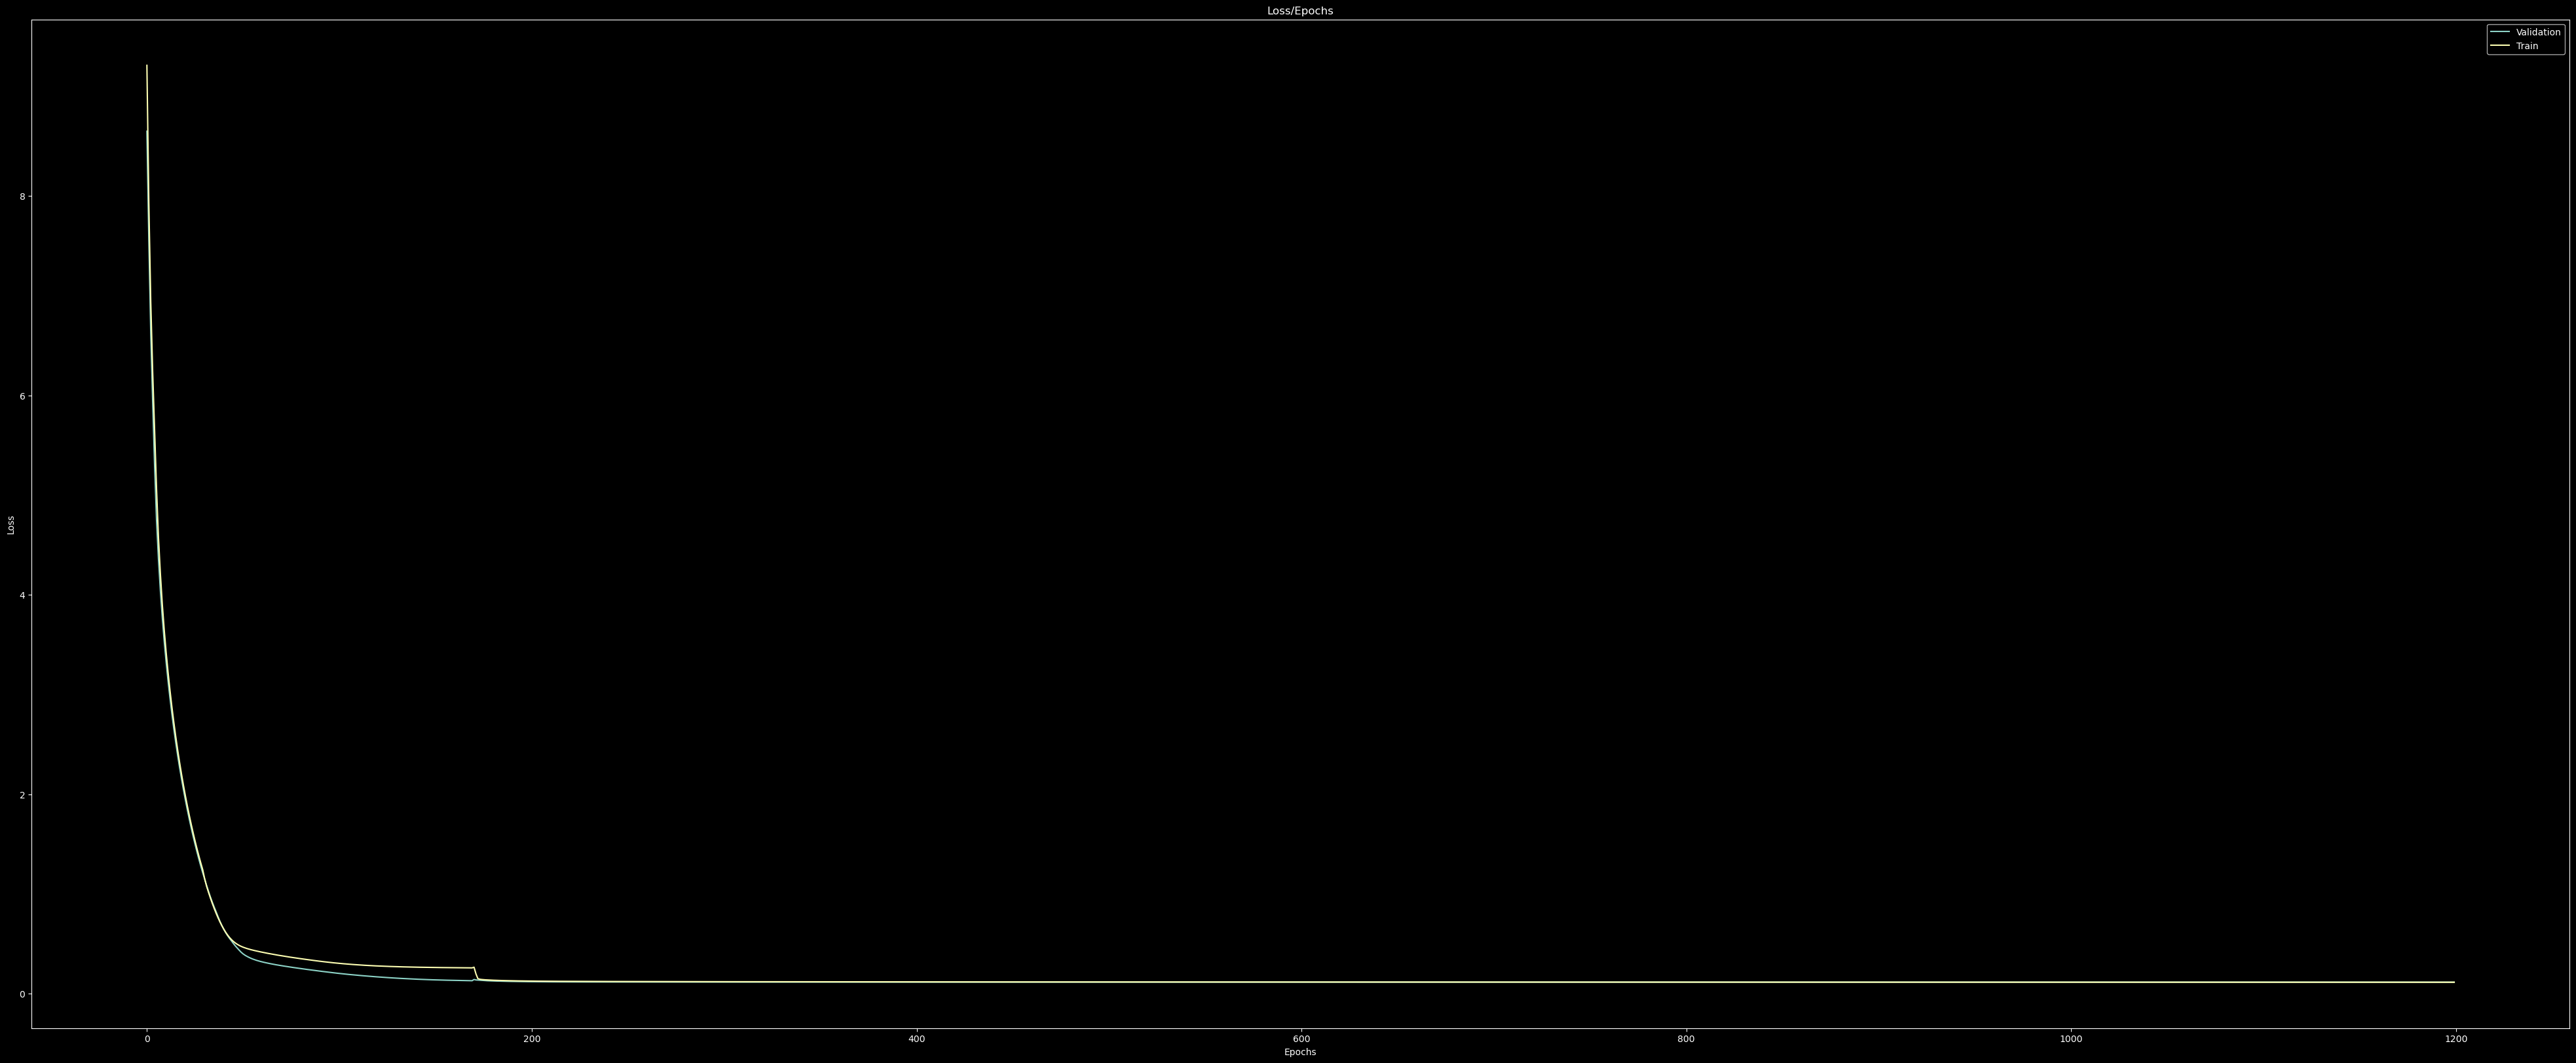

NN with 1000 and <function relu at 0x70dc15bf7d00>
Last epoch train error 0.11602557450532913
Last epoch validation error 0.11703565716743469


In [23]:
param_space_neurons=np.logspace(start=2,stop=3,base=10,num=5,dtype=np.int64)
param_space_activations=[
    activations.tanh,
    activations.leaky_relu,
    activations.relu
]

for neurons in param_space_neurons:
    for activation in param_space_activations: 
        nn = models.Sequential(
            [
                layers.Input((X_tr_proc.shape[1],)),
                layers.Dense(
                    1000,
                    activation=activations.leaky_relu,
                    kernel_initializer=GlorotUniform(0),
                    kernel_constraint=layer_constraints.NonNeg(),
                ),
                layers.Dense(
                    neurons,
                    activation=activation,
                    kernel_initializer=GlorotUniform(0),
                    kernel_constraint=layer_constraints.NonNeg(),
                ),
                layers.Dense(
                    units=1,
                    activation=keras.activations.relu,
                    kernel_initializer=GlorotUniform(0),
                    kernel_constraint=layer_constraints.NonNeg(),
                ),
            ]
        )

        train_nn(
            nn=nn,
            X=X_tr_scalled,
            y=Y_tr,
            epochs=1200,
            should_print_epoch_losses=True,
            additional_print_msg=f'NN with {neurons} and {str(activation)}'
        )

# LSTM 

In [79]:
tmp=pd.concat([
    X_tr_proc,
    Y_tr
],axis=1)
tmp=tmp.sort_values('AgeFromLastRemodelingPriSale',ascending=False)
WINDOW=5
tmp_X,tmp_y=tmp.drop('SalePrice',axis=1),tmp['SalePrice']
X_time_series,y_time_series=[],[]
scaller=StandardScaler() 
scaller.fit(tmp_X)

for i in range(tmp_X.shape[0] - WINDOW):
        X_time_series.append(
            scaller.transform(tmp_X[i:i + WINDOW]),
            # tmp_X[i:i + WINDOW]
        ) 
        y_time_series.append(tmp_y[i + WINDOW])

X_time_series,y_time_series=np.array(X_time_series),np.array(y_time_series)

In [80]:
X_time_series.shape

(1163, 5, 77)

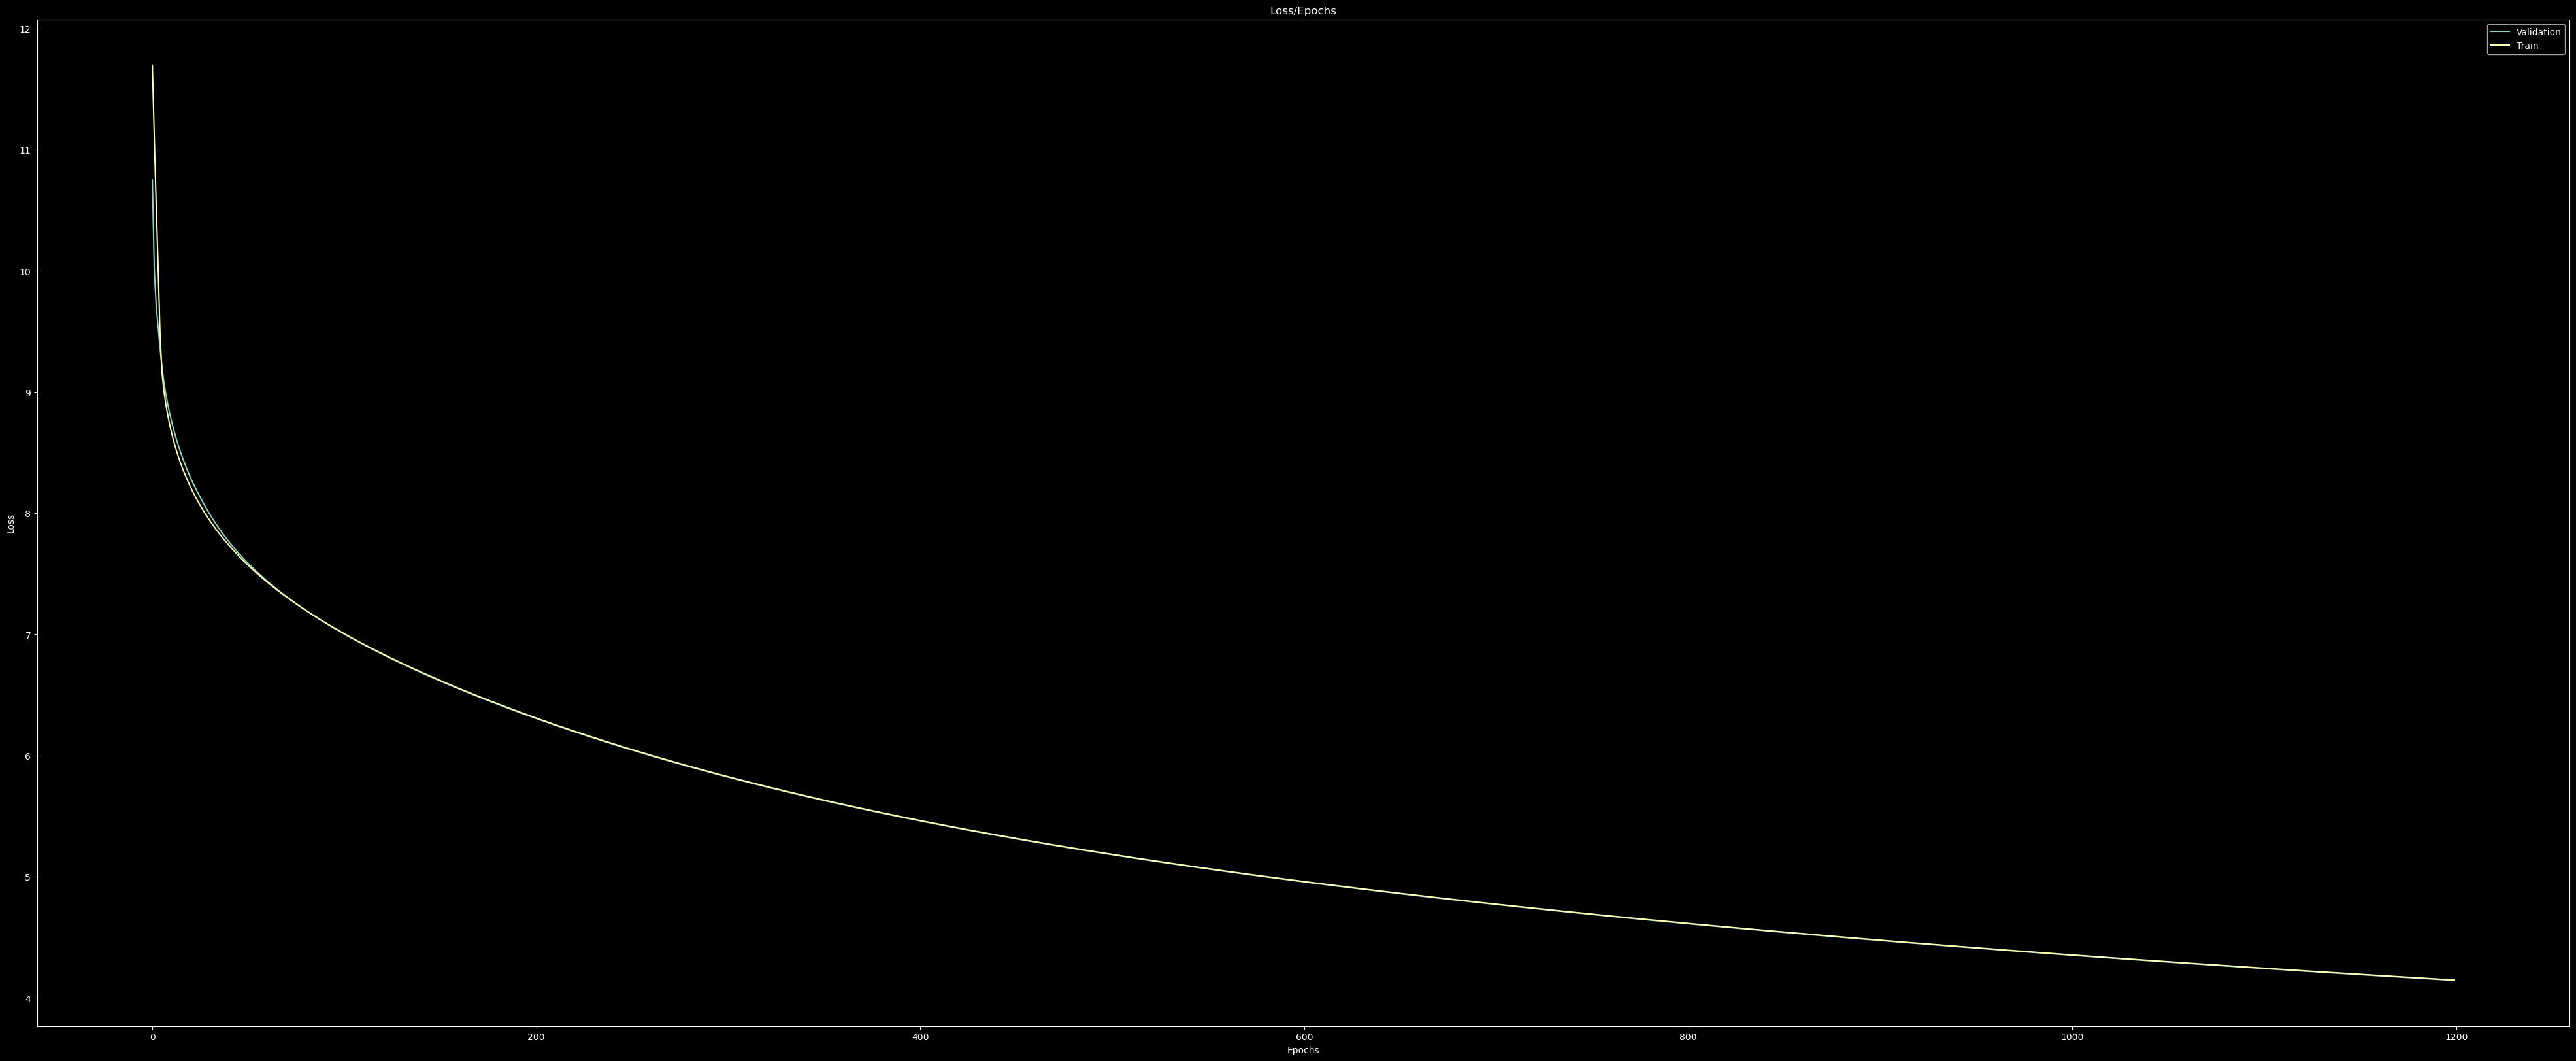

LSTM with cell state 100
Last epoch train error 4.147022724151611
Last epoch validation error 4.144147872924805


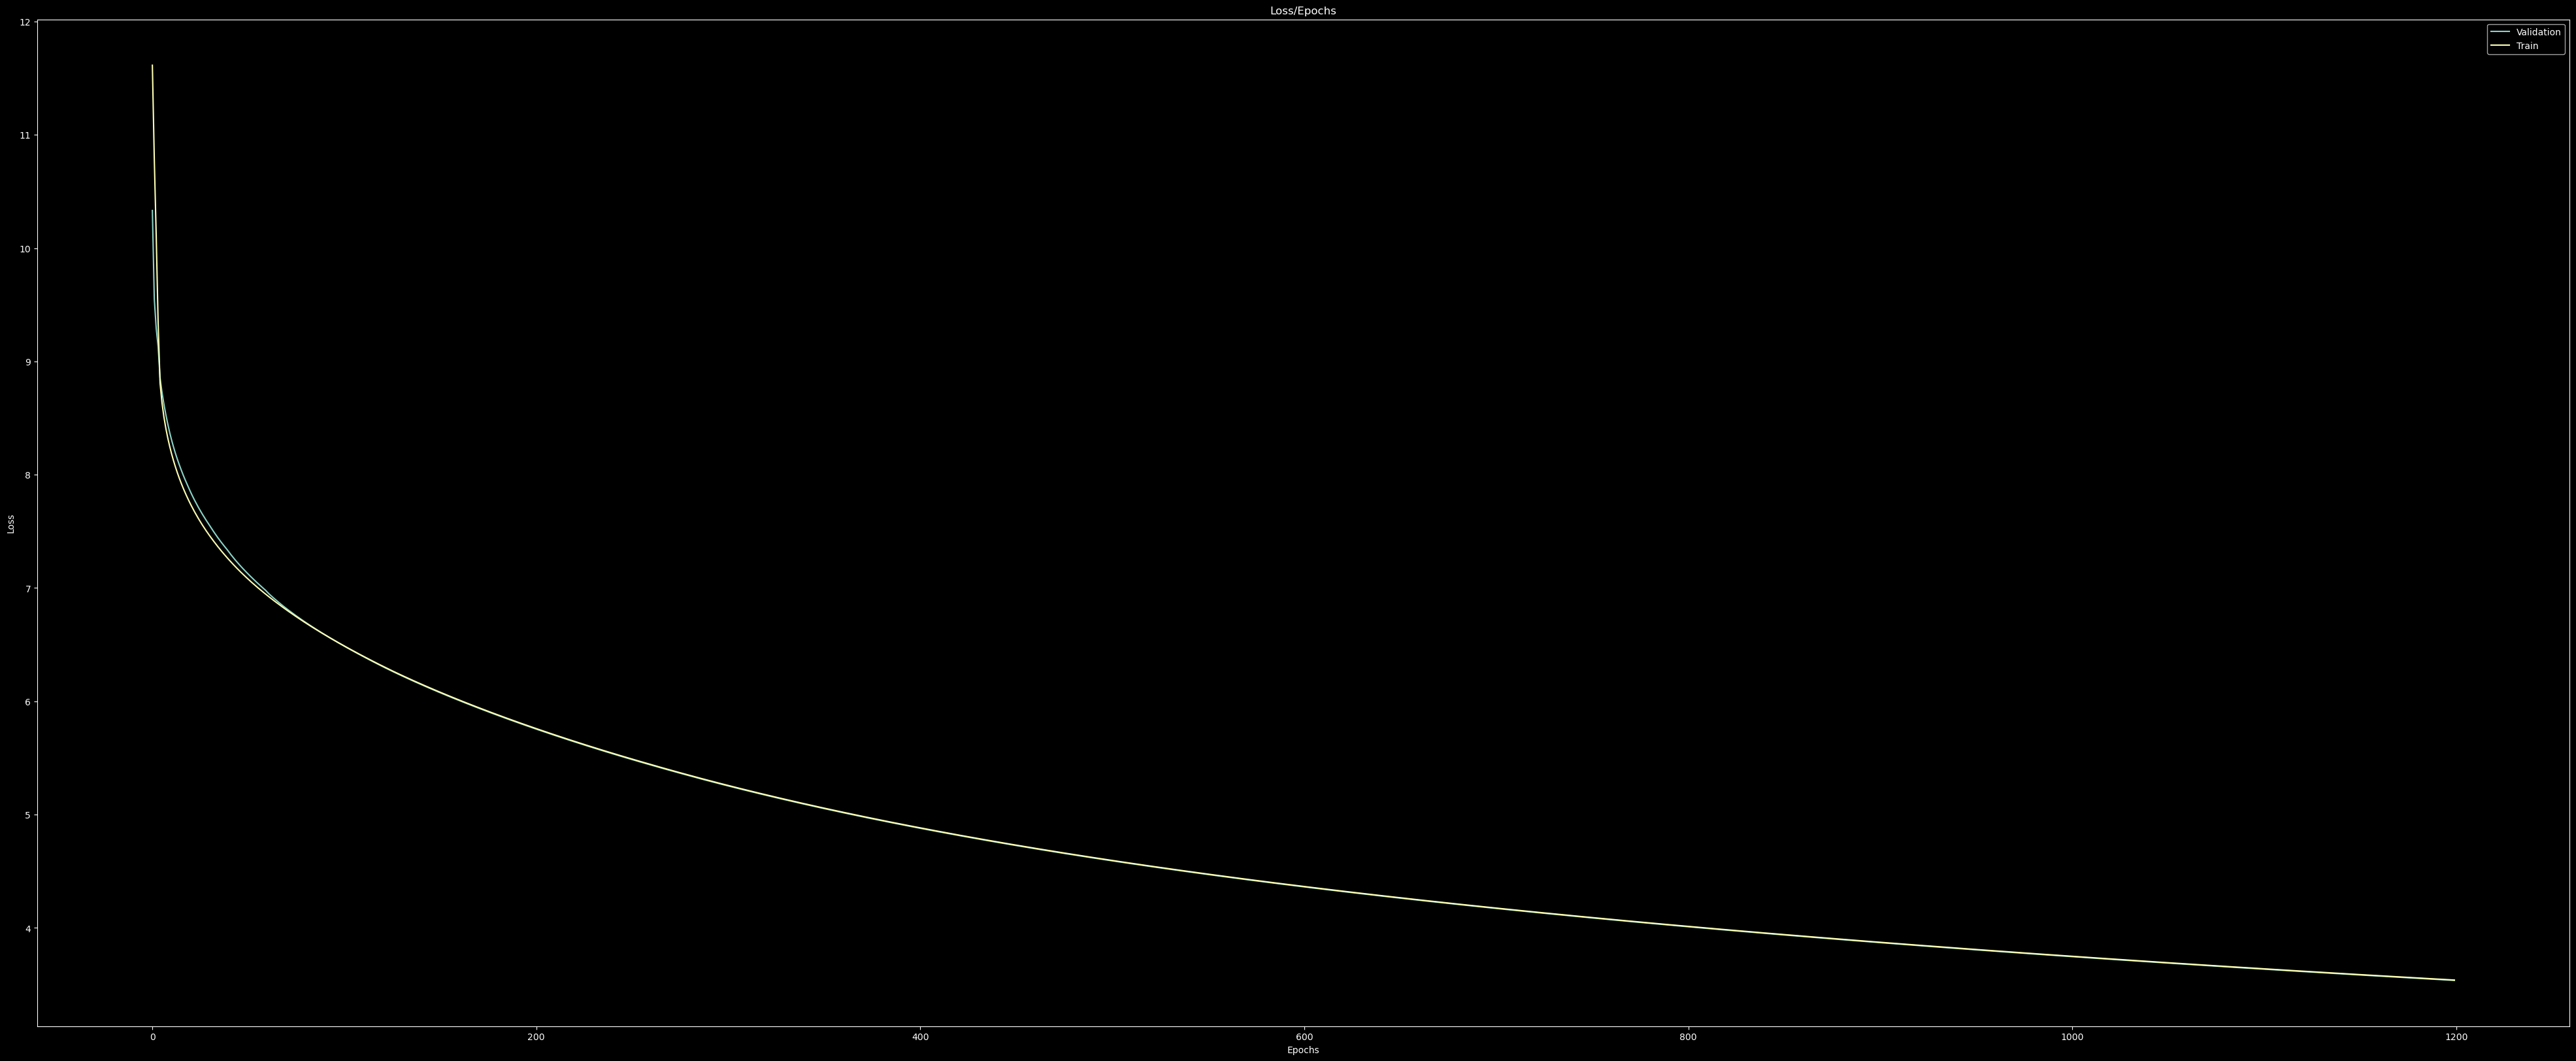

LSTM with cell state 177
Last epoch train error 3.5398690700531006
Last epoch validation error 3.5366134643554688


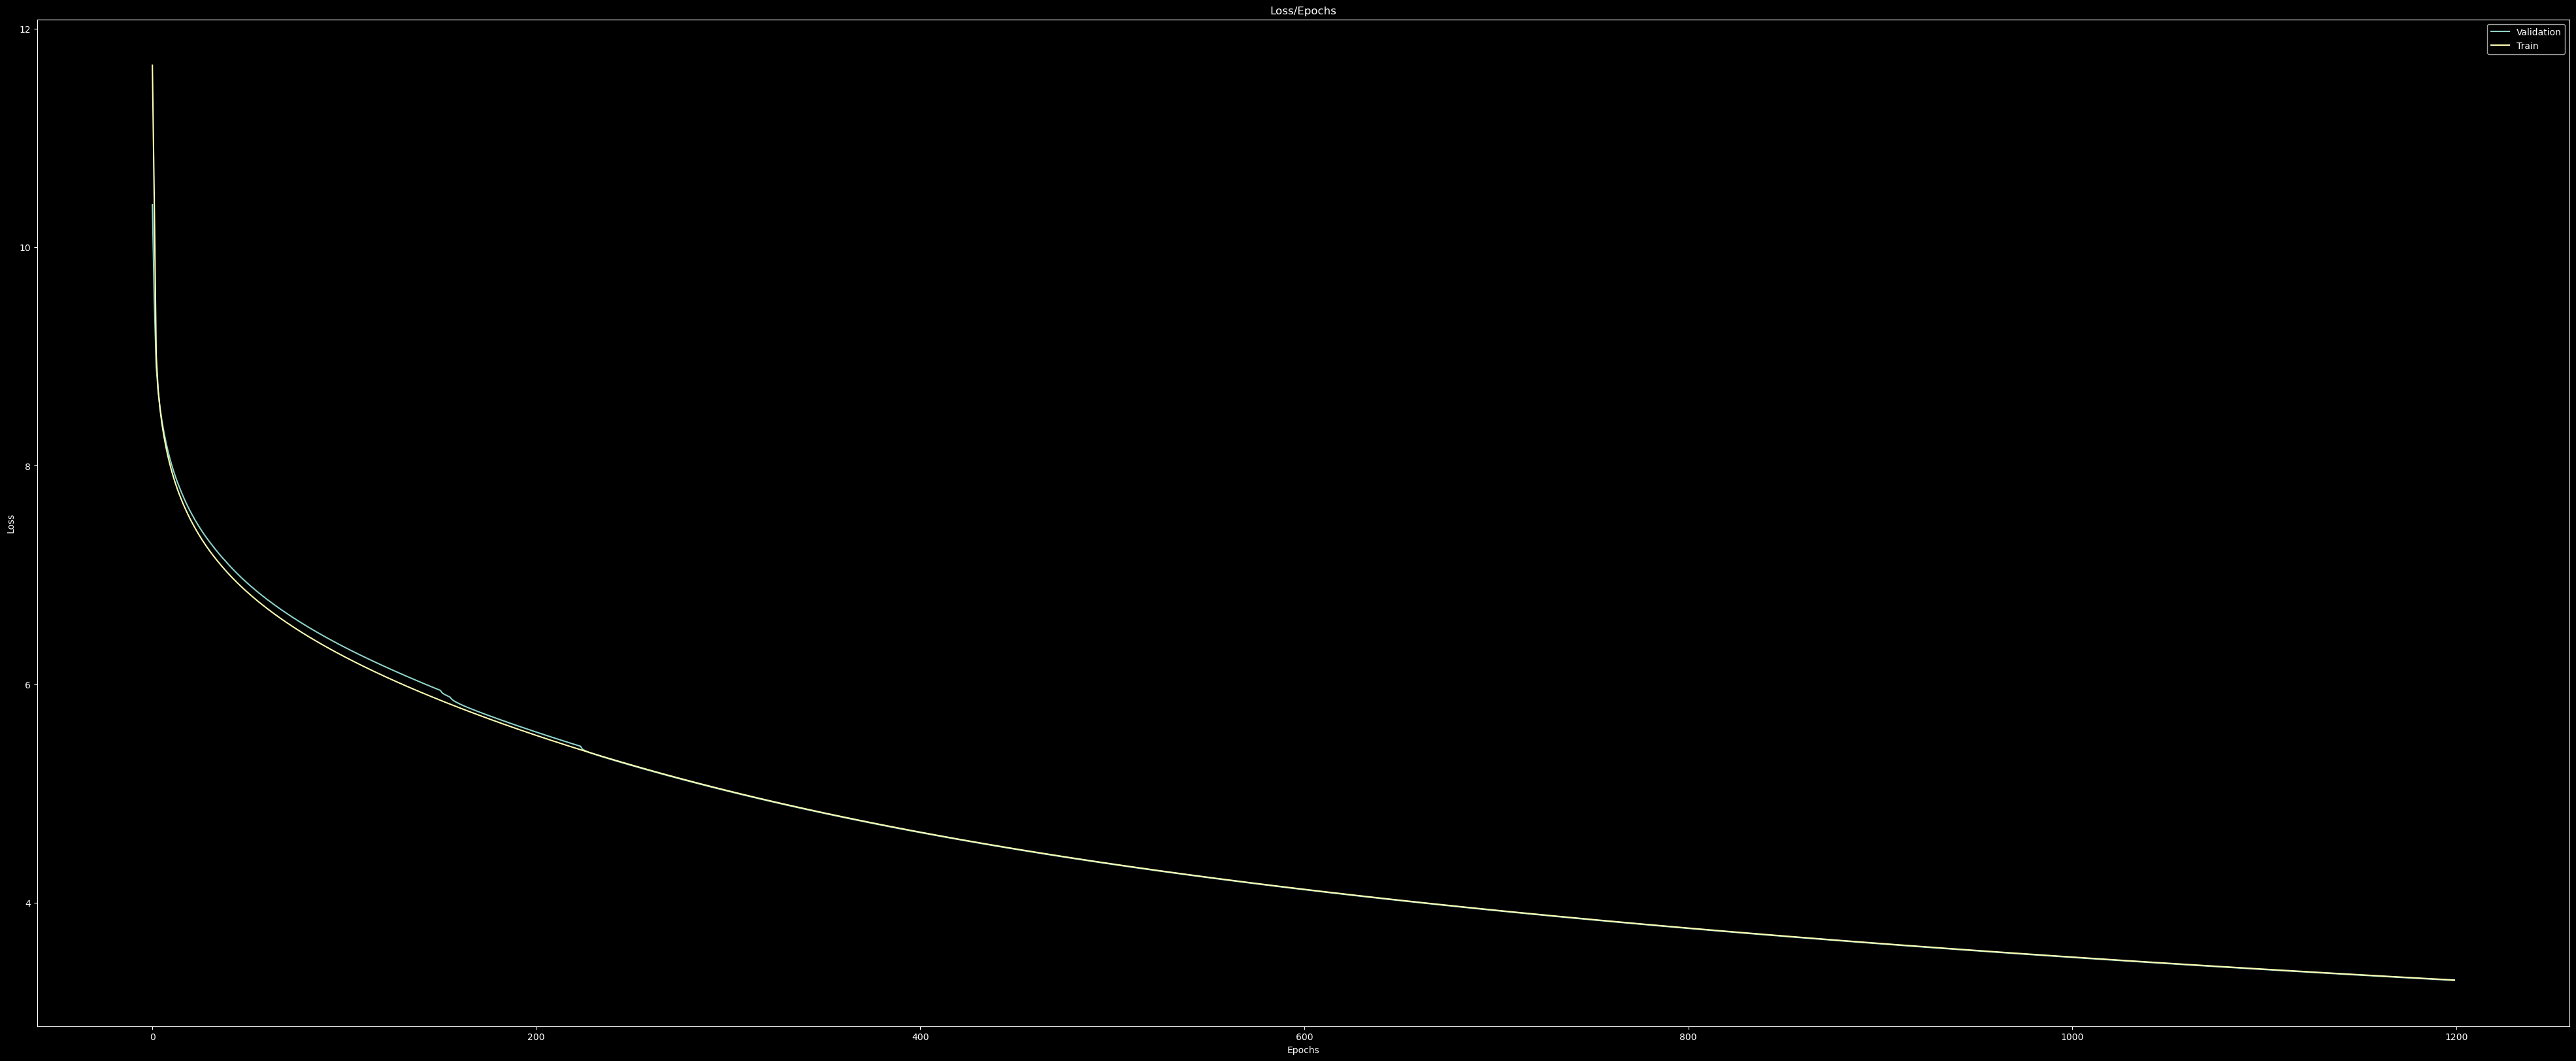

LSTM with cell state 316
Last epoch train error 3.2930777072906494
Last epoch validation error 3.2896294593811035


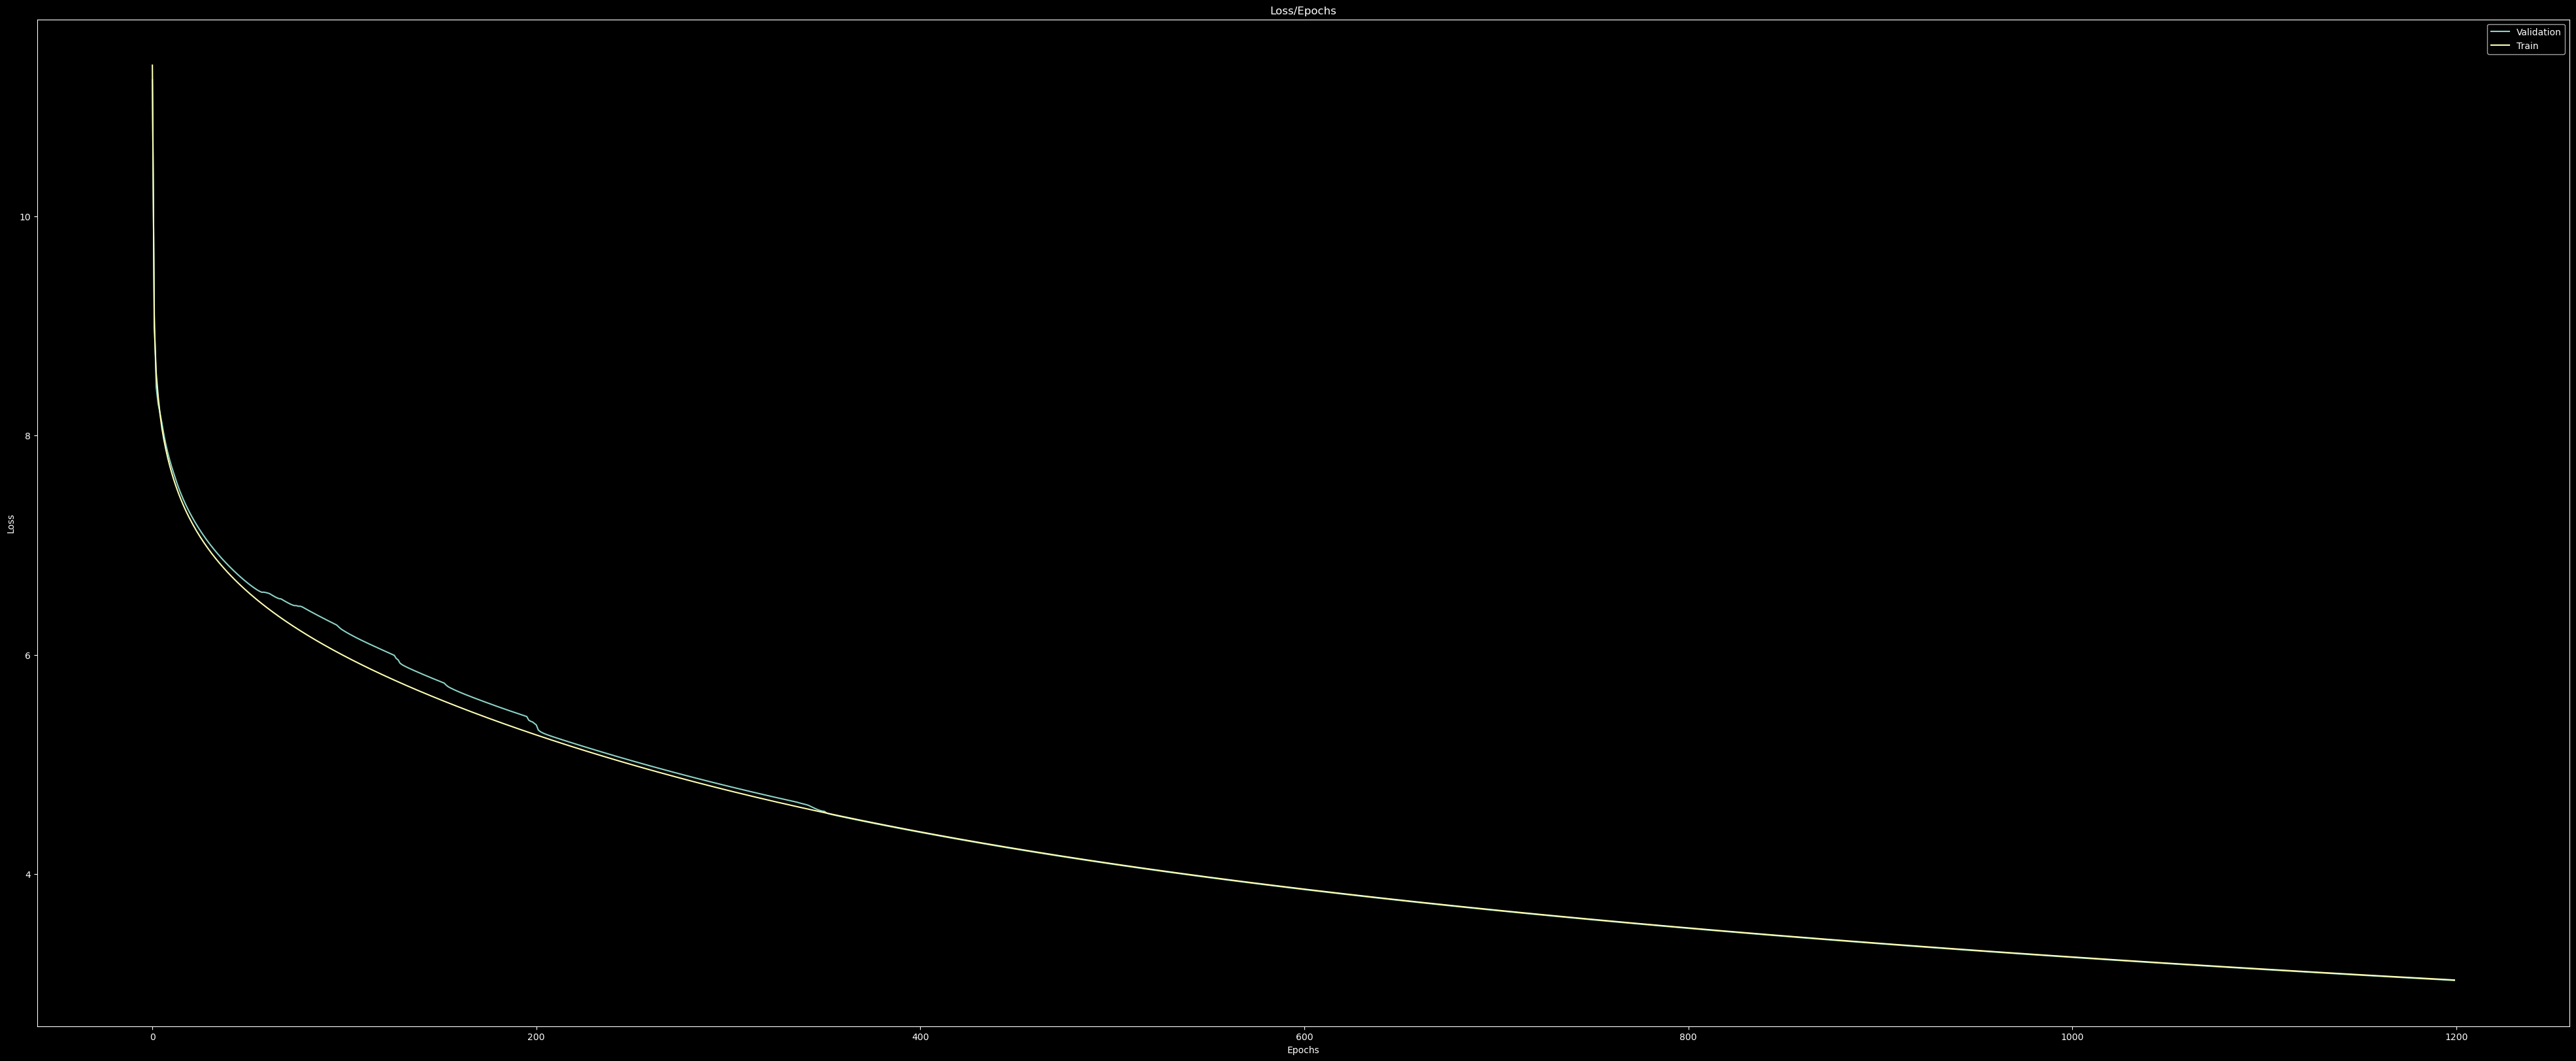

LSTM with cell state 562
Last epoch train error 3.033630132675171
Last epoch validation error 3.0299532413482666


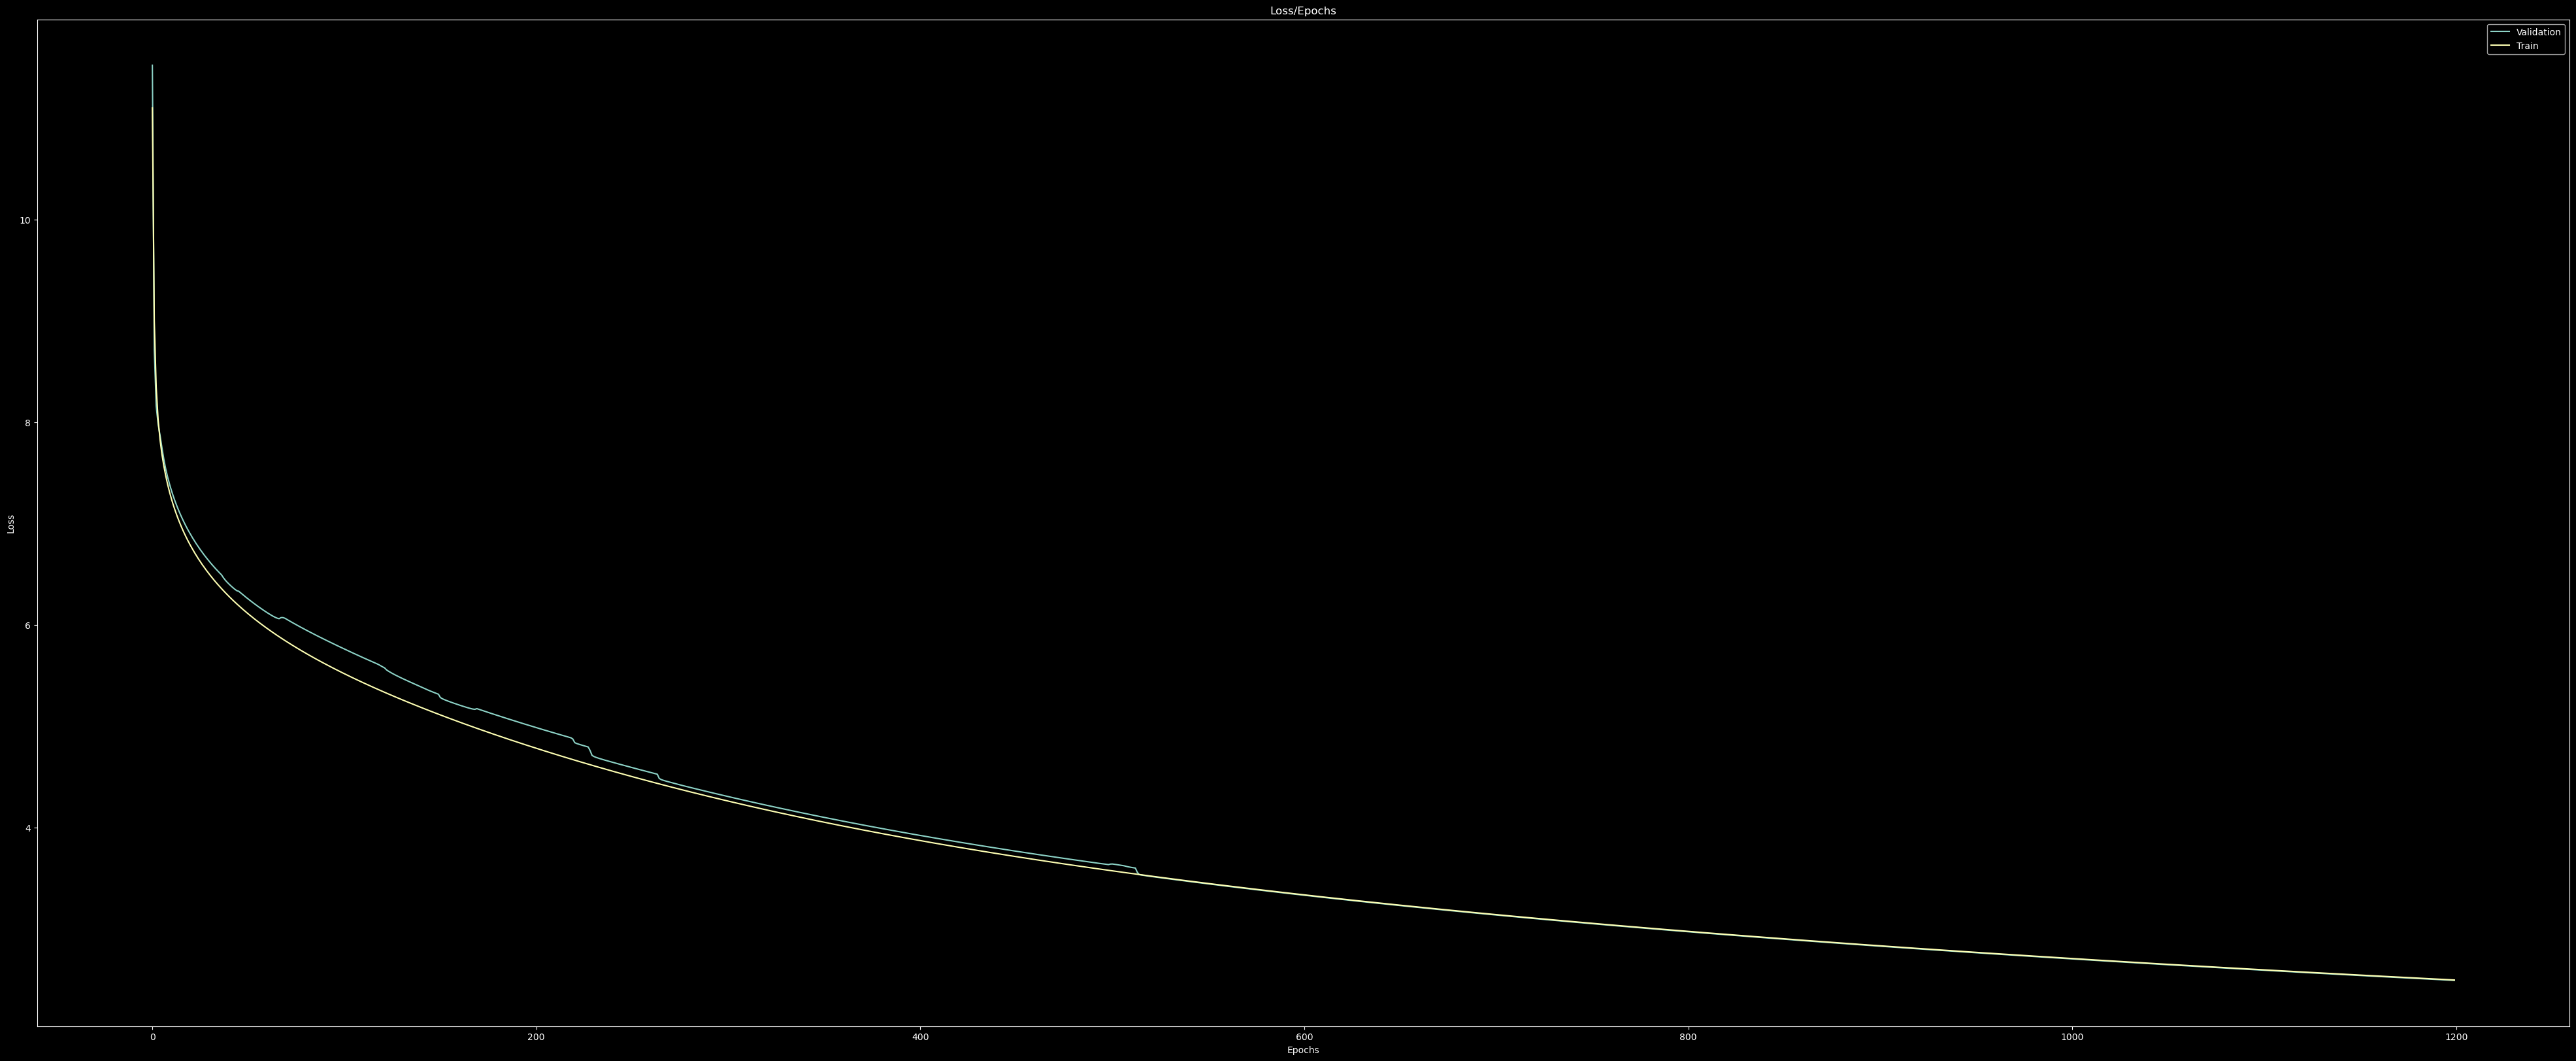

LSTM with cell state 1000
Last epoch train error 2.4970083236694336
Last epoch validation error 2.4927048683166504


In [81]:
param_space_cell_state = np.logspace(start=2, stop=3, base=10, num=5, dtype=np.int64).tolist()
for ns in param_space_cell_state:
    lstm = models.Sequential(
        [
            layers.Input((X_time_series.shape[1], X_time_series.shape[2])),
            layers.LSTM(
                ns,
                kernel_initializer=GlorotUniform(0),
                kernel_constraint=layer_constraints.NonNeg(),
            ),
            layers.Dense(
                1,
                activation=activations.relu,
                kernel_initializer=GlorotUniform(0),
                kernel_constraint=layer_constraints.NonNeg(),
            )
        ]
    ) 
        
    train_nn(
        nn=lstm,
        X=X_time_series,
        y=y_time_series,
        epochs=1200,
        should_print_epoch_losses=True,
        additional_print_msg=f'LSTM with cell state {ns}'
    )

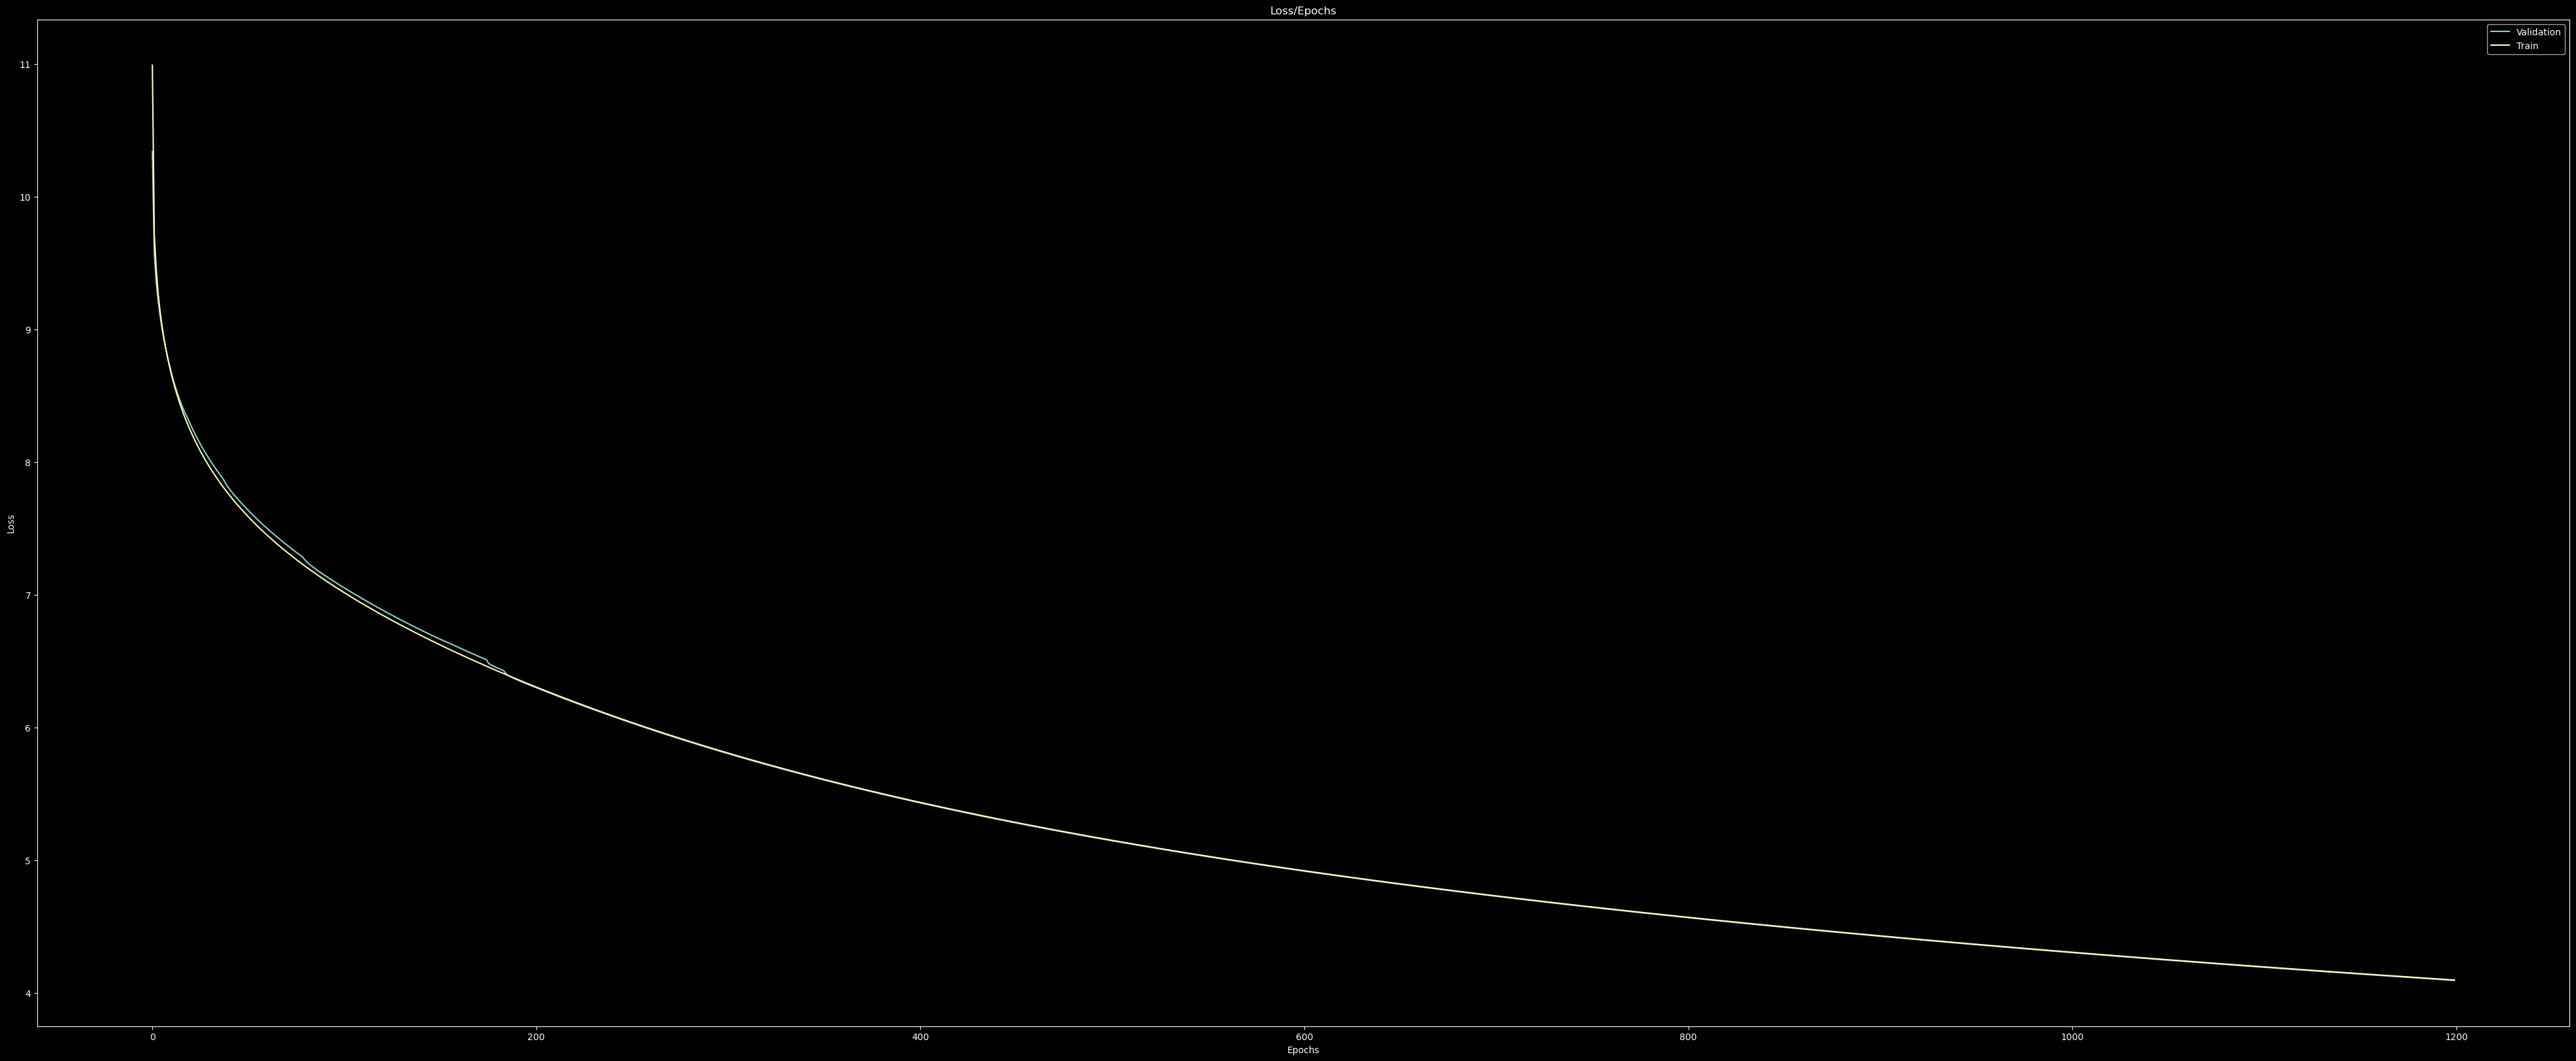

LSTM with cell state 100
Last epoch train error 4.095516681671143
Last epoch validation error 4.092609882354736


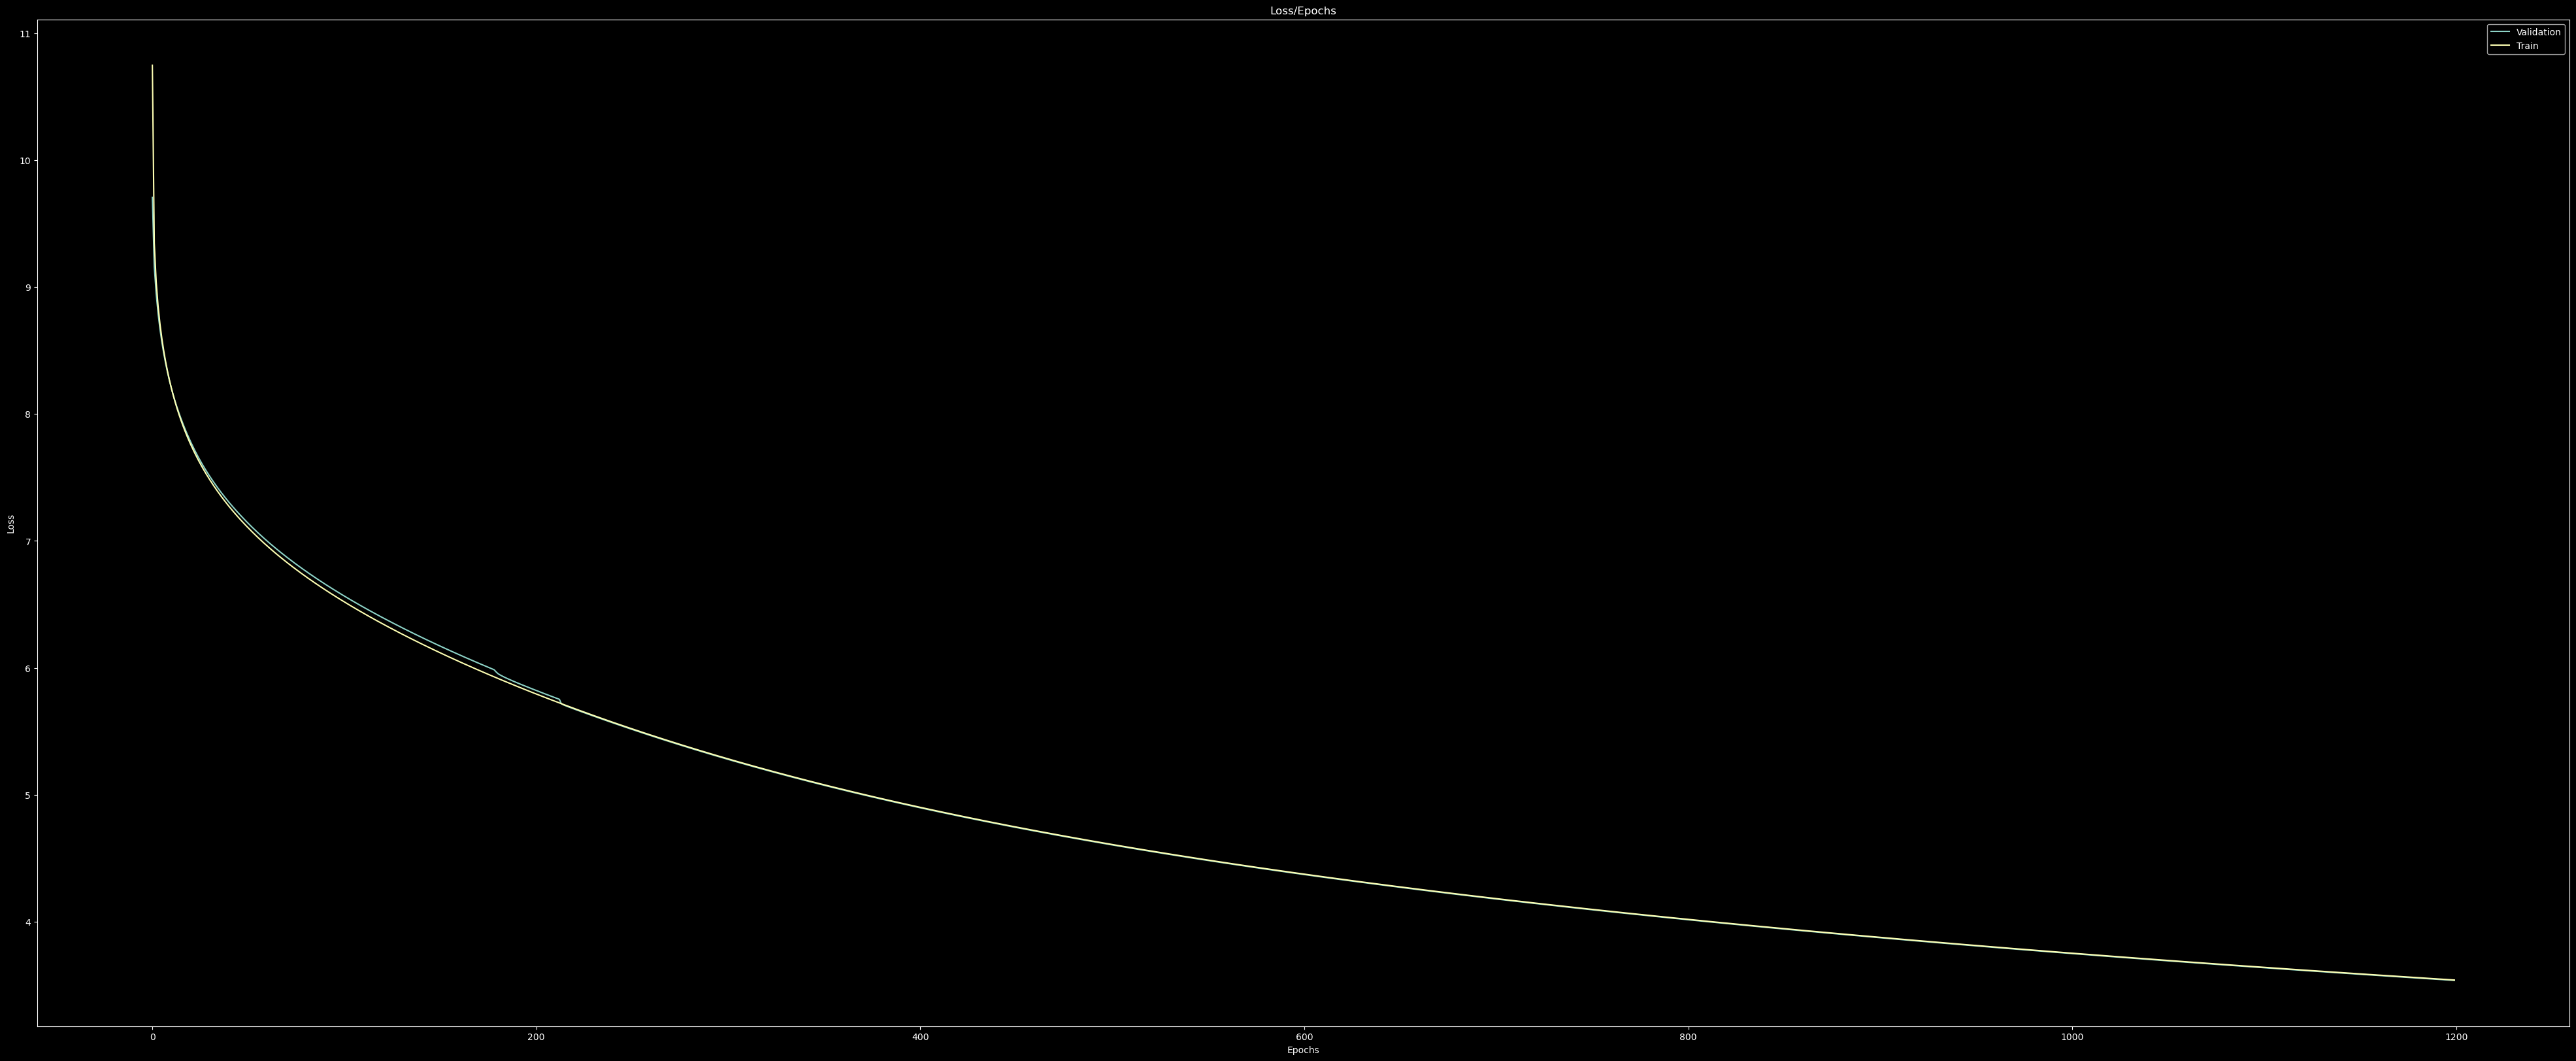

LSTM with cell state 177
Last epoch train error 3.541416883468628
Last epoch validation error 3.53816819190979


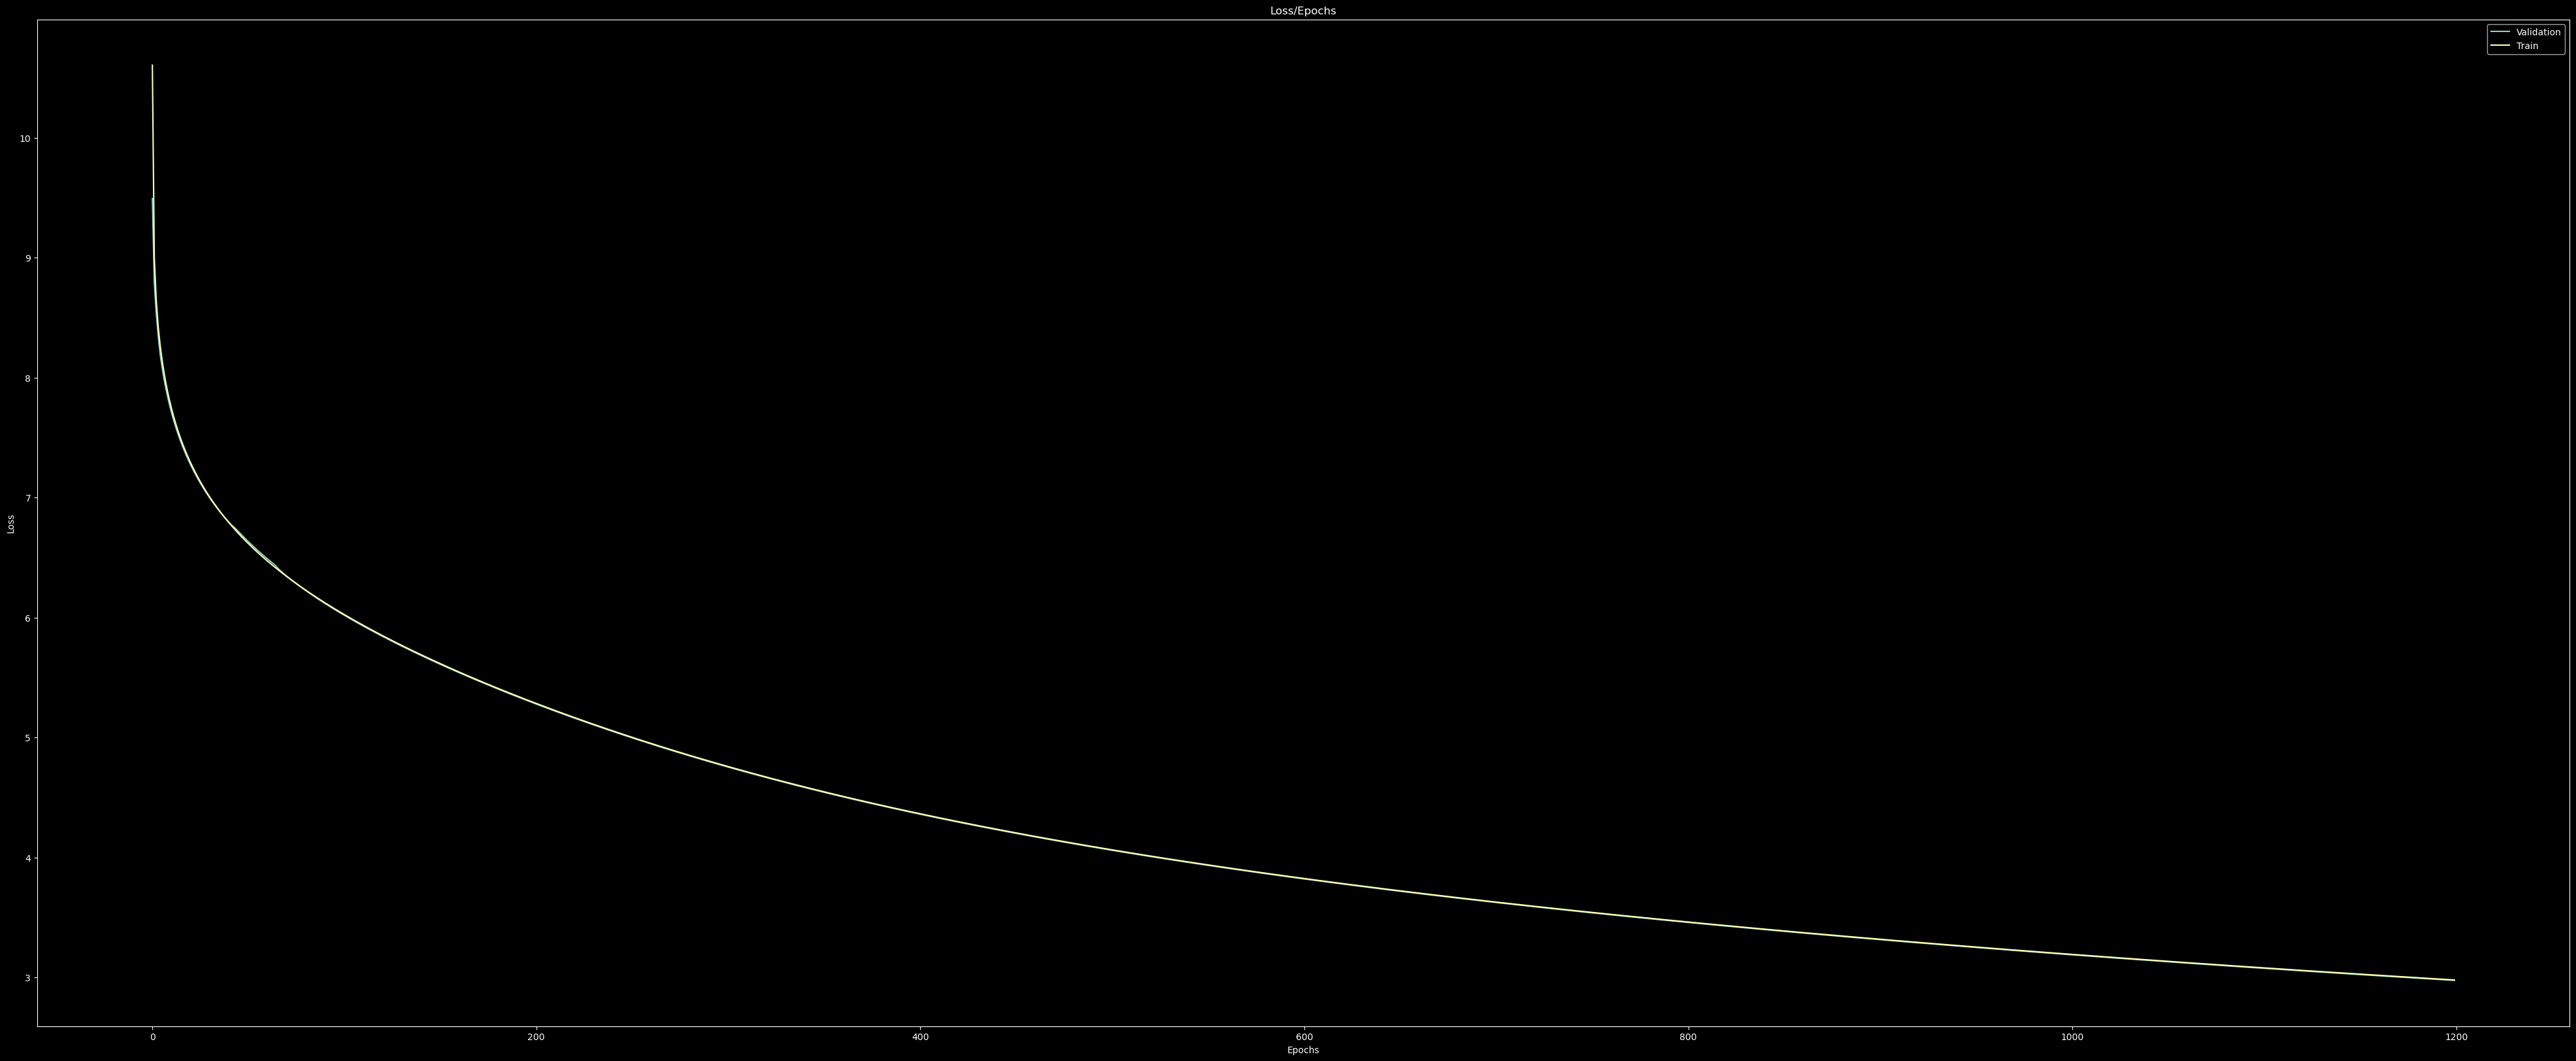

LSTM with cell state 316
Last epoch train error 2.9797303676605225
Last epoch validation error 2.9759912490844727


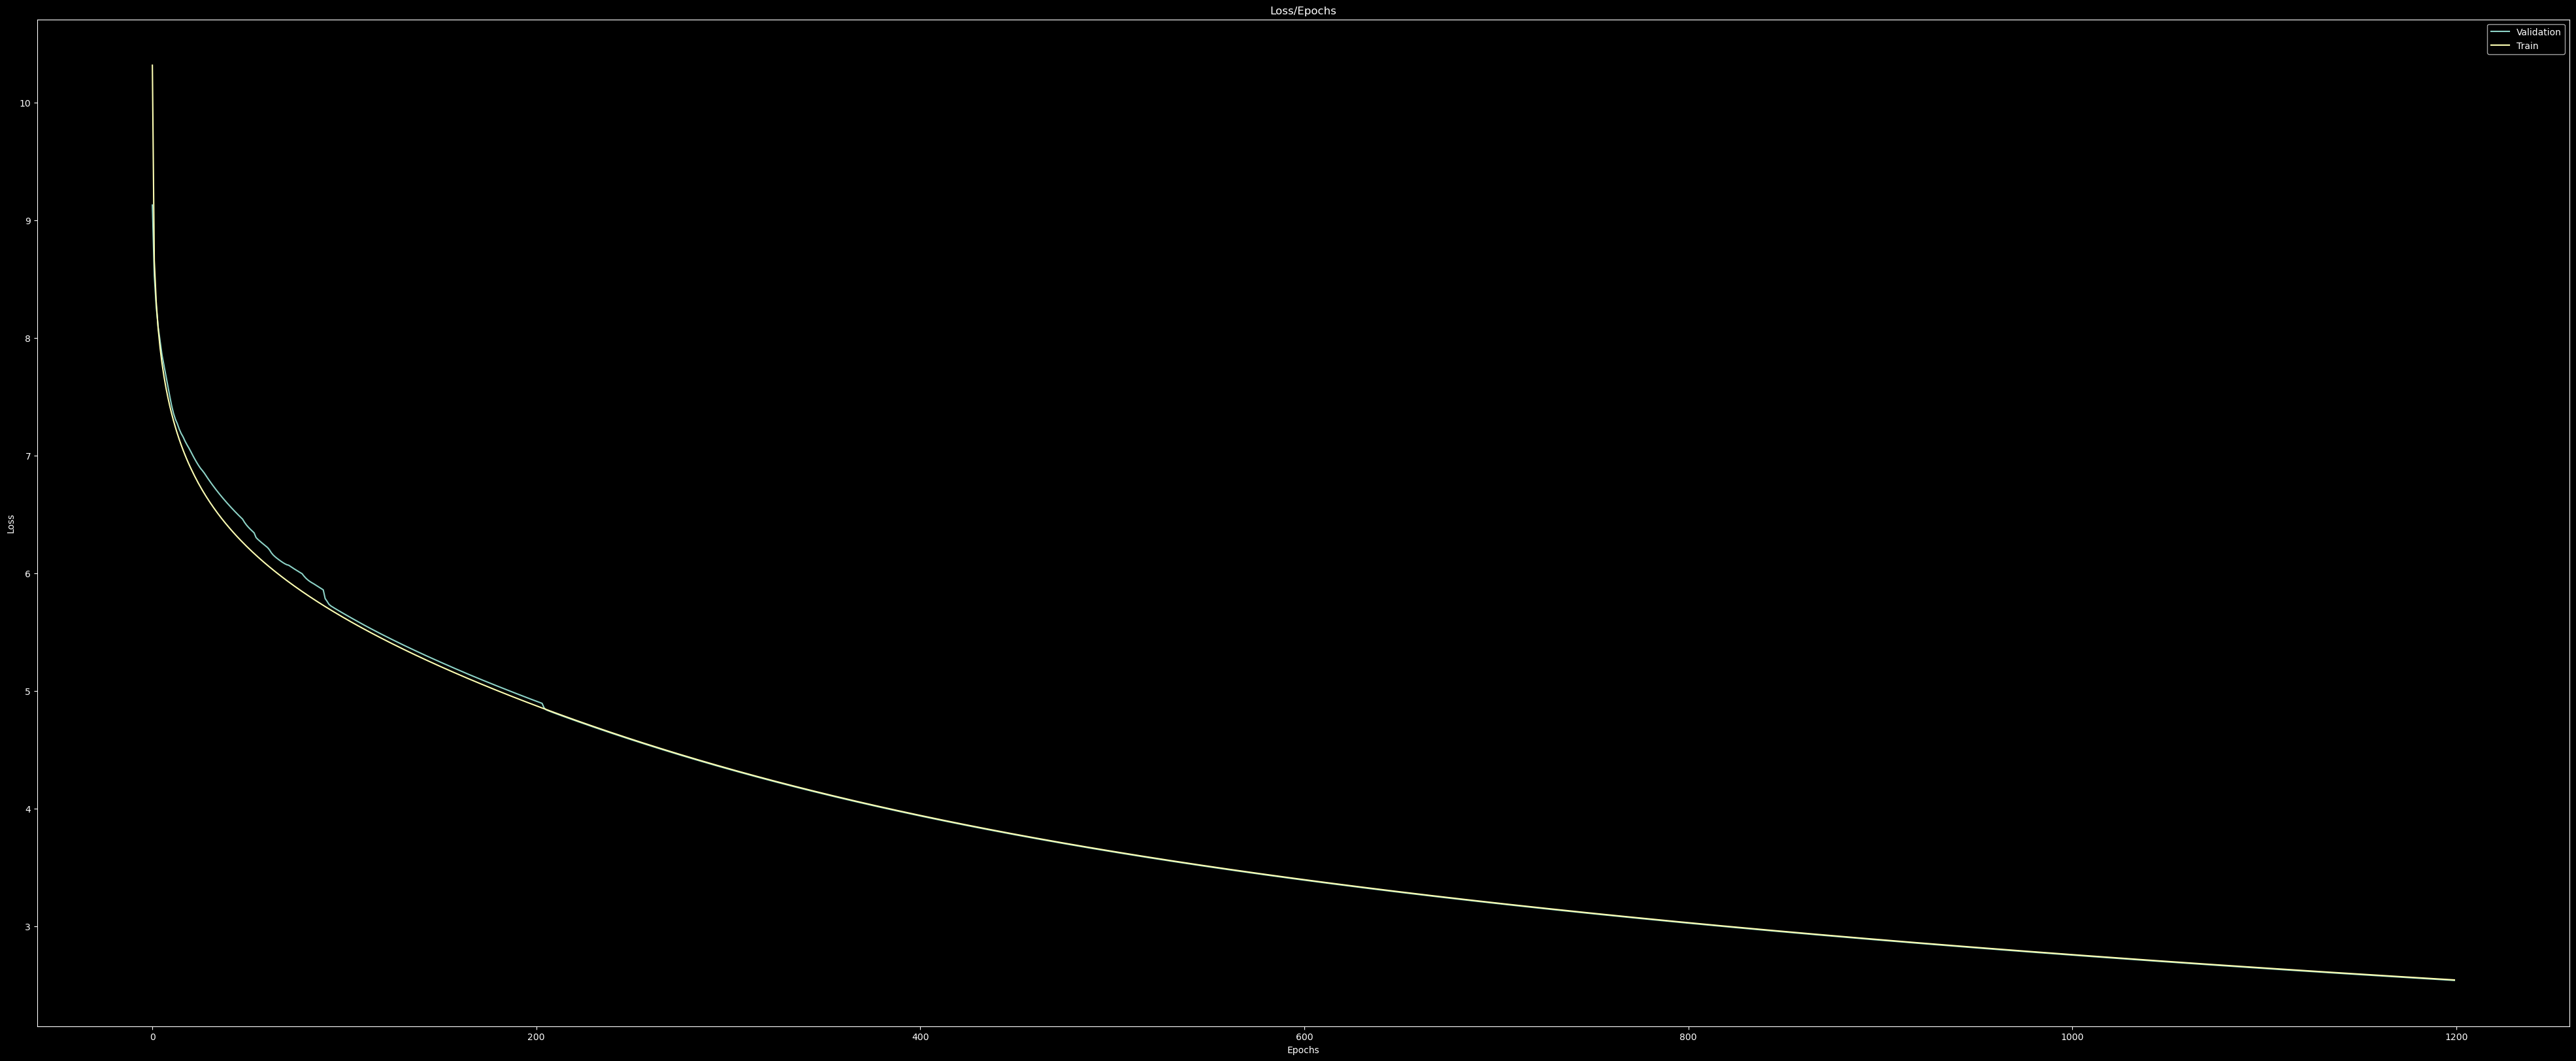

LSTM with cell state 562
Last epoch train error 2.5445029735565186
Last epoch validation error 2.5402684211730957


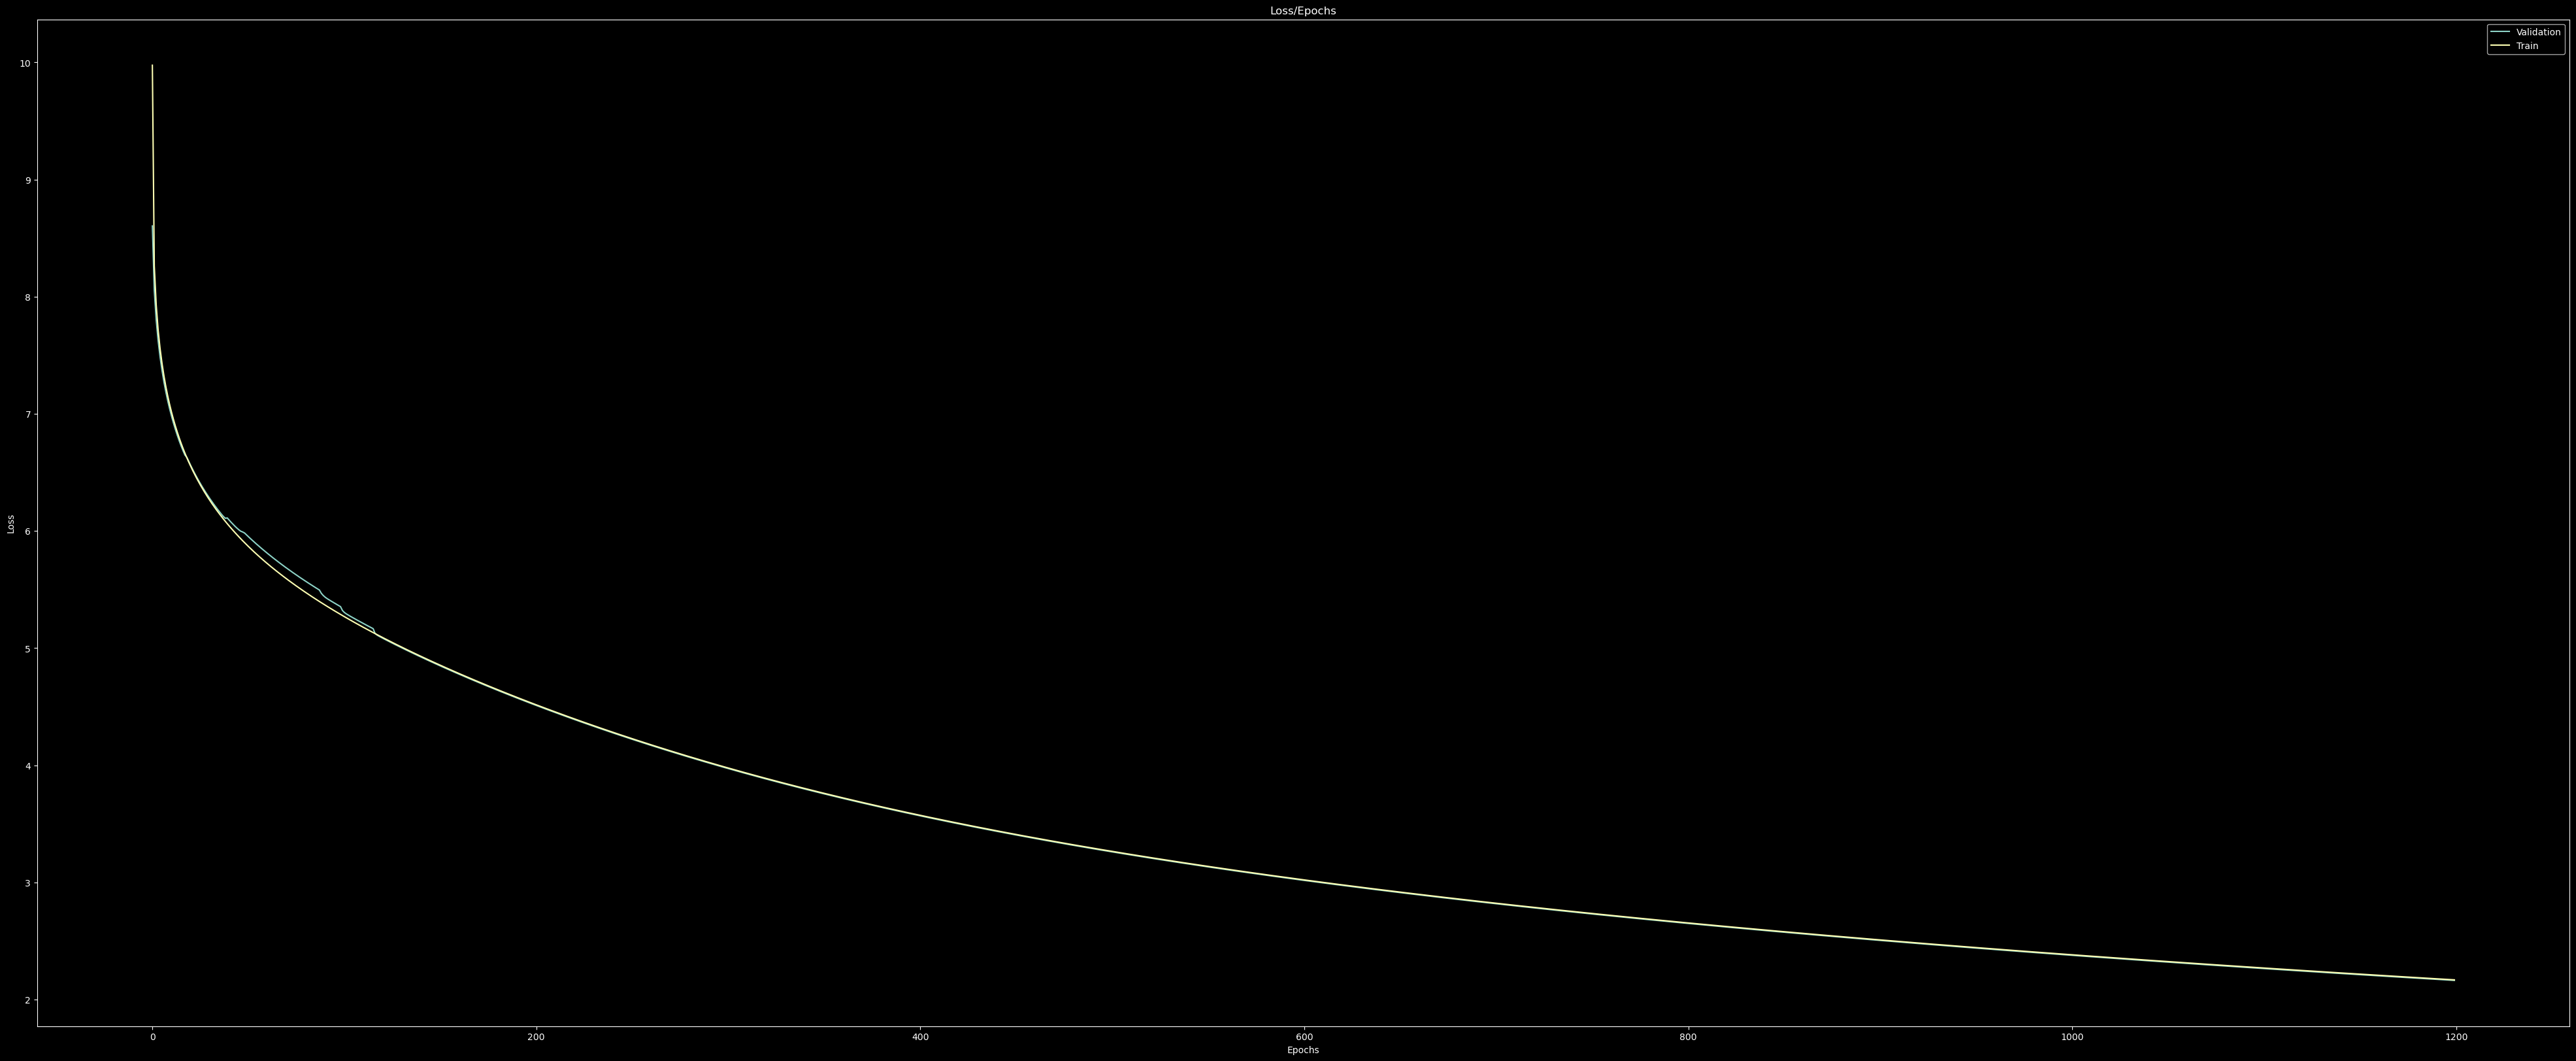

LSTM with cell state 1000
Last epoch train error 2.1688690185546875
Last epoch validation error 2.1640400886535645


In [84]:
param_space_cell_state = np.logspace(start=2, stop=3, base=10, num=5, dtype=np.int64).tolist()
for ns in param_space_cell_state:
    lstm = models.Sequential(
        [
            layers.Input((X_time_series.shape[1], X_time_series.shape[2])),
            layers.LSTM(
                1000,
                return_sequences=True, 
                kernel_initializer=GlorotUniform(0),
                kernel_constraint=layer_constraints.NonNeg(),
            ),
            layers.LSTM(
                ns,
                return_sequences=False, 
                kernel_initializer=GlorotUniform(0),
                kernel_constraint=layer_constraints.NonNeg(),
            ),
            layers.Dense(
                1,
                activation=activations.relu,
                kernel_initializer=GlorotUniform(0),
                kernel_constraint=layer_constraints.NonNeg(),
            )
        ]
    ) 
        
    train_nn(
        nn=lstm,
        X=X_time_series,
        y=y_time_series,
        epochs=1200,
        should_print_epoch_losses=True,
        additional_print_msg=f'LSTM with cell state {ns}'
    )

# Test dataset

In [89]:
nn = models.Sequential(
    [
        layers.Input((X_tr_proc.shape[1],)),
        layers.Dense(
            1000,
            activation=activations.leaky_relu,
            kernel_initializer=GlorotUniform(0),
            kernel_constraint=layer_constraints.NonNeg(),
        ),
        layers.Dense(
            562,
            activation=activations.leaky_relu,
            kernel_initializer=GlorotUniform(0),
            kernel_constraint=layer_constraints.NonNeg(),
        ),
        layers.Dense(
            units=1,
            activation=keras.activations.relu,
            kernel_initializer=GlorotUniform(0),
            kernel_constraint=layer_constraints.NonNeg(),
        ),
    ]
)

nn.compile(optimizer="adam", loss=tf_rmsle, metrics=[tf_rmsle])

nn.fit(
    x=X_tr_scalled,
    y=Y_tr,
    epochs=700,
    batch_size=32,
    validation_split=0.25,
    shuffle=False
)

nn.evaluate(x=X_test_scalled, y=Y_tst)[1]

Epoch 1/700
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 9.9266 - tf_rmsle: 9.9255 - val_loss: 9.0047 - val_tf_rmsle: 8.9606
Epoch 2/700
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.5844 - tf_rmsle: 8.5828 - val_loss: 8.0899 - val_tf_rmsle: 8.0835
Epoch 3/700
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6538 - tf_rmsle: 7.6521 - val_loss: 7.2299 - val_tf_rmsle: 7.1400
Epoch 4/700
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9808 - tf_rmsle: 6.9793 - val_loss: 6.6846 - val_tf_rmsle: 6.5958
Epoch 5/700
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5465 - tf_rmsle: 6.5450 - val_loss: 6.3240 - val_tf_rmsle: 6.2330
Epoch 6/700
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2001 - tf_rmsle: 6.1987 - val_loss: 5.9830 - val_tf_rmsle: 5.8911
Epoch 7/700
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8824 - tf_rmsle: 5.8810 - val_loss: 5.7446 - val_tf_rmsle: 5.6464
Epoch 8/700
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6327 - tf_rmsle: 5.6313 - val_loss: 5.4978 - val_

0.12998002767562866